<a href="https://colab.research.google.com/github/helenksouza/helenksouza/blob/main/Curso_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



>   Introdução às redes neurais convolucionais(CNN)

* usada para visão computacional
* melhores que SVM (support vehicle machine)




Imagens são formadas por pixels, as quais imagens coloridas partem da coloração básica RGB(red, green, black).

## Introdução a PyTorch

* O que é uma rede neural artificial?
> modelo computacional inspirado pelo cerébro (neurônios que se conectam e se comunicam)

- Perceptron: modelo para o neurônio artificial

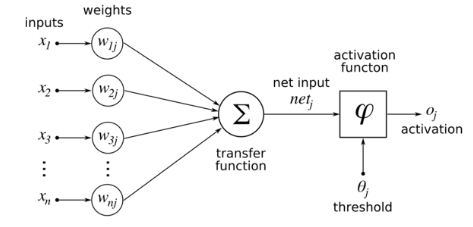

Em weights fará um produto matricial.

**Bias** (*b)*: coisa que soma, mas não depende da entrada. * valor a mais
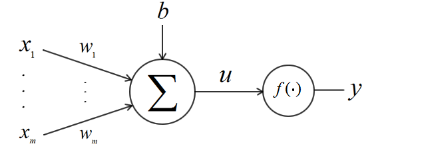

> Função linear: **A multiplicação dos inputs x weights + b** 

Em $\phi$ faz-se uma composição onde há uma função não linear **( função de  ativação - ignora uma parte e  foca na outra )**

Aplica-se essa função $\phi$ na função 

$\phi$ $(f(x)) = a \cdot x+  b $

**ReLU**: Função de ativação muito usada

> É o valor de x quando x>0 

> É 0 se x negativo

* linear por partes


In [1]:
import numpy as np

class Perceptron(object):

    def __init__(self, no_of_inputs):
        self.weights = np.zeros(no_of_inputs + 1)
           
    def predict(self, inputs):
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0] #
        if summation > 0:
          activation = summation
        else:
          activation = 0            
        return activation

# Rede Neural

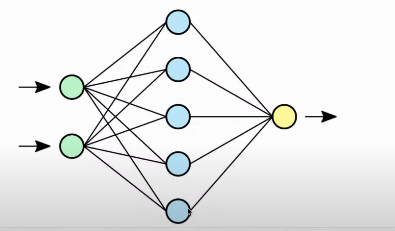

Percptrons são os de azul.

# Criando uma rede neural

Pytorch: biblioteca open source para criar redes neurais que permite tanto o uso da CPU quanto da GPU para o treinamento do modelo.

In [2]:
!pip install -q torch==1.10.0 torchvision

In [3]:
import torch
print(torch.__version__)

1.10.0+cu111


In [4]:
import torch
import numpy as np
from torch import nn

Construindo uma rede neural simples

In [5]:
# Classe que representa NN
class LineNetwork(nn.Module): #criando uma classe que representa nossa nn 'Line Network' - #importante que herde de um módulo do pytorch
#módulo nn tem classe chamada model de onde todas as redes  deveriam derivar

  # Inicialização
  def __init__(self): #
    super().__init__() #iniciando classe base
    self.layers = nn.Sequential( #criação de camadas
        nn.Linear(1, 1)
    )

  # Como a rede computa
  def forward(self, x):
    return self.layers(x)
  

# Criando um Data Set

In [6]:
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand #pontos aleatorios

In [7]:
# Amostrando conjunto de dados
class AlgebraicDataset(Dataset):
  def __init__(self, f, interval, nsamples):
    X = urand.Uniform(interval[0], interval[1]).sample([nsamples])
    self.data = [(x, f(x)) for x in X] #

  def __len__(self):#qtd de dados no data set 
    return len(self.data)

  def __getitem__(self, idx): #como buscar um dado em determinado índice
    return self.data[idx]   

# Preparando treinamento



In [8]:
line = lambda x: 2*x + 3
interval = (-10, 10)
train_nsamples = 1000 #amostras
test_nsamples = 100

In [9]:
train_dataset = AlgebraicDataset(line, interval, train_nsamples)
test_dataset = AlgebraicDataset(line, interval, test_nsamples)

train_dataloader = DataLoader(train_dataset, batch_size=train_nsamples, shuffle=True) #olhando parte do conjunto de dados
test_dataloader = DataLoader(test_dataset, batch_size=test_nsamples, shuffle=True) #embaralhar e passa

## Hiperparâmetros de Otimização

w: parâmetro que vai sendo ajustado  até o ideal

> Como saber se estou acertando ou errando: necessita-se de uma função de perda!

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cuda


In [11]:
model = LineNetwork().to(device)

In [12]:
# Função de perda (loss function)
# Erro quadrático médio (Mean Squared Error)
lossfunc = nn.MSELoss()
# Gradiente Descendente Estocástico
# SGD = Stochastic Gradient Descent - tem  algum ruído: estocástico
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# taxa de aprendizado lr = learning rate  - velocidade (passo)

> Gradient descent: otimizador
* derivada em altas dimensões - andar no sentido contrário do crescimento
* indica direção para onde funçãp está crescendo

In [13]:
def train(model, dataloader, lossfunc, optimizer):
  model.train() #garantir que modelo está preparado para treinar
  cumloss = 0.0
  for X, y in dataloader:
    X = X.unsqueeze(1).float().to(device) #pytorch máximo 32
    y = y.unsqueeze(1).float().to(device)

    pred = model(X)
    loss = lossfunc(pred, y)

    # zera os gradientes acumulados
    optimizer.zero_grad()
    # computa os gradientes
    loss.backward() #backpropagation
    # anda, de fato, na direção que reduz o erro local
    optimizer.step()

    # loss é um tensor; item pra obter o float
    cumloss += loss.item() 
  
  return cumloss / len(dataloader)


def test(model, dataloader, lossfunc):
  model.eval() #avaliar
  
  cumloss = 0.0
  with torch.no_grad():
    for X, y in dataloader:
      X = X.unsqueeze(1).float().to(device)
      y = y.unsqueeze(1).float().to(device)

      pred = model(X)
      loss = lossfunc(pred, y)
      cumloss += loss.item() 
  
  return cumloss / len(dataloader) 

## Treinando a rede de fato

In [14]:
import matplotlib.pyplot as plt

In [15]:
# Pra visualizar
def plot_comparinson(f, model, interval=(-10, 10), nsamples=10):
  fig, ax = plt.subplots(figsize=(10, 10))

  ax.grid(True, which='both')
  ax.spines['left'].set_position('zero')
  ax.spines['right'].set_color('none')
  ax.spines['bottom'].set_position('zero')
  ax.spines['top'].set_color('none')

  samples = np.linspace(interval[0], interval[1], nsamples)
  model.eval()
  with torch.no_grad():
    pred = model(torch.tensor(samples).unsqueeze(1).float().to(device))

  ax.plot(samples, list(map(f, samples)), "o", label="ground truth")
  ax.plot(samples, pred.cpu(), label="model")
  plt.legend()
  plt.show()

Epoch: 0; Train Loss: 48.85734939575195


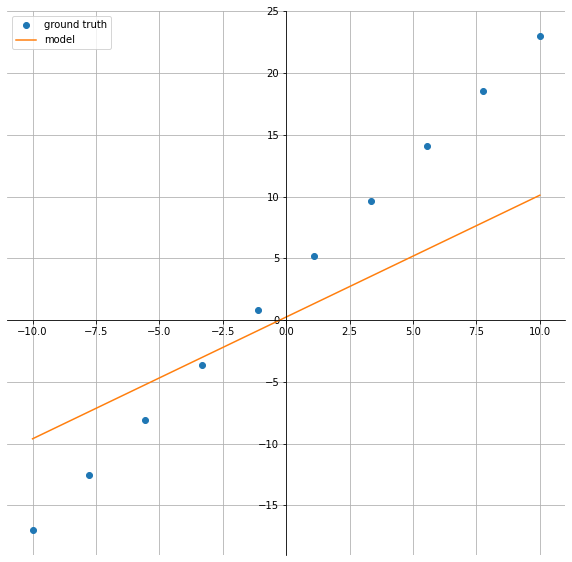

Epoch: 10; Train Loss: 17.38465118408203


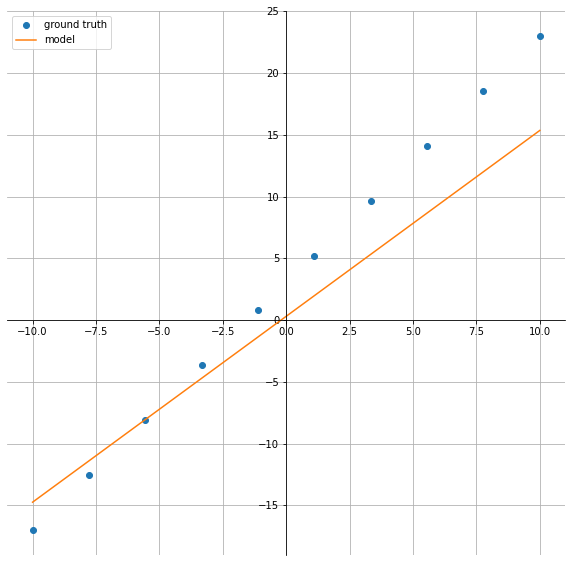

Epoch: 20; Train Loss: 9.465672492980957


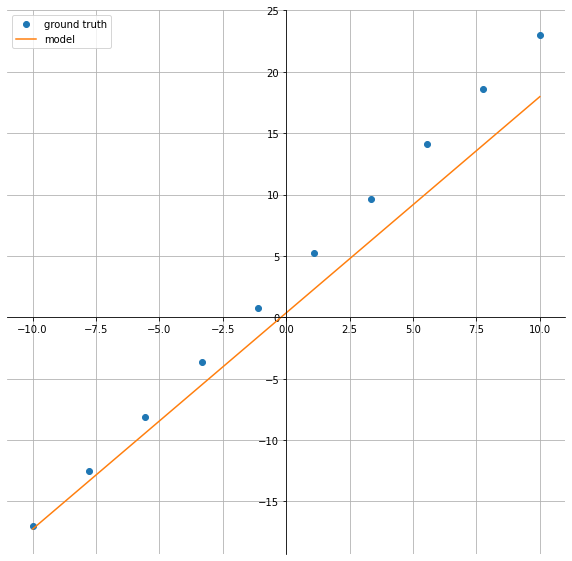

Epoch: 30; Train Loss: 7.322359561920166


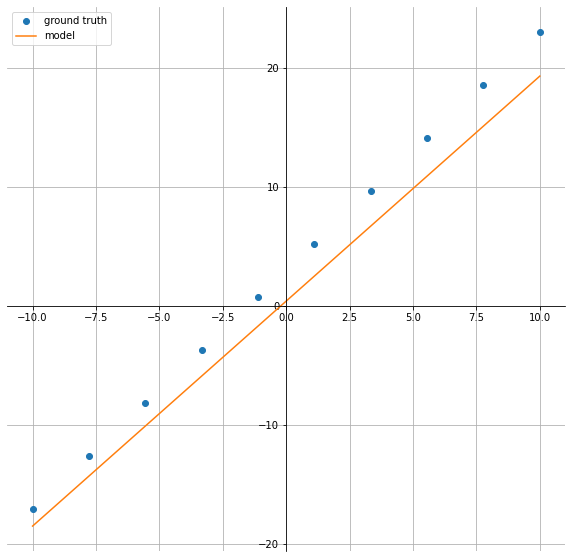

Epoch: 40; Train Loss: 6.60127592086792


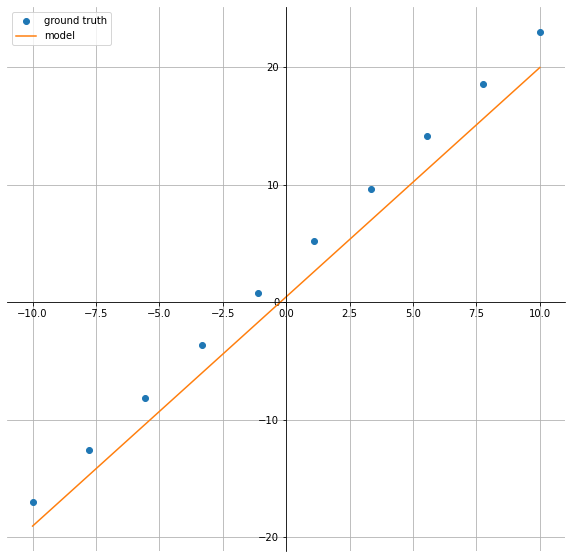

Epoch: 50; Train Loss: 6.2361345291137695


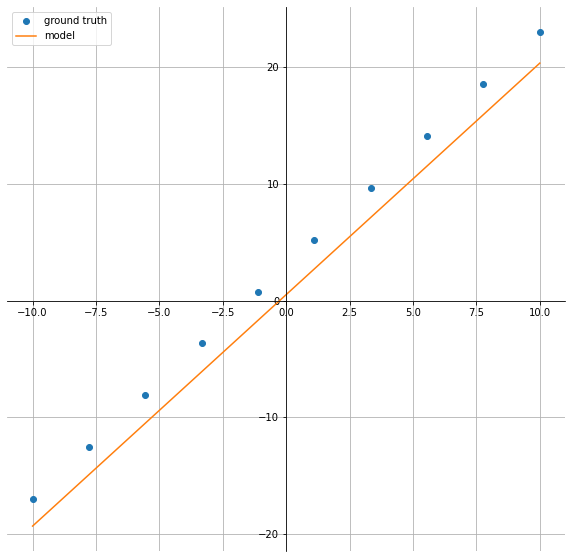

Epoch: 60; Train Loss: 5.9655442237854


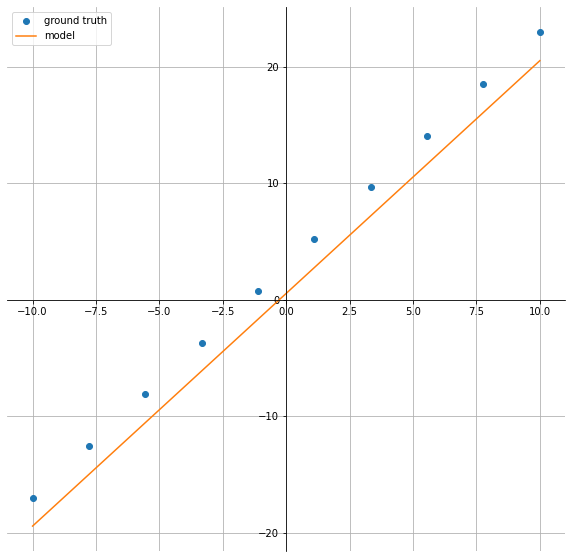

Epoch: 70; Train Loss: 5.7252116203308105


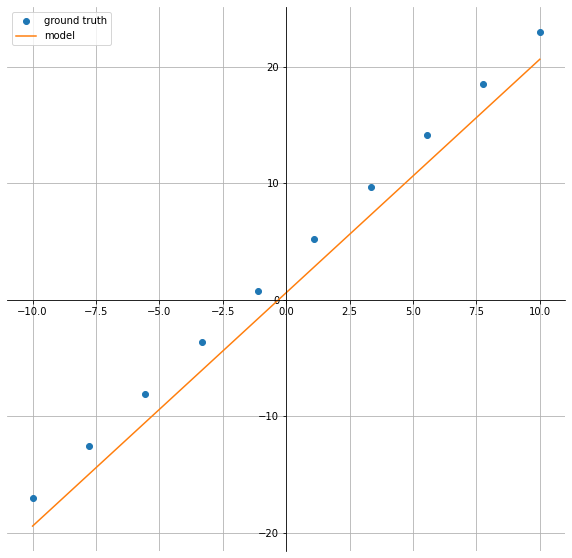

Epoch: 80; Train Loss: 5.499114513397217


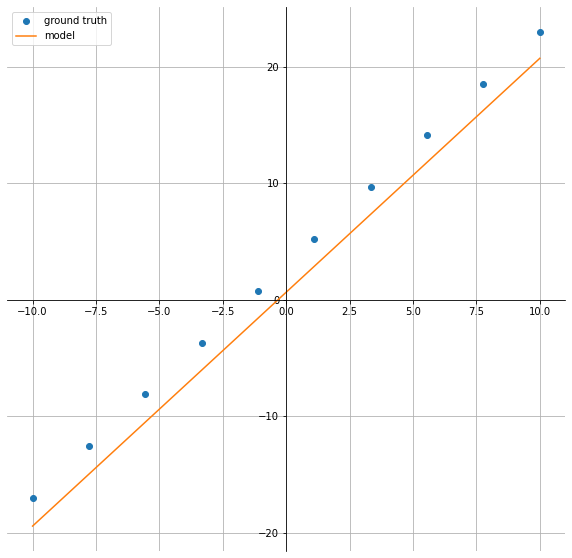

Epoch: 90; Train Loss: 5.283062934875488


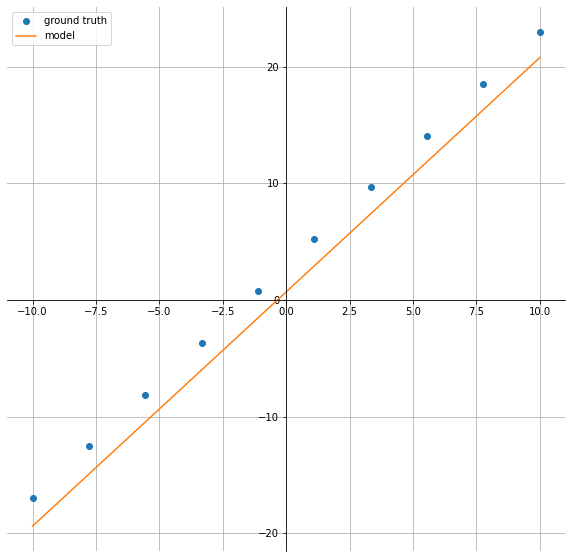

Epoch: 100; Train Loss: 5.075772762298584


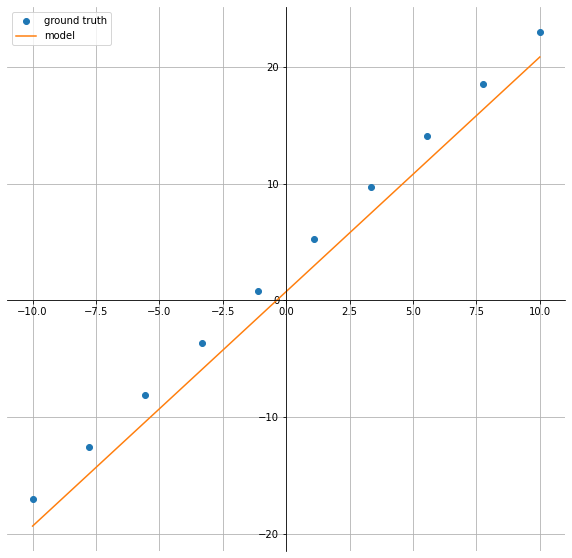

Epoch: 110; Train Loss: 4.876683235168457


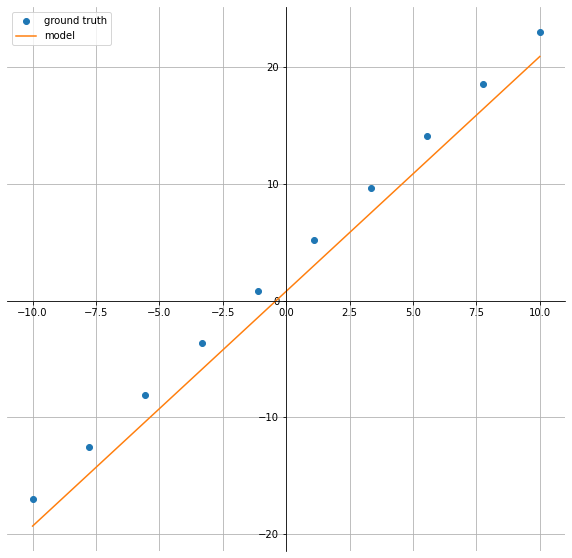

Epoch: 120; Train Loss: 4.685418605804443


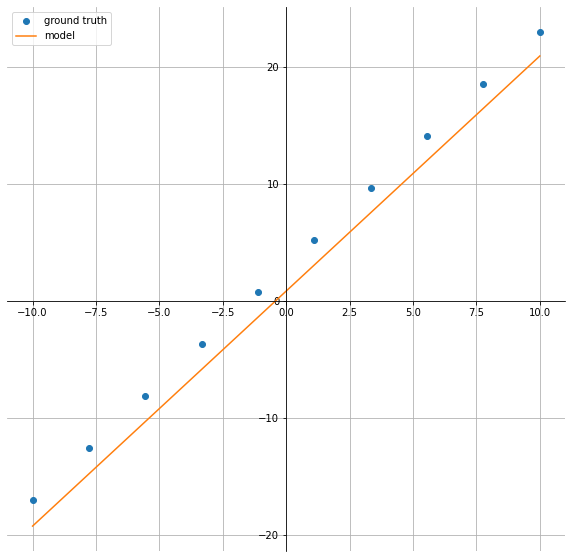

Epoch: 130; Train Loss: 4.501659870147705


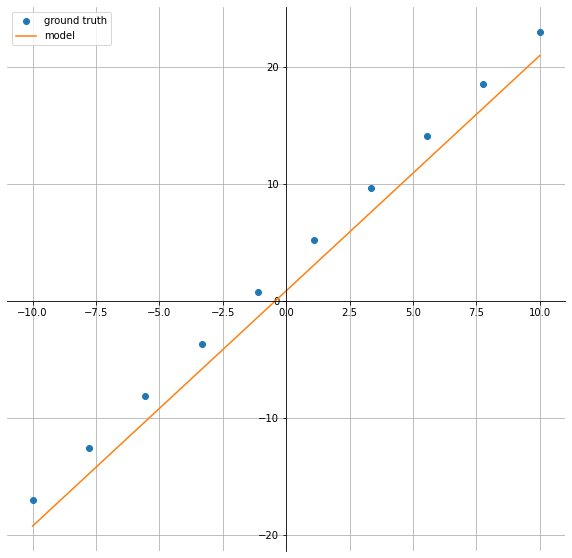

Epoch: 140; Train Loss: 4.325108528137207


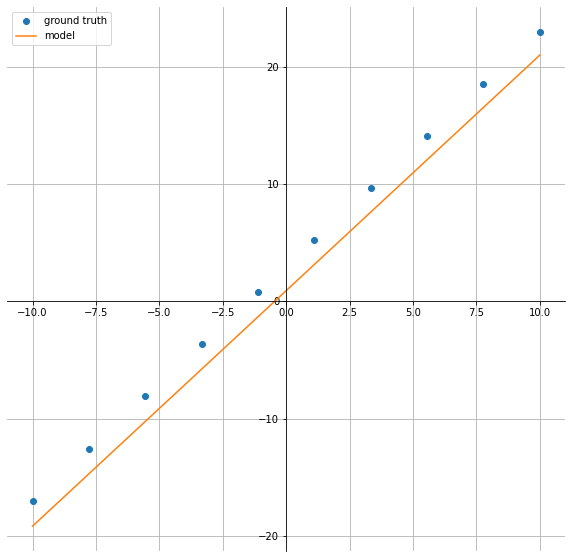

Epoch: 150; Train Loss: 4.155481815338135


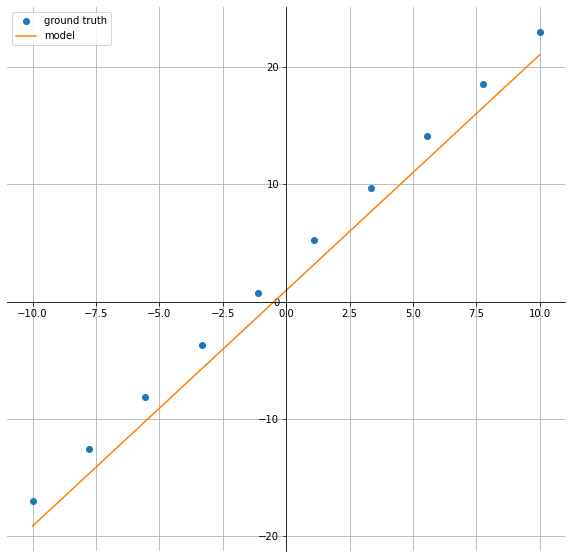

Epoch: 160; Train Loss: 3.9925079345703125


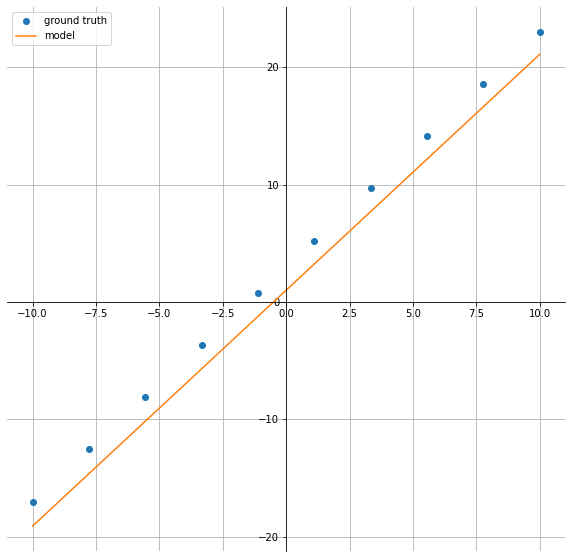

Epoch: 170; Train Loss: 3.8359251022338867


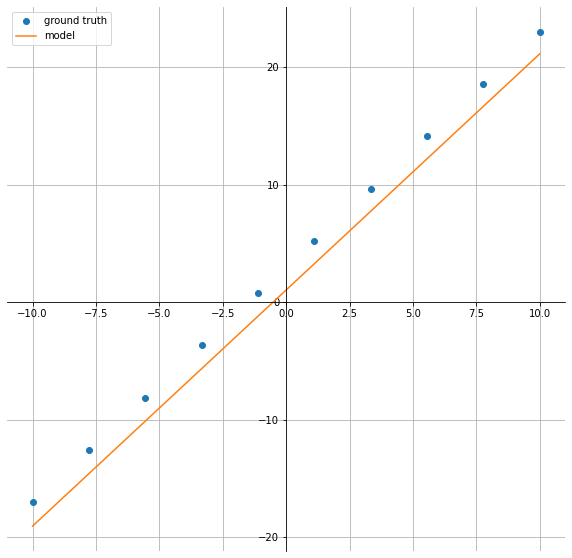

Epoch: 180; Train Loss: 3.685483932495117


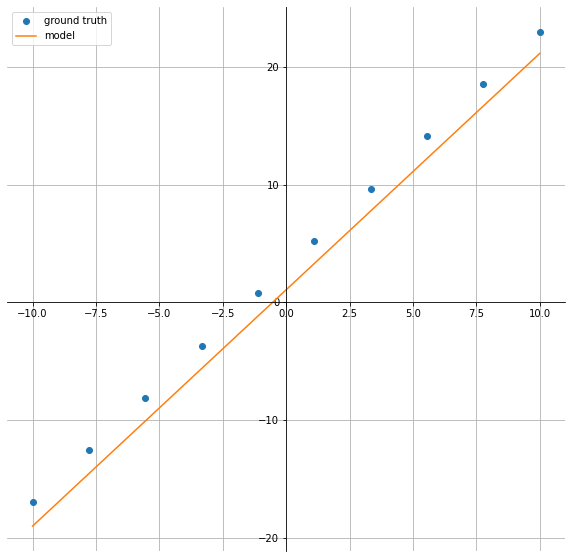

Epoch: 190; Train Loss: 3.540942668914795


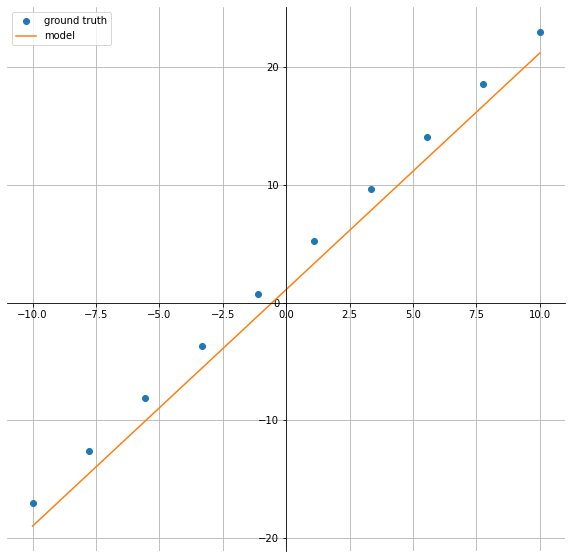

Epoch: 200; Train Loss: 3.402069091796875


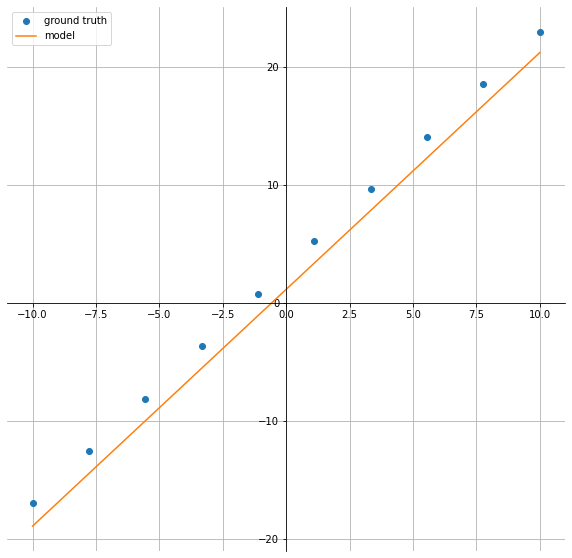

Test Loss: 3.3953347206115723


In [16]:
epochs = 201
for t in range(epochs):
  train_loss = train(model, train_dataloader, lossfunc, optimizer)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
    plot_comparinson(line, model)

test_loss = test(model, test_dataloader, lossfunc)
print(f"Test Loss: {test_loss}")

* gráfico para ver resultado da função de perda com aumento de epochs

Overfitting: mais suave, não passar exatamente por cima.

Outro exemplo

In [17]:
class MultiLayerNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(1, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 8),
        nn.ReLU(),
        nn.Linear(8, 1),
    )

  def forward(self, x):
    return self.layers(x)

In [18]:
multimodel = MultiLayerNetwork().to(device)

In [19]:
from math import cos

In [20]:
f = lambda x: cos(x/2)

In [21]:
train_dataset = AlgebraicDataset(f, interval, train_nsamples)
test_dataset = AlgebraicDataset(f, interval, test_nsamples)

train_dataloader = DataLoader(train_dataset, train_nsamples, shuffle=True)
test_dataloader = DataLoader(test_dataset, test_nsamples, shuffle=True)

In [22]:
lossfunc = nn.MSELoss()
optimizer = torch.optim.SGD(multimodel.parameters(), lr=1e-3)

Epoch: 0; Train Loss: 0.5244349837303162


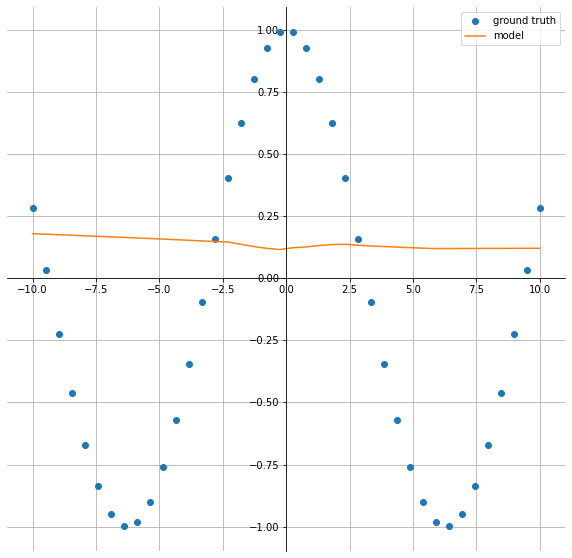

Epoch: 100; Train Loss: 0.41941988468170166


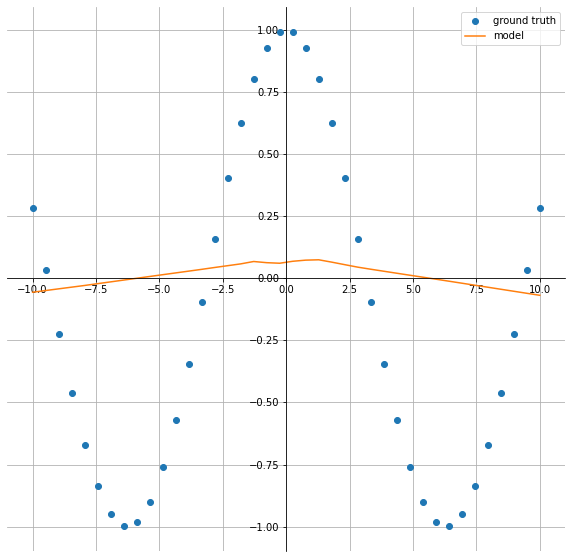

Epoch: 200; Train Loss: 0.3525869846343994


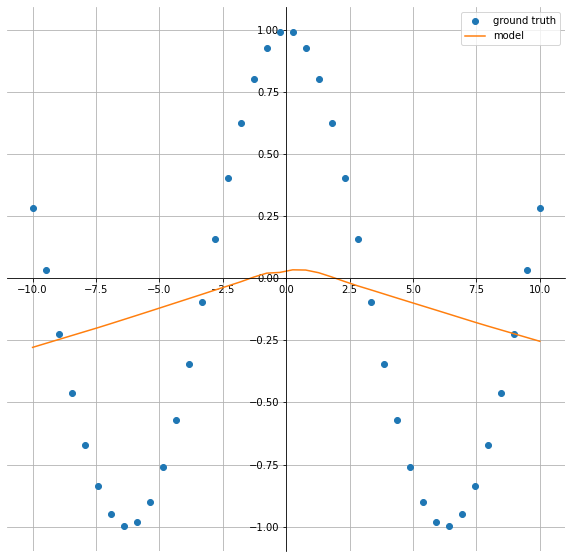

Epoch: 300; Train Loss: 0.31857386231422424


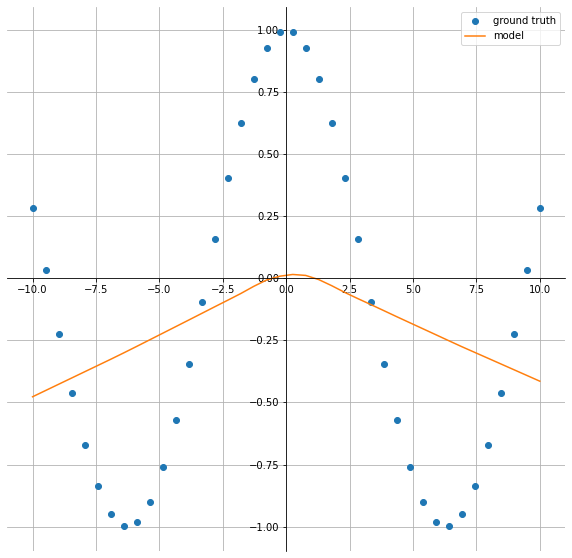

Epoch: 400; Train Loss: 0.3059721887111664


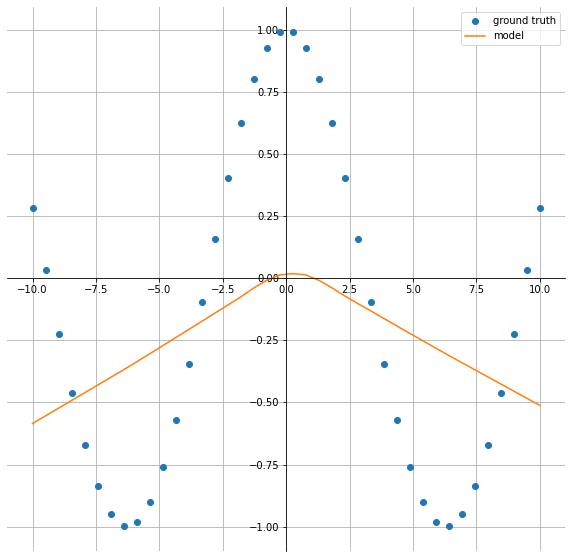

Epoch: 500; Train Loss: 0.2986598610877991


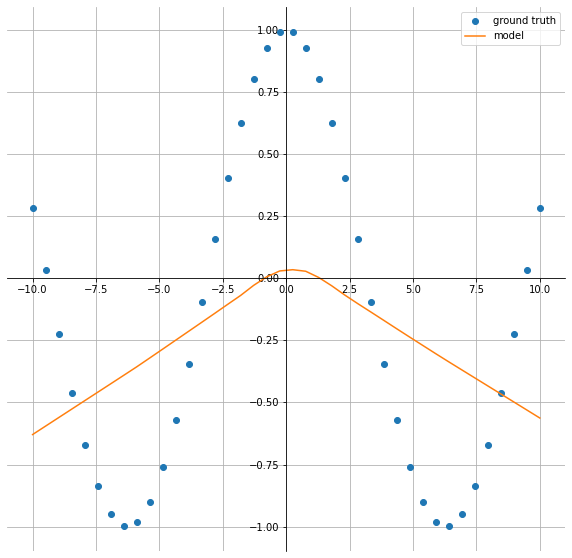

Epoch: 600; Train Loss: 0.2922735810279846


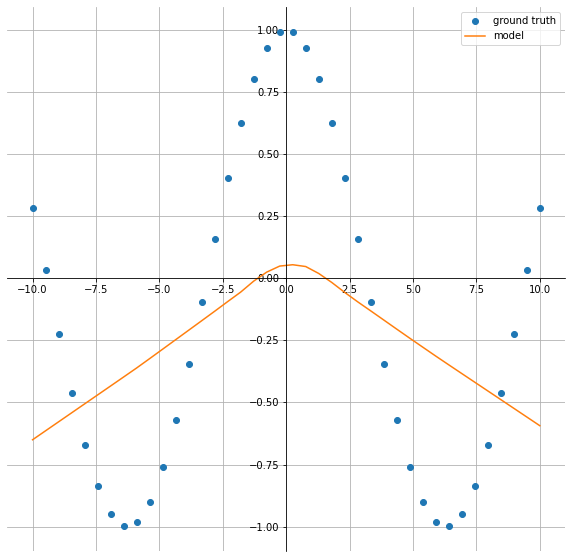

Epoch: 700; Train Loss: 0.2863005995750427


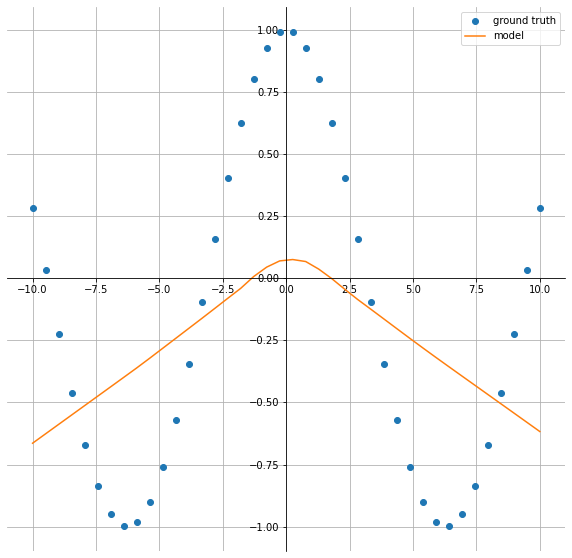

Epoch: 800; Train Loss: 0.280676007270813


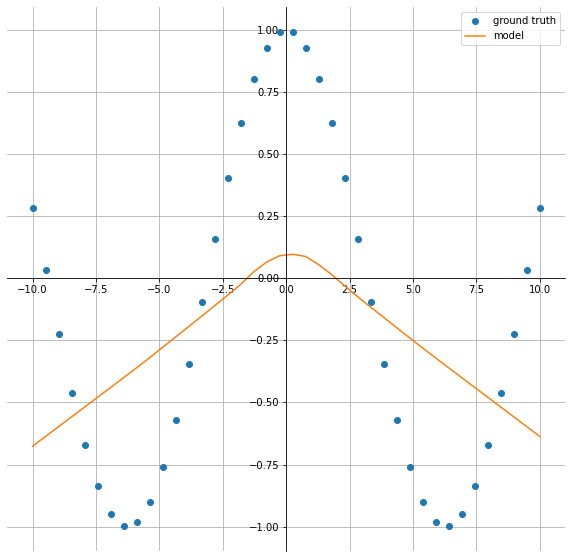

Epoch: 900; Train Loss: 0.27534595131874084


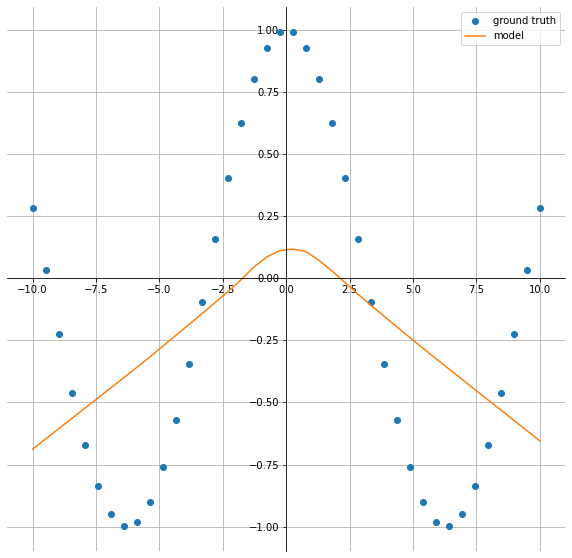

Epoch: 1000; Train Loss: 0.2702317535877228


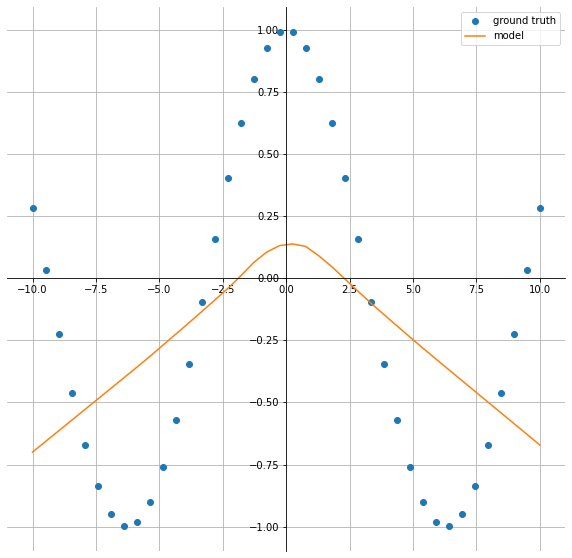

Epoch: 1100; Train Loss: 0.2653558552265167


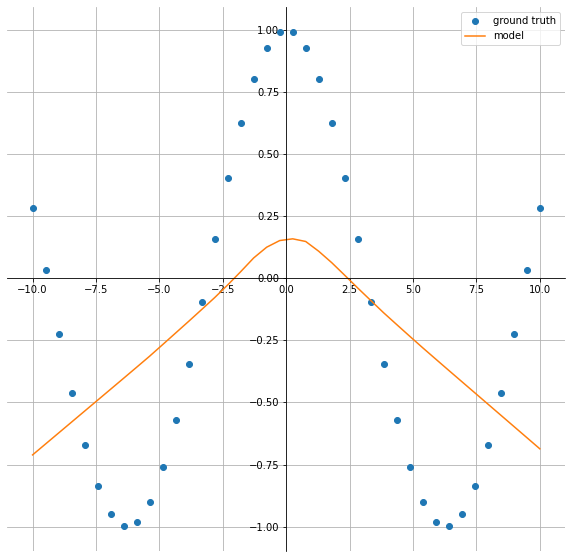

Epoch: 1200; Train Loss: 0.2605448067188263


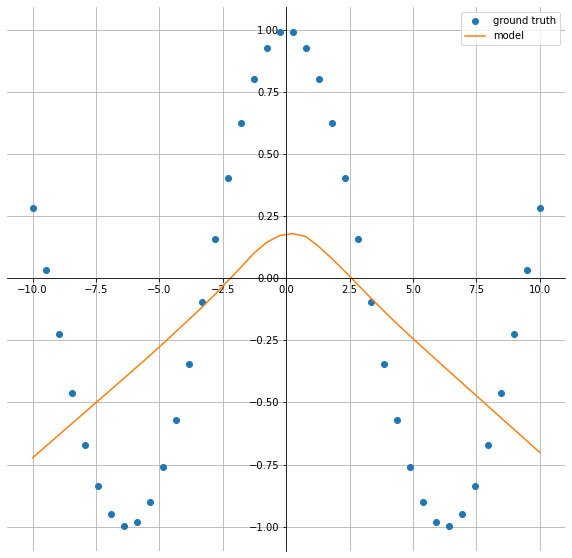

Epoch: 1300; Train Loss: 0.25609344244003296


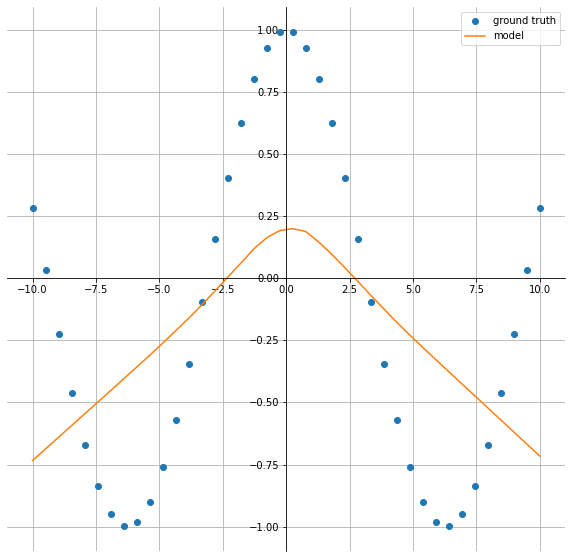

Epoch: 1400; Train Loss: 0.2520463764667511


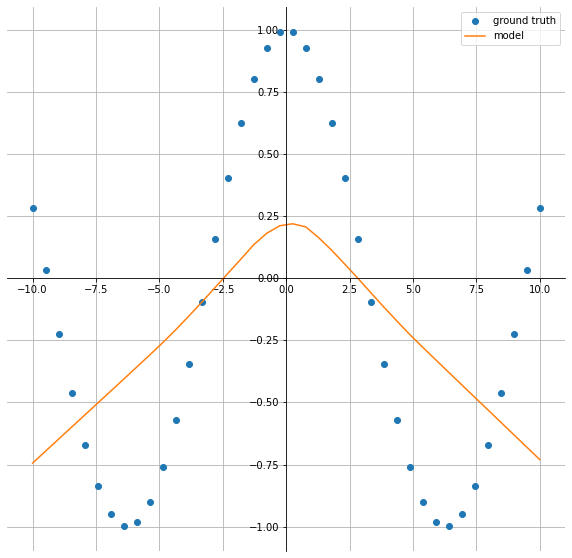

Epoch: 1500; Train Loss: 0.2485661804676056


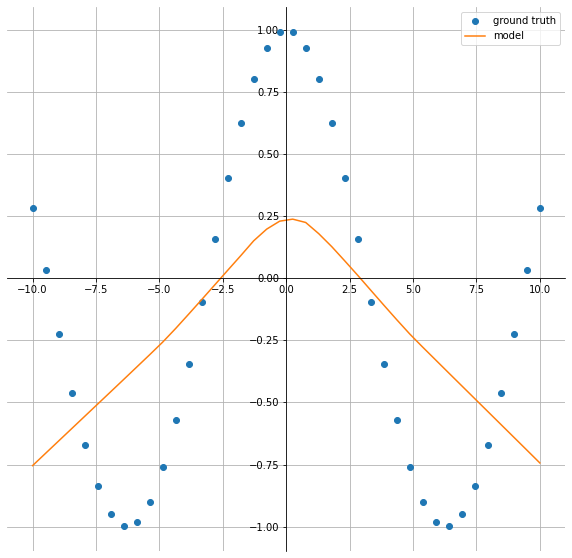

Epoch: 1600; Train Loss: 0.24552388489246368


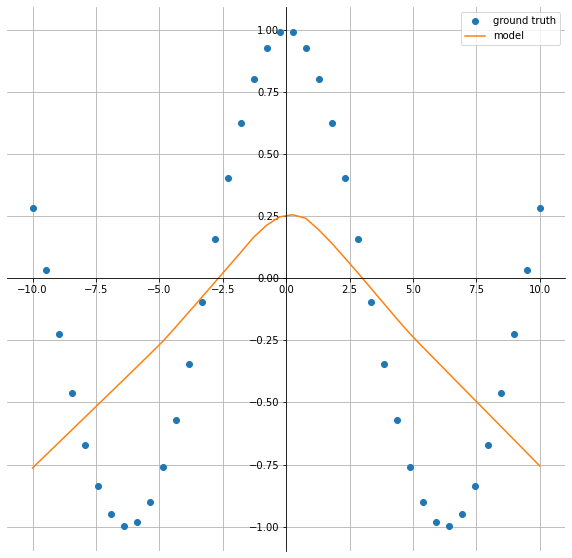

Epoch: 1700; Train Loss: 0.2427944391965866


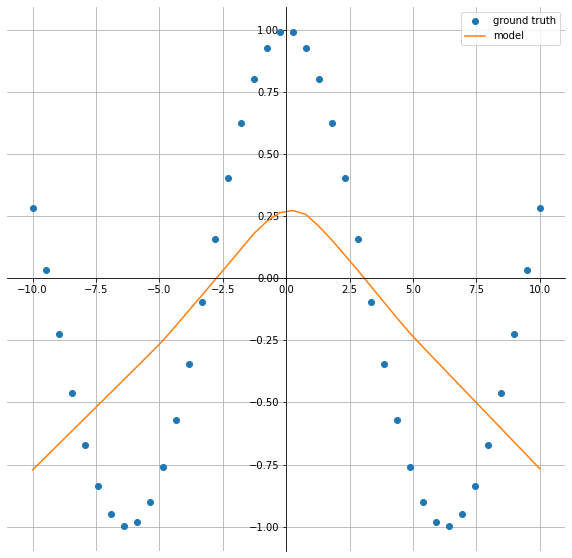

Epoch: 1800; Train Loss: 0.24029795825481415


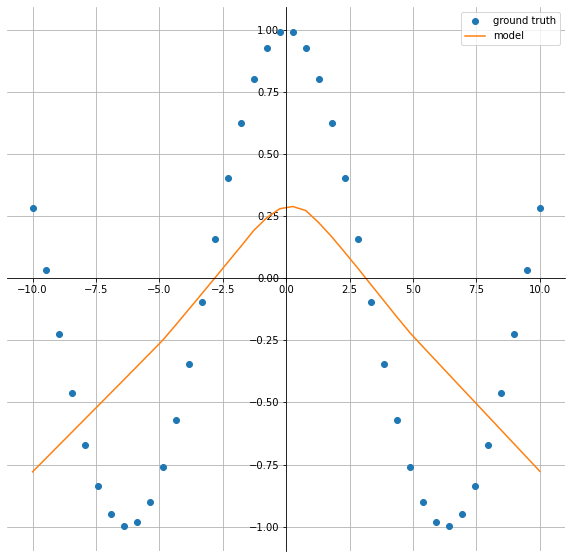

Epoch: 1900; Train Loss: 0.23730655014514923


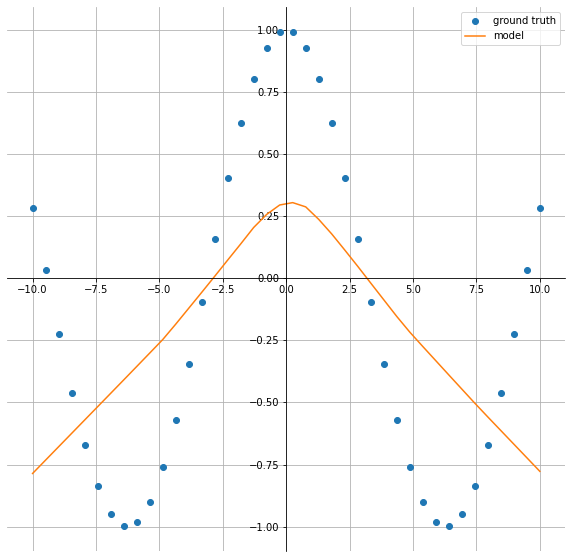

Epoch: 2000; Train Loss: 0.23429039120674133


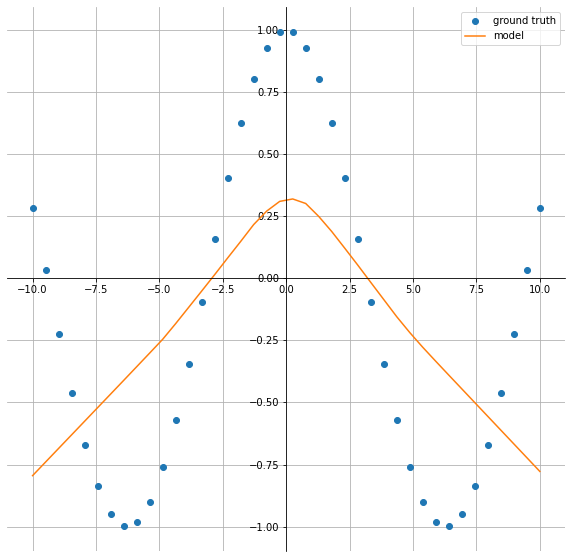

Epoch: 2100; Train Loss: 0.23217728734016418


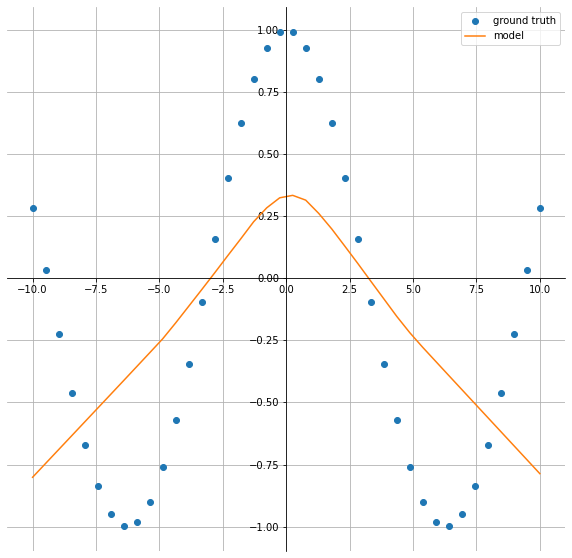

Epoch: 2200; Train Loss: 0.23023250699043274


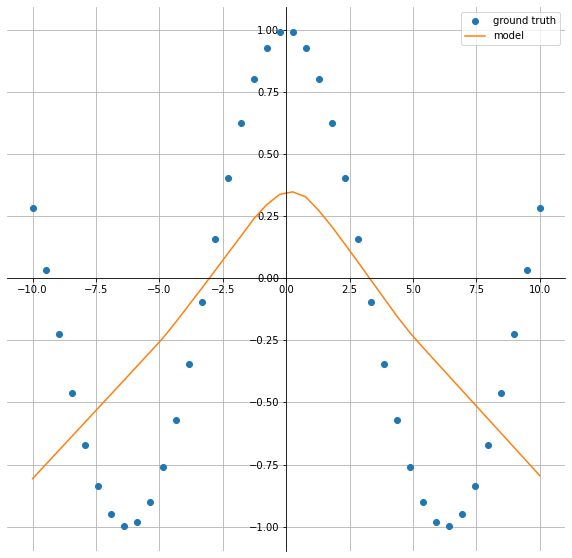

Epoch: 2300; Train Loss: 0.22848375141620636


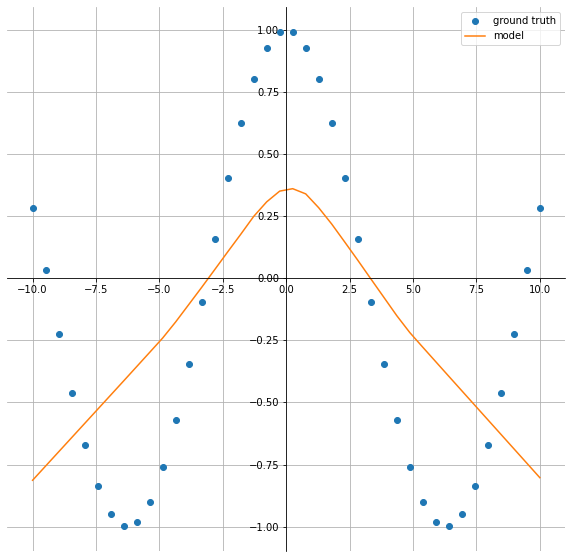

Epoch: 2400; Train Loss: 0.22689203917980194


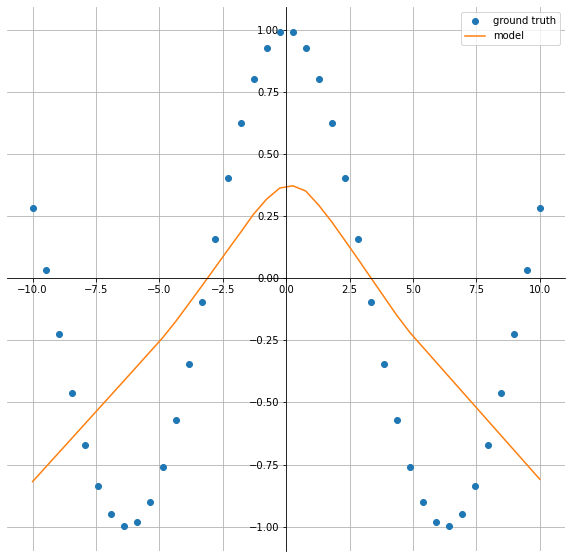

Epoch: 2500; Train Loss: 0.22541339695453644


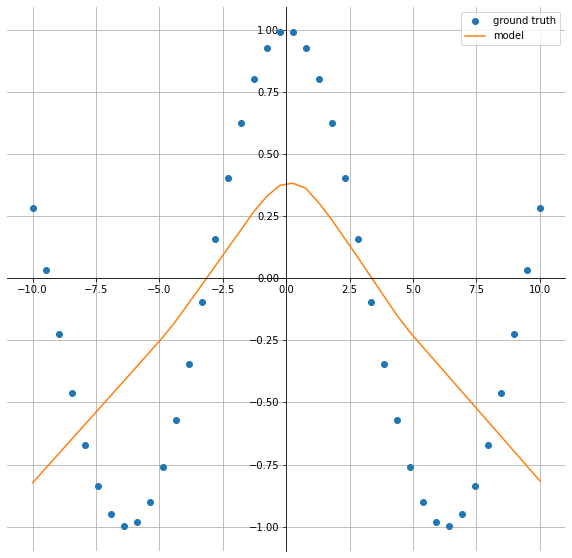

Epoch: 2600; Train Loss: 0.2240457981824875


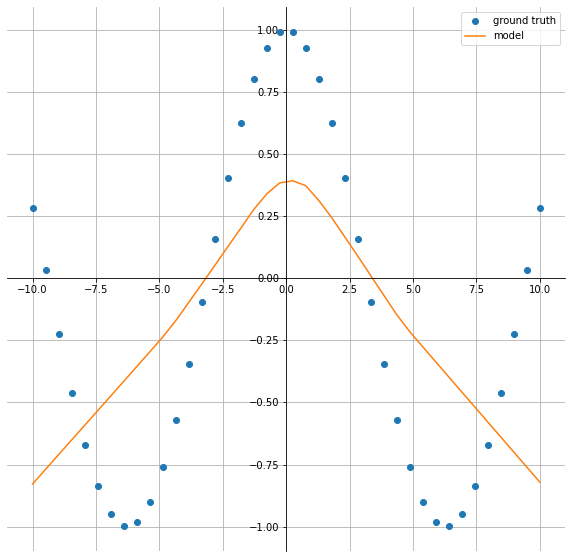

Epoch: 2700; Train Loss: 0.22276689112186432


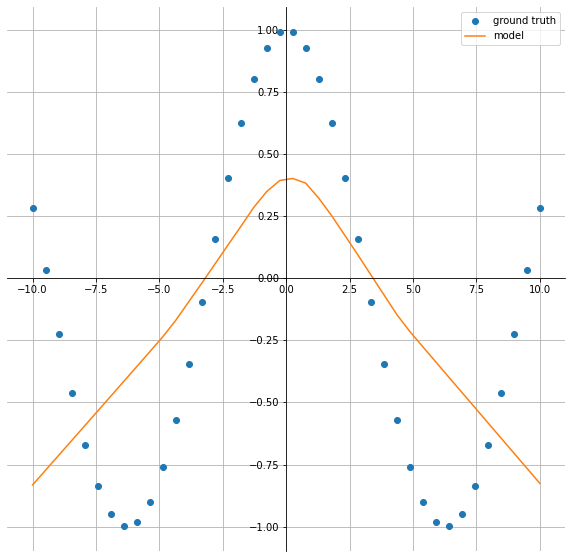

Epoch: 2800; Train Loss: 0.22155097126960754


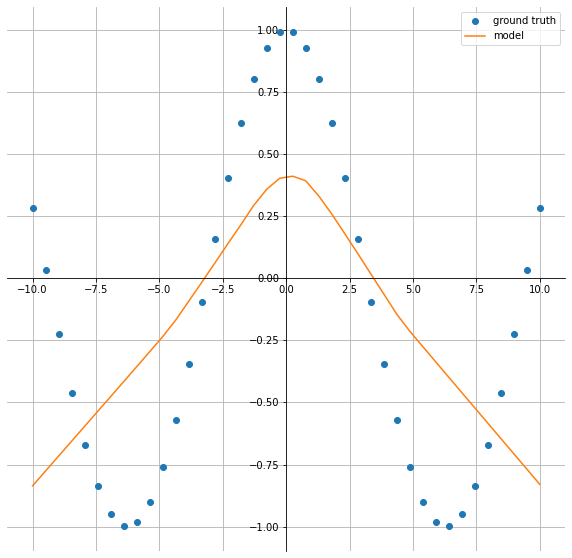

Epoch: 2900; Train Loss: 0.22038206458091736


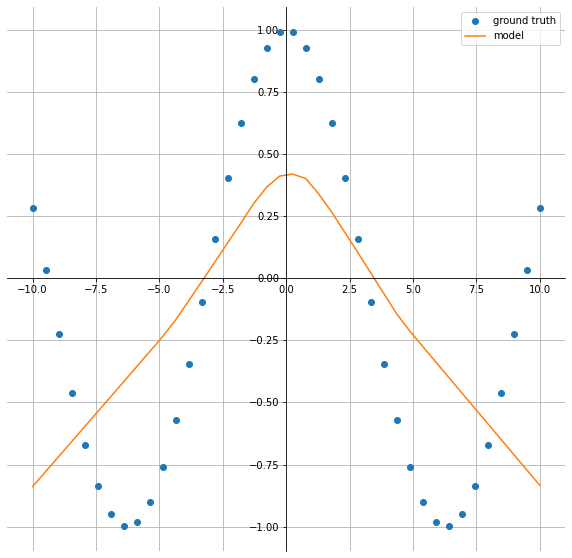

Epoch: 3000; Train Loss: 0.21924223005771637


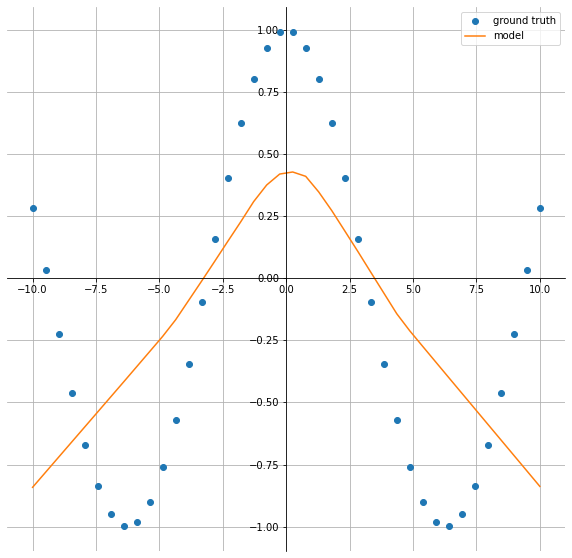

Epoch: 3100; Train Loss: 0.21811242401599884


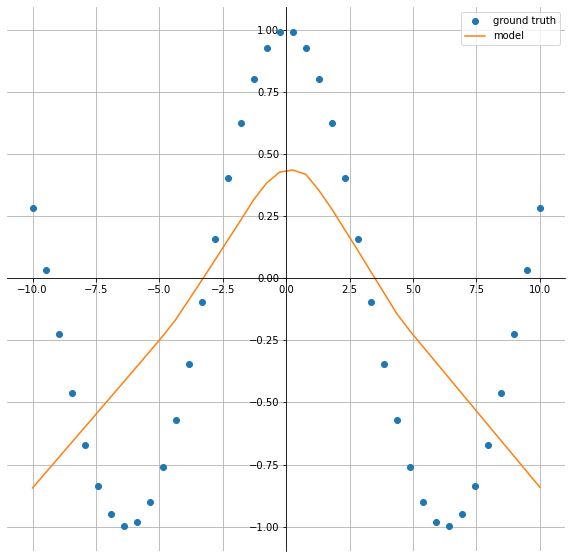

Epoch: 3200; Train Loss: 0.21699000895023346


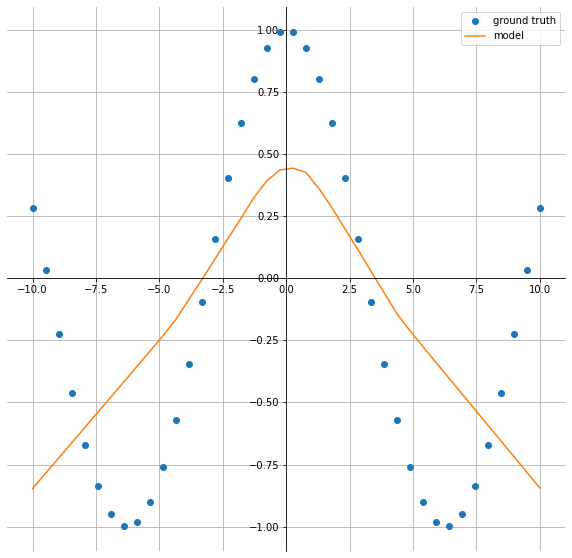

Epoch: 3300; Train Loss: 0.21590787172317505


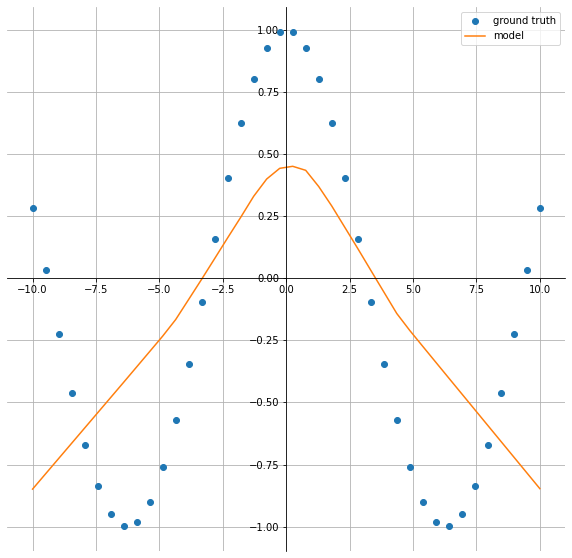

Epoch: 3400; Train Loss: 0.21487480401992798


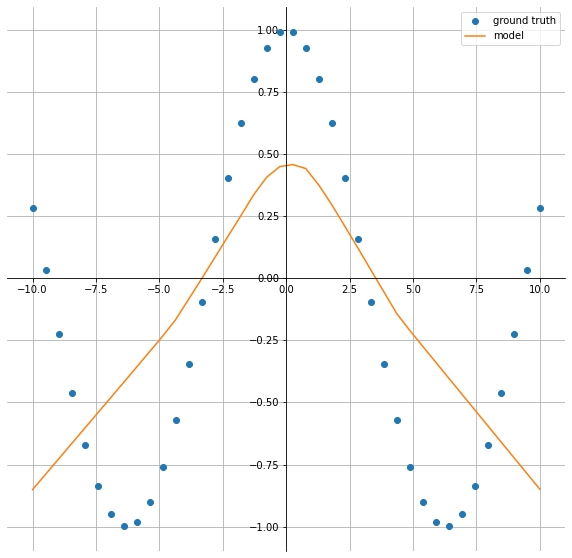

Epoch: 3500; Train Loss: 0.21385666728019714


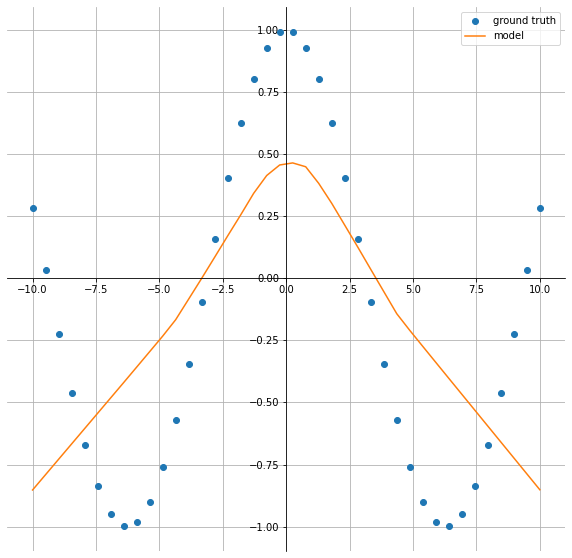

Epoch: 3600; Train Loss: 0.21284152567386627


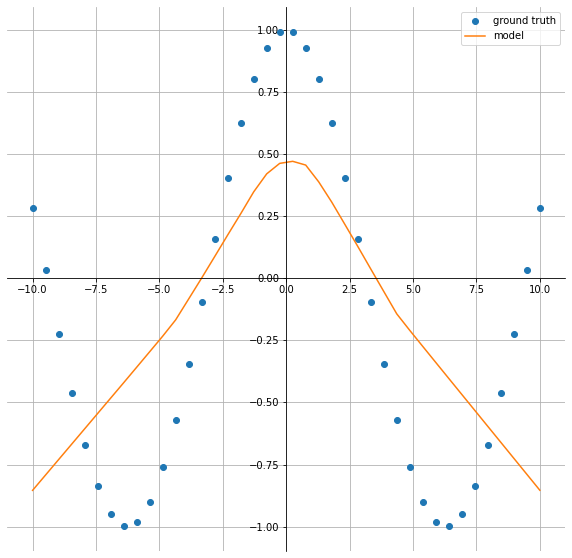

Epoch: 3700; Train Loss: 0.21182744204998016


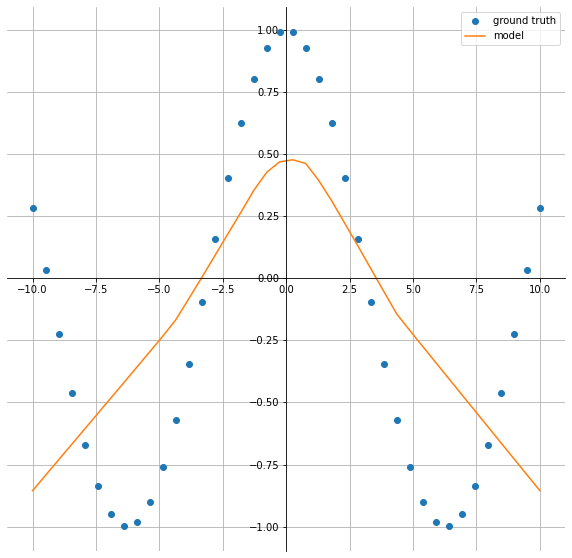

Epoch: 3800; Train Loss: 0.2108258157968521


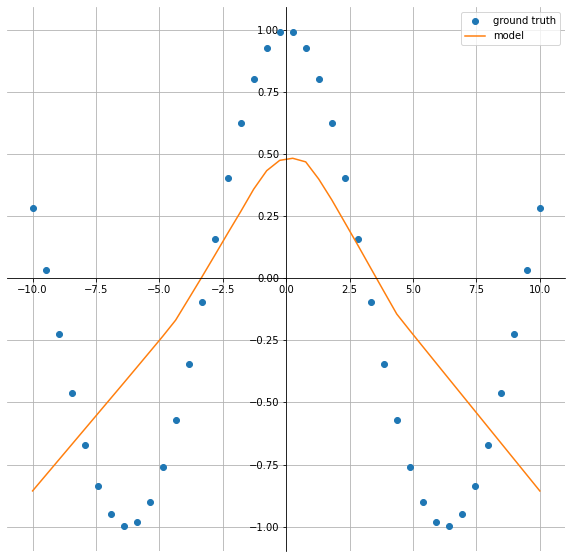

Epoch: 3900; Train Loss: 0.2098216712474823


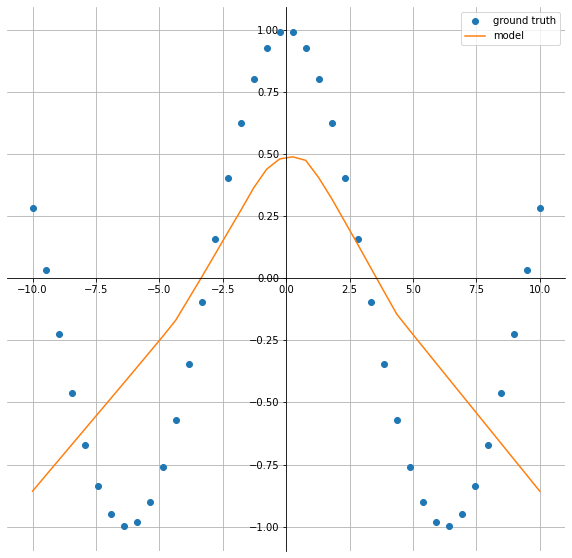

Epoch: 4000; Train Loss: 0.20881186425685883


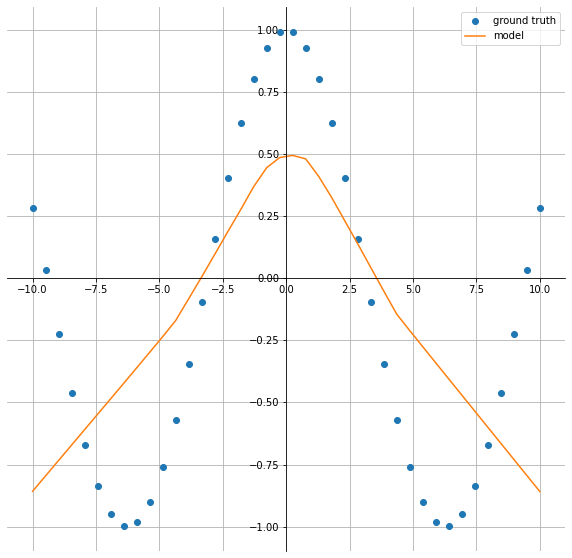

Epoch: 4100; Train Loss: 0.20779195427894592


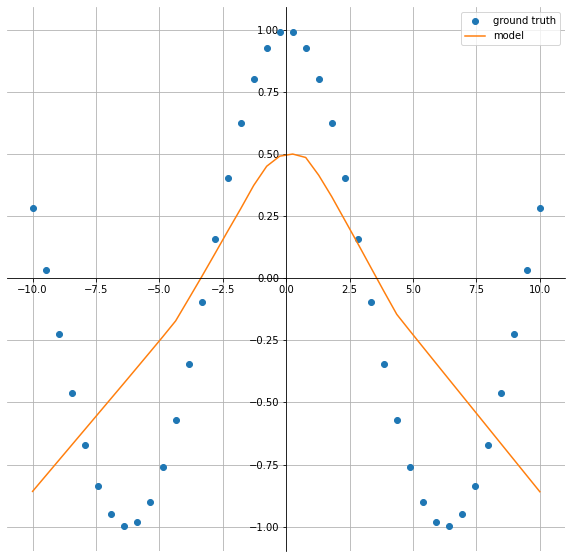

Epoch: 4200; Train Loss: 0.20676212012767792


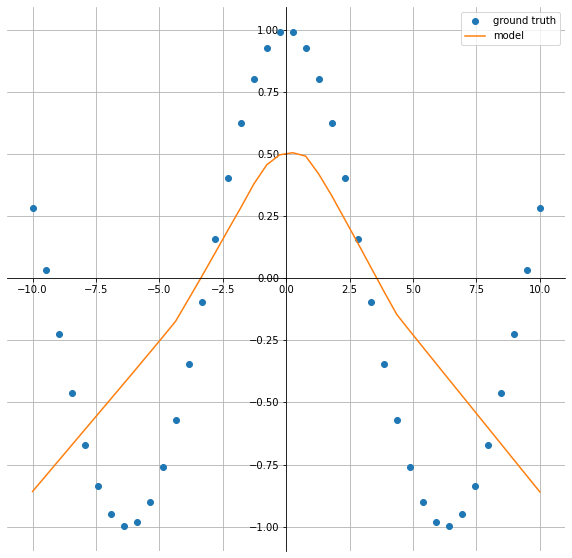

Epoch: 4300; Train Loss: 0.20571976900100708


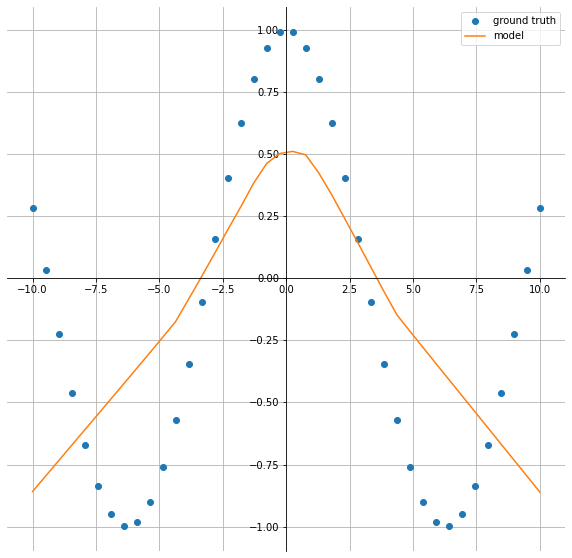

Epoch: 4400; Train Loss: 0.2046627551317215


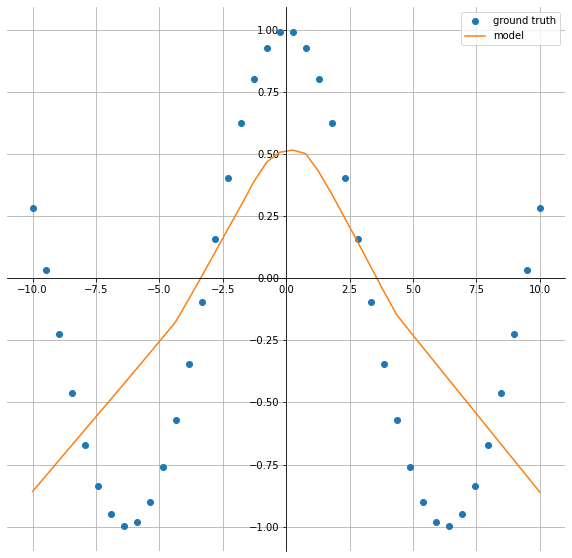

Epoch: 4500; Train Loss: 0.20358990132808685


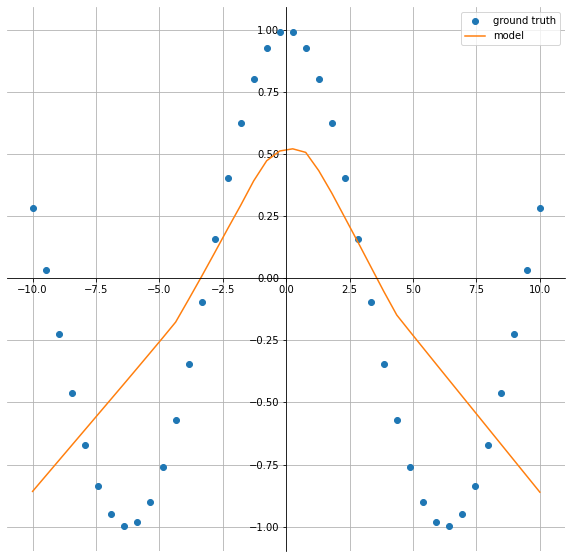

Epoch: 4600; Train Loss: 0.2024996131658554


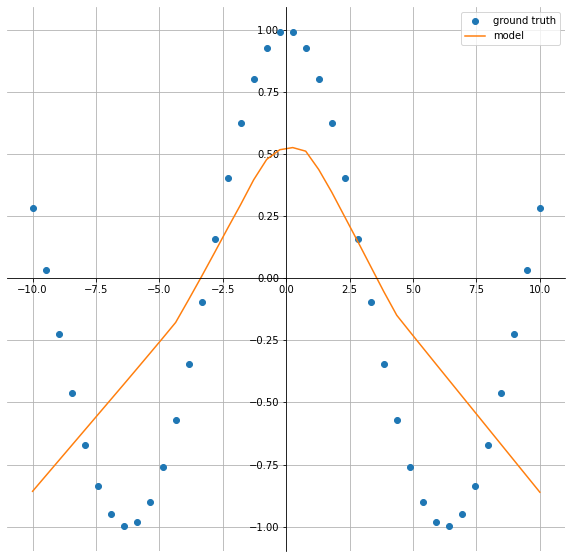

Epoch: 4700; Train Loss: 0.20139002799987793


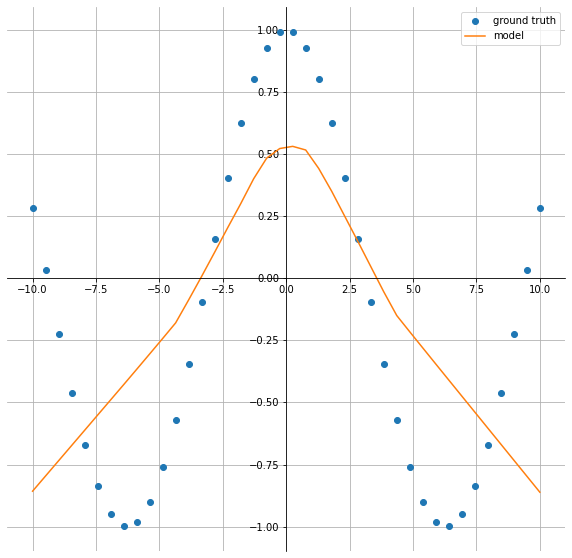

Epoch: 4800; Train Loss: 0.2002595067024231


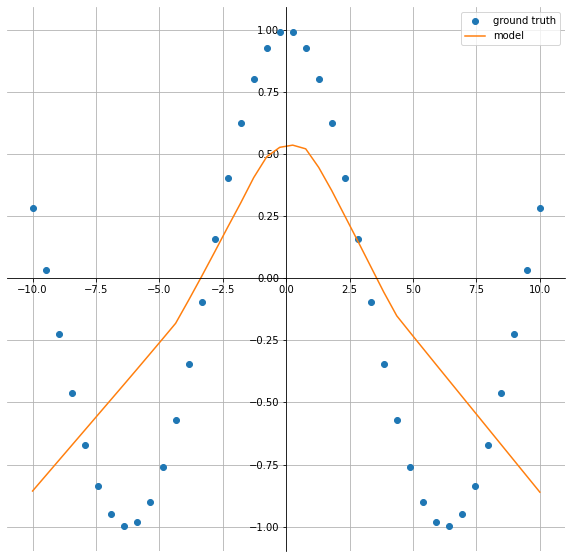

Epoch: 4900; Train Loss: 0.19910627603530884


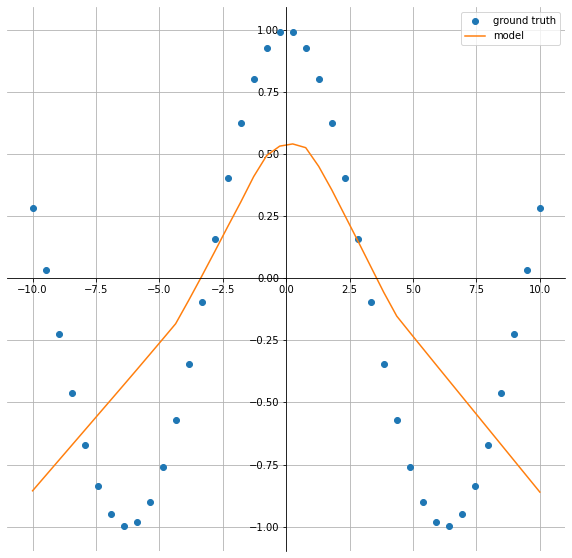

Epoch: 5000; Train Loss: 0.19793003797531128


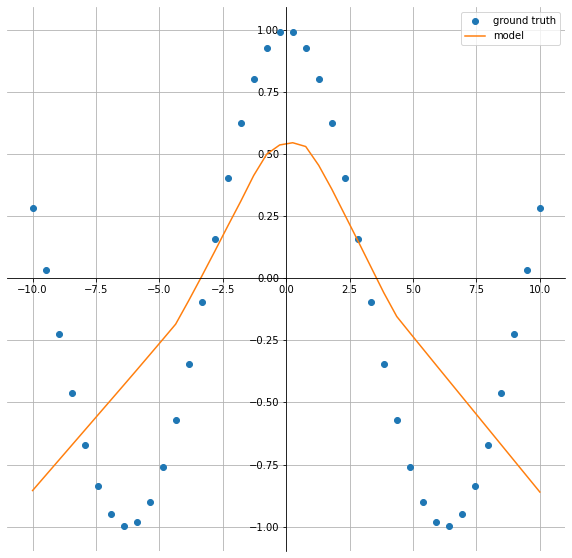

Epoch: 5100; Train Loss: 0.196730837225914


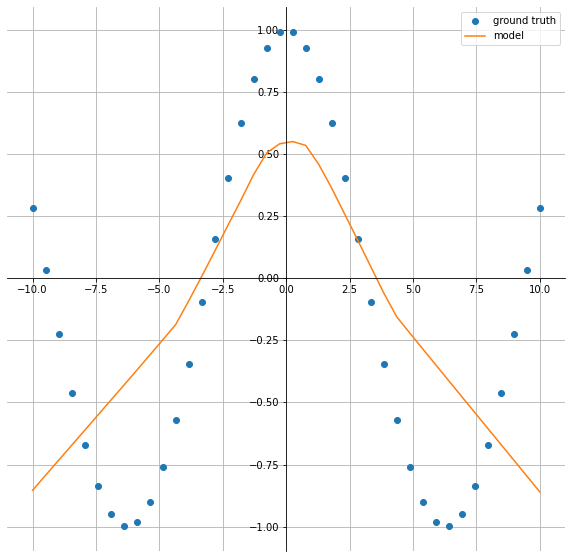

Epoch: 5200; Train Loss: 0.1955084204673767


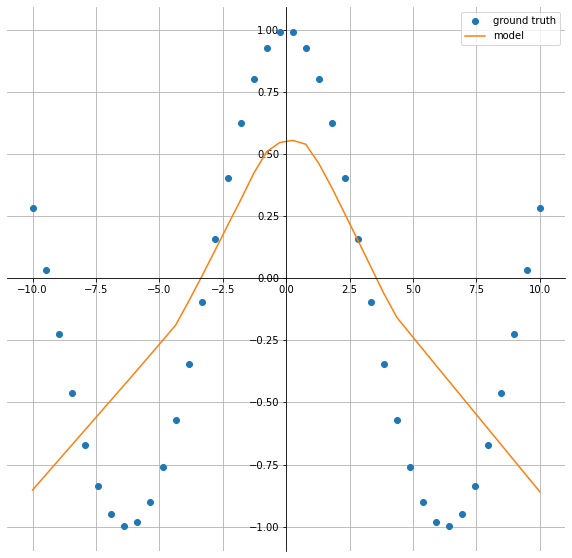

Epoch: 5300; Train Loss: 0.19426073133945465


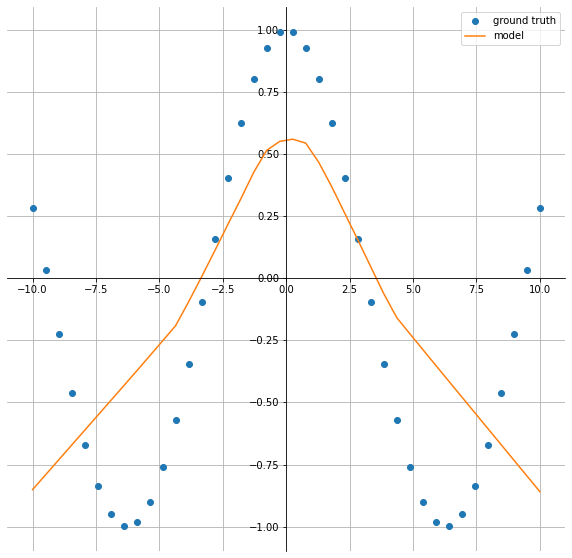

Epoch: 5400; Train Loss: 0.19298316538333893


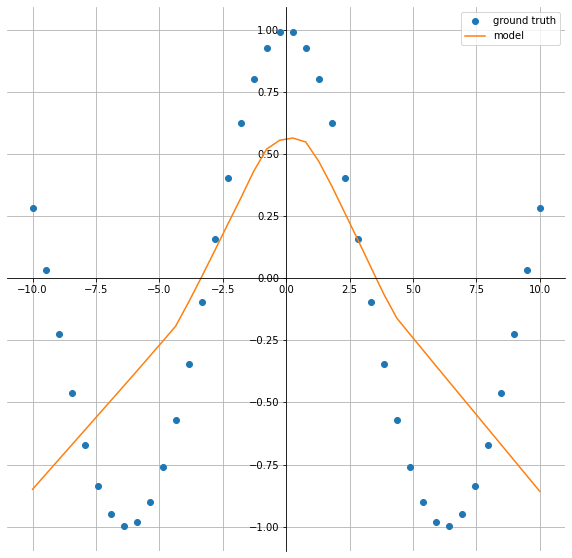

Epoch: 5500; Train Loss: 0.19167520105838776


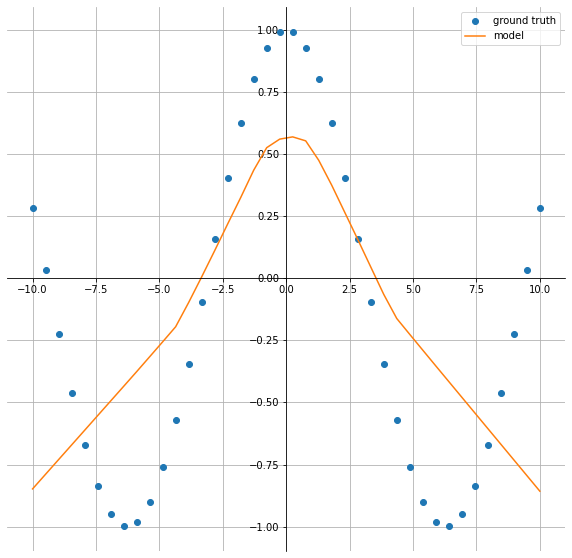

Epoch: 5600; Train Loss: 0.19033773243427277


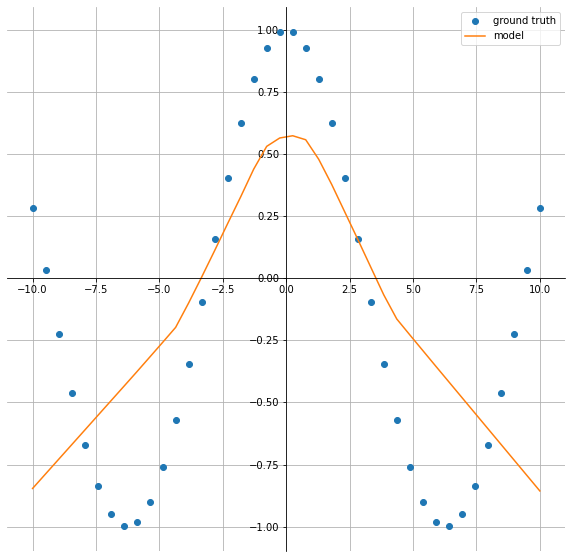

Epoch: 5700; Train Loss: 0.1889708787202835


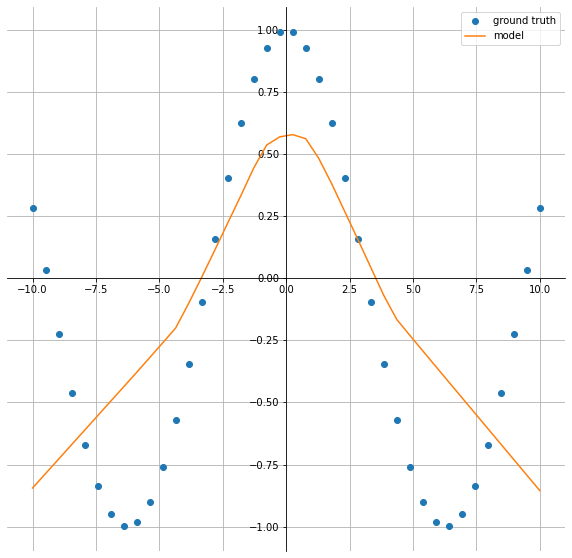

Epoch: 5800; Train Loss: 0.18757355213165283


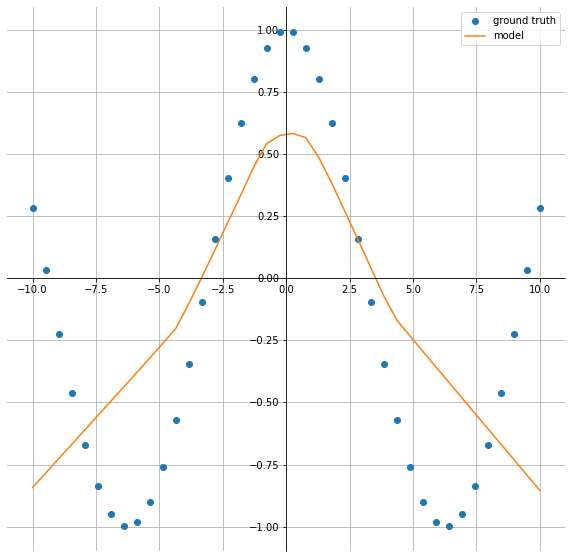

Epoch: 5900; Train Loss: 0.18614530563354492


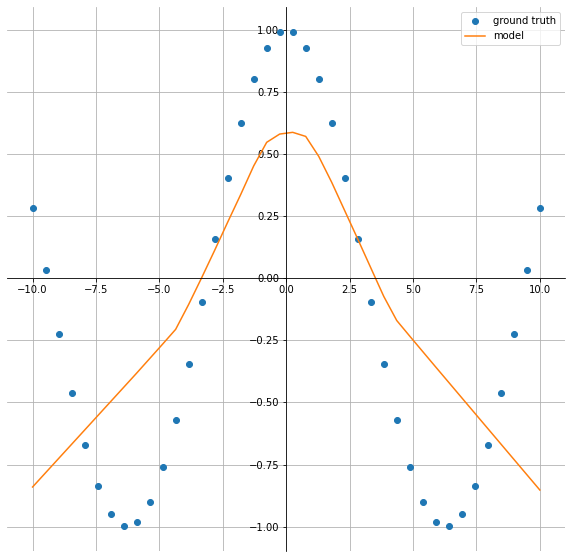

Epoch: 6000; Train Loss: 0.1846853792667389


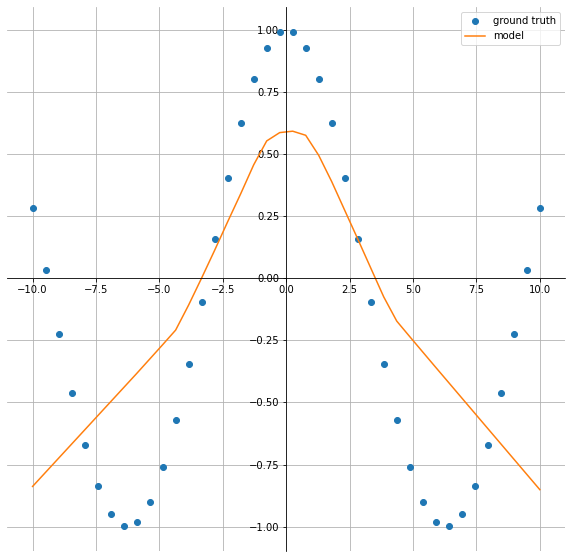

Epoch: 6100; Train Loss: 0.1831899732351303


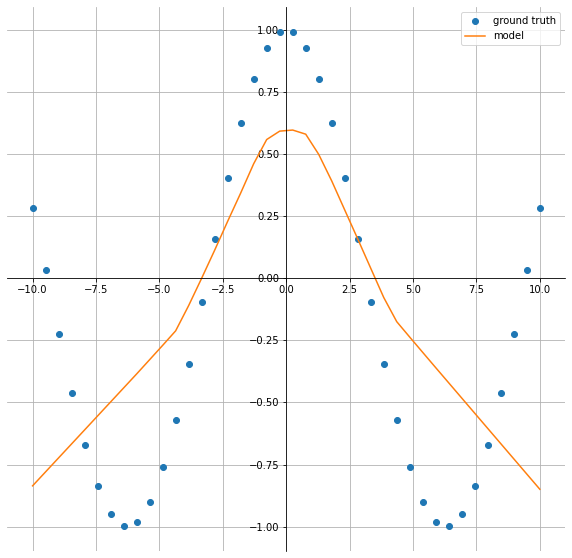

Epoch: 6200; Train Loss: 0.18165934085845947


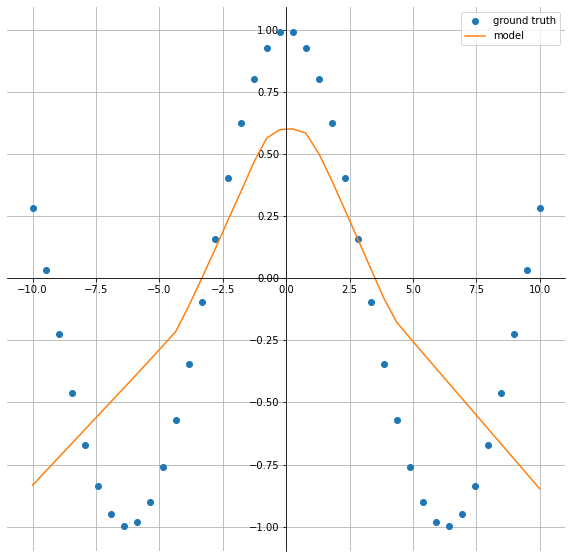

Epoch: 6300; Train Loss: 0.1800914704799652


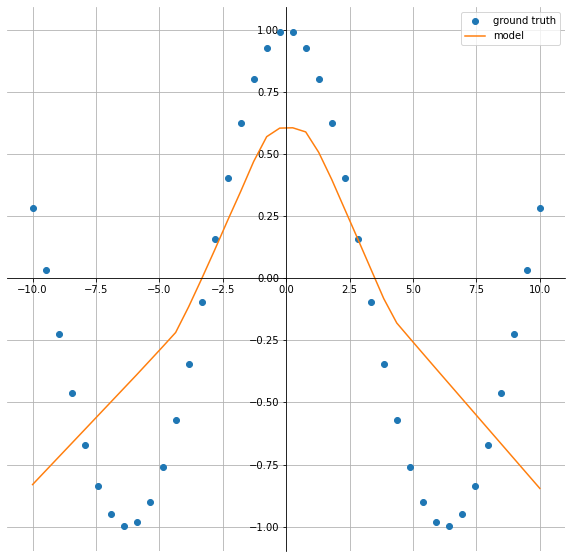

Epoch: 6400; Train Loss: 0.17849494516849518


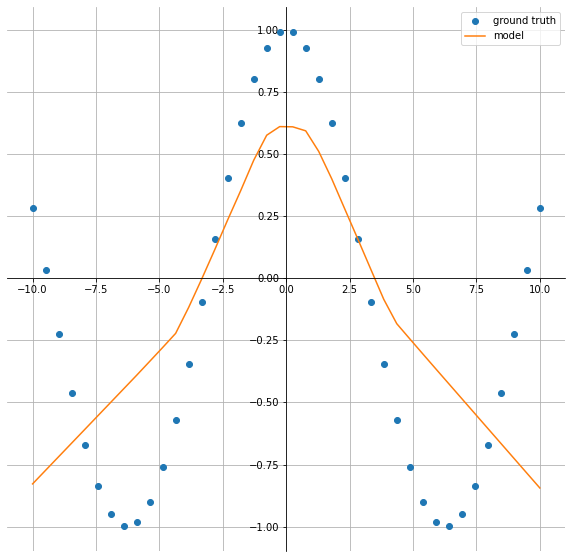

Epoch: 6500; Train Loss: 0.17687073349952698


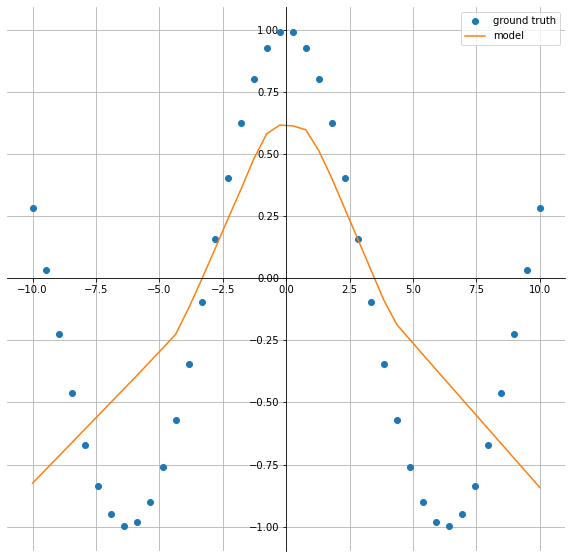

Epoch: 6600; Train Loss: 0.1752144694328308


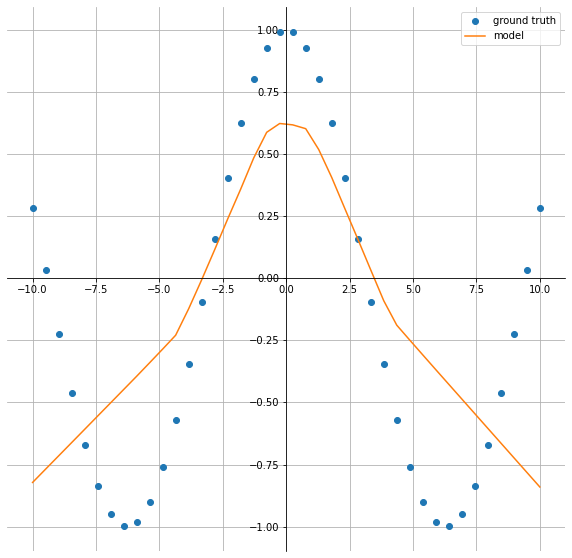

Epoch: 6700; Train Loss: 0.1735270470380783


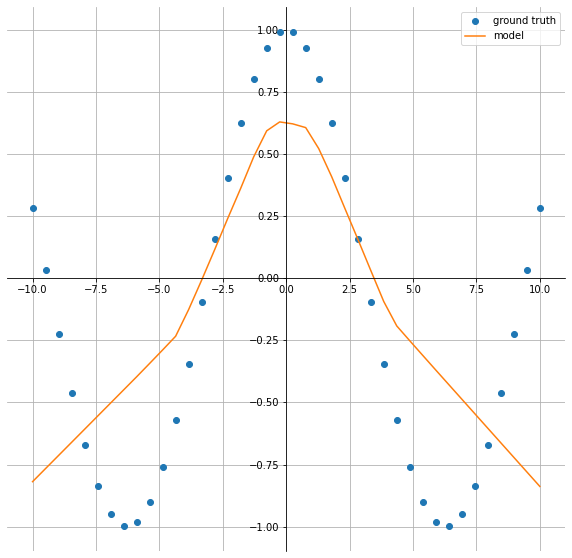

Epoch: 6800; Train Loss: 0.1718074381351471


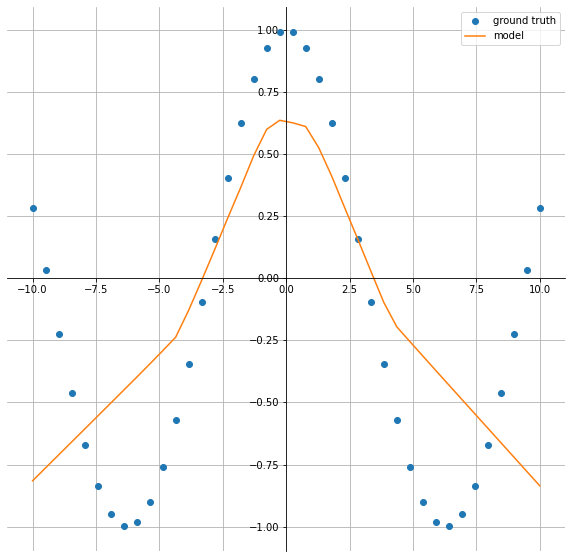

Epoch: 6900; Train Loss: 0.1700473129749298


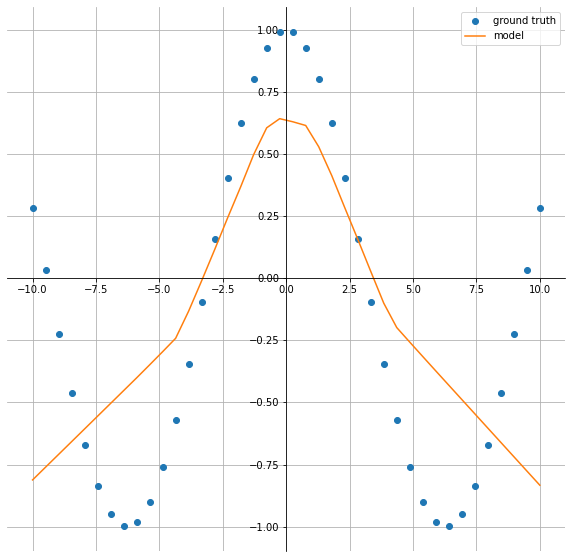

Epoch: 7000; Train Loss: 0.1682414412498474


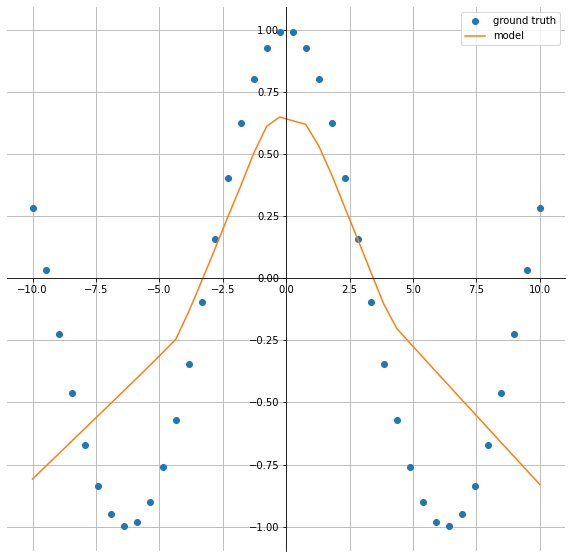

Epoch: 7100; Train Loss: 0.16639843583106995


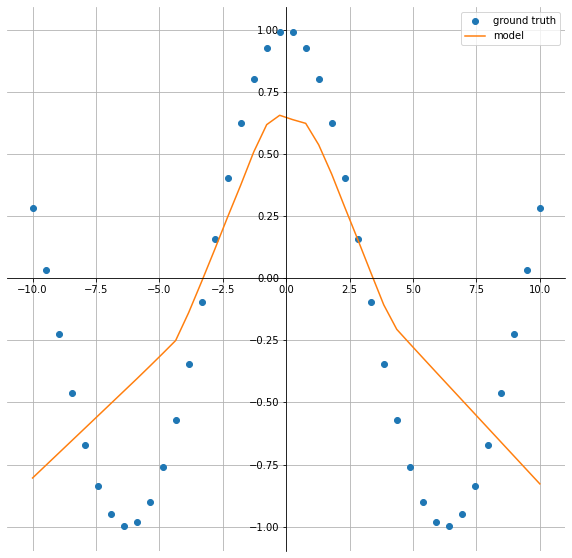

Epoch: 7200; Train Loss: 0.16451920568943024


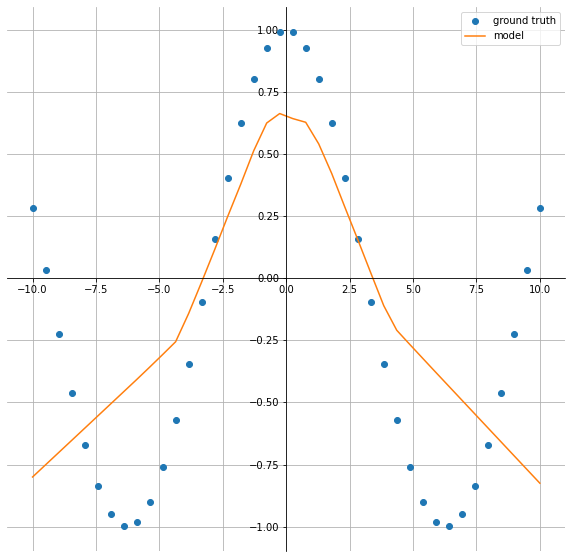

Epoch: 7300; Train Loss: 0.16260504722595215


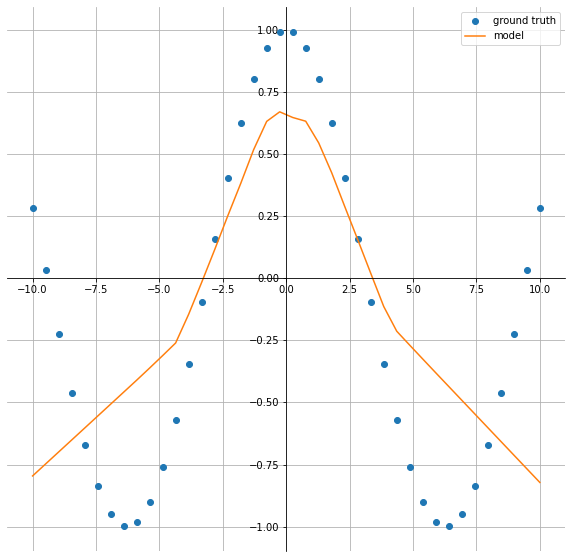

Epoch: 7400; Train Loss: 0.16065286099910736


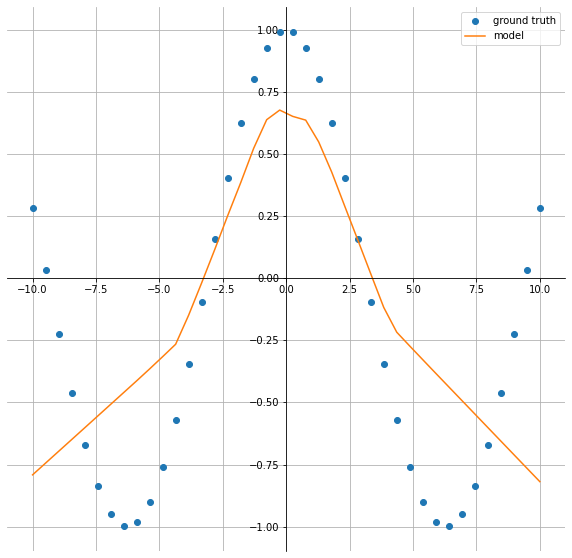

Epoch: 7500; Train Loss: 0.1586637645959854


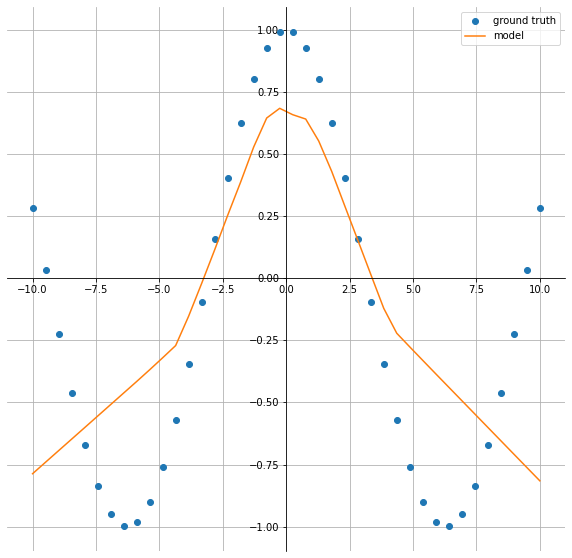

Epoch: 7600; Train Loss: 0.15662918984889984


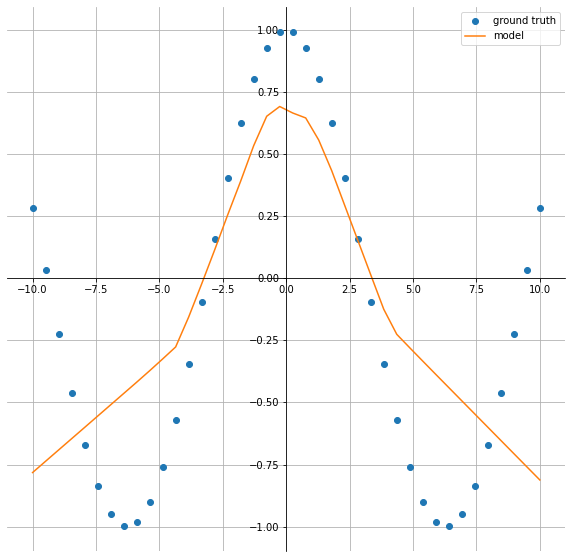

Epoch: 7700; Train Loss: 0.15455466508865356


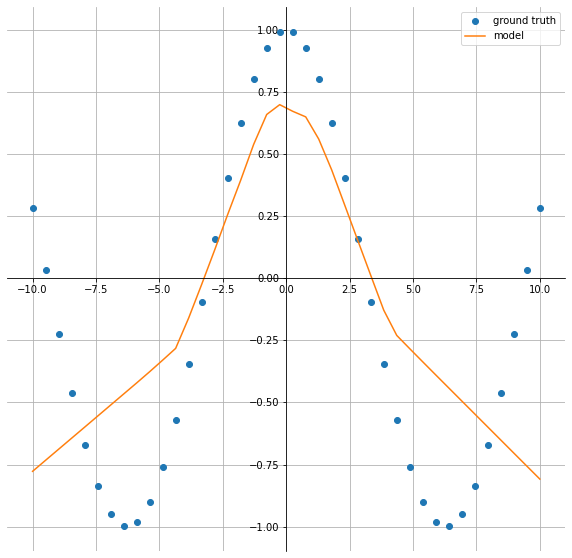

Epoch: 7800; Train Loss: 0.15244659781455994


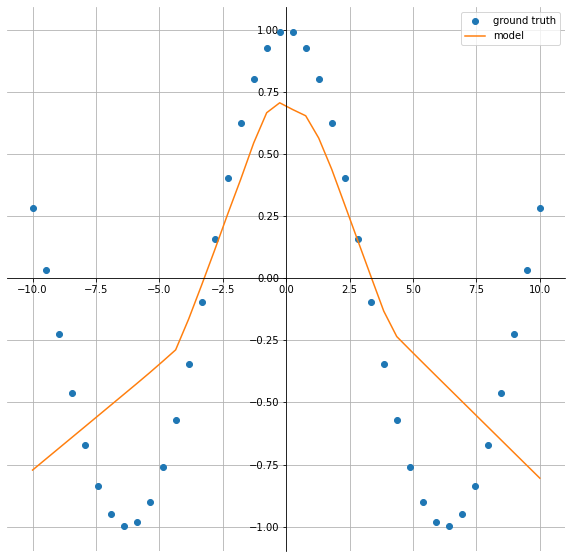

Epoch: 7900; Train Loss: 0.1503027081489563


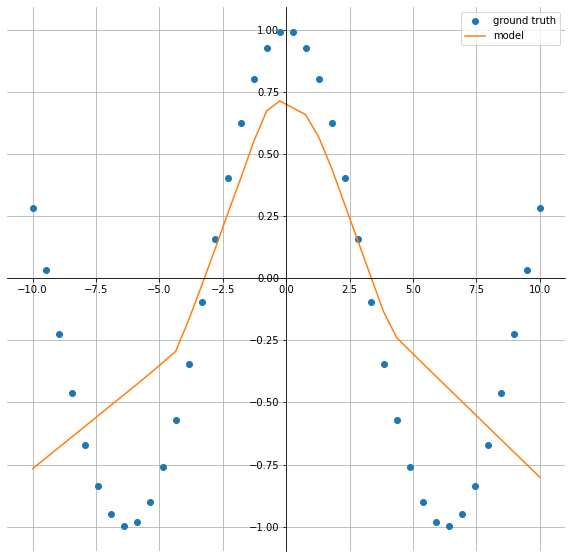

Epoch: 8000; Train Loss: 0.14811833202838898


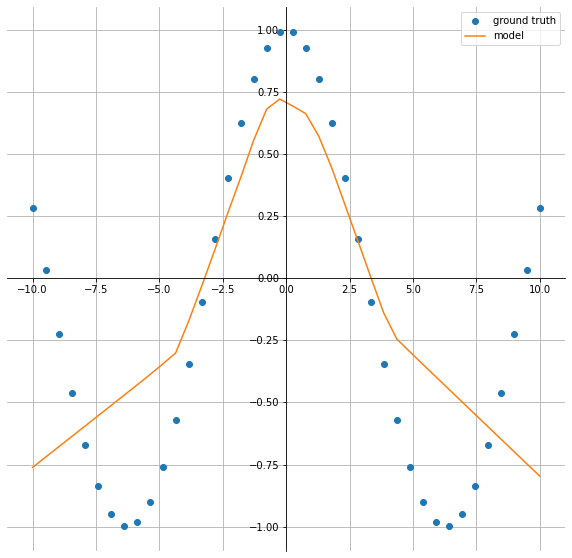

Epoch: 8100; Train Loss: 0.1458941102027893


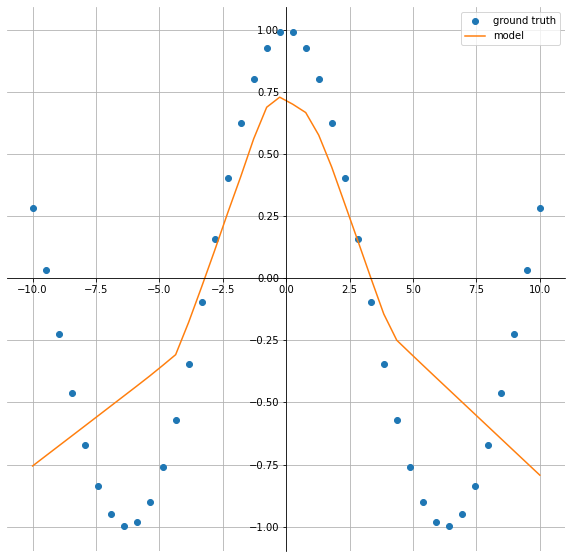

Epoch: 8200; Train Loss: 0.14363572001457214


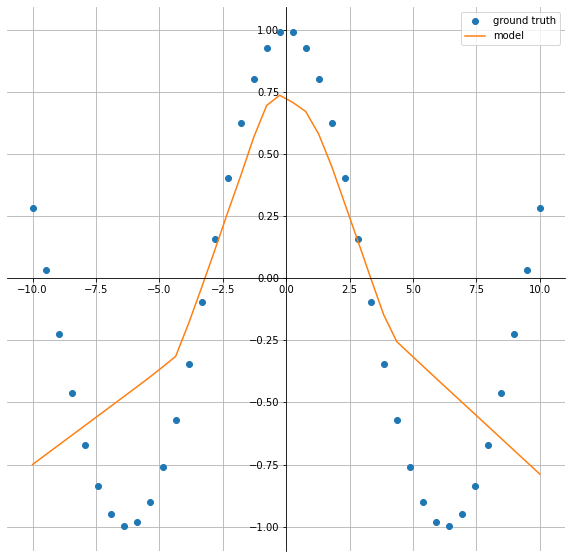

Epoch: 8300; Train Loss: 0.1413416862487793


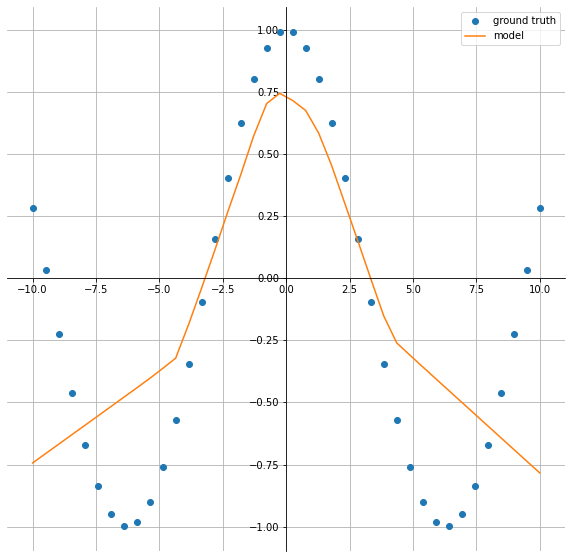

Epoch: 8400; Train Loss: 0.1390136480331421


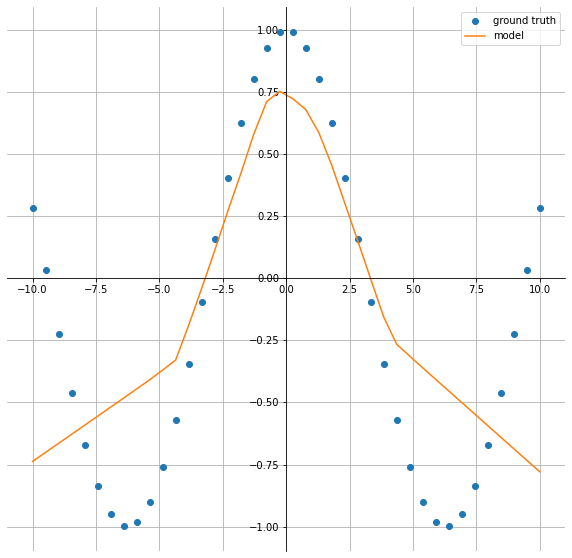

Epoch: 8500; Train Loss: 0.136642187833786


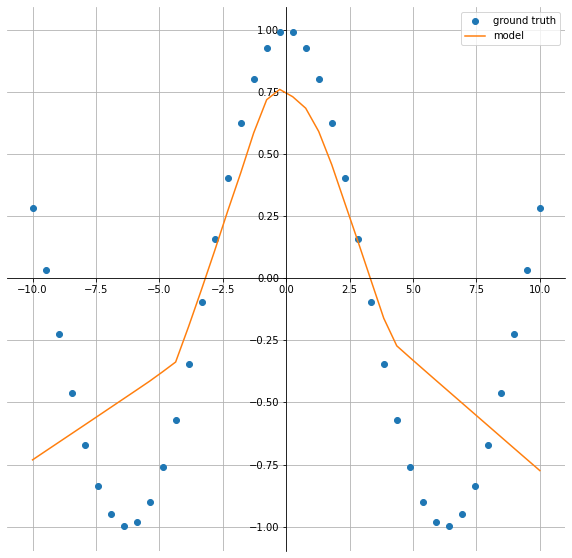

Epoch: 8600; Train Loss: 0.13422535359859467


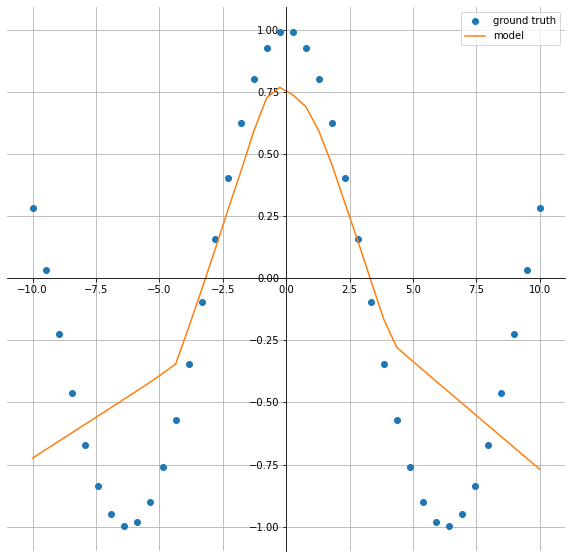

Epoch: 8700; Train Loss: 0.13176317512989044


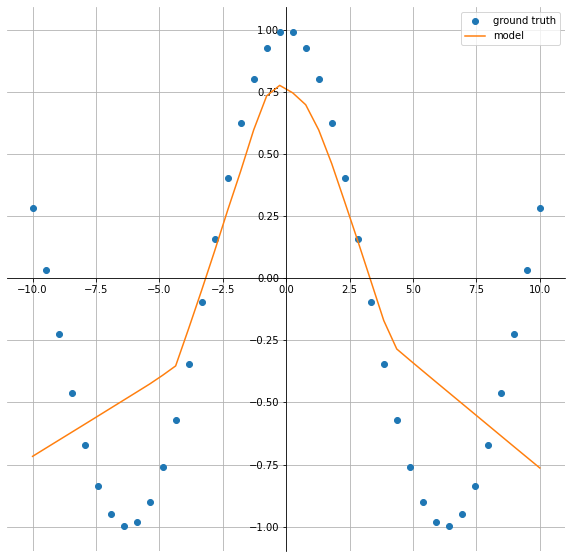

Epoch: 8800; Train Loss: 0.12923823297023773


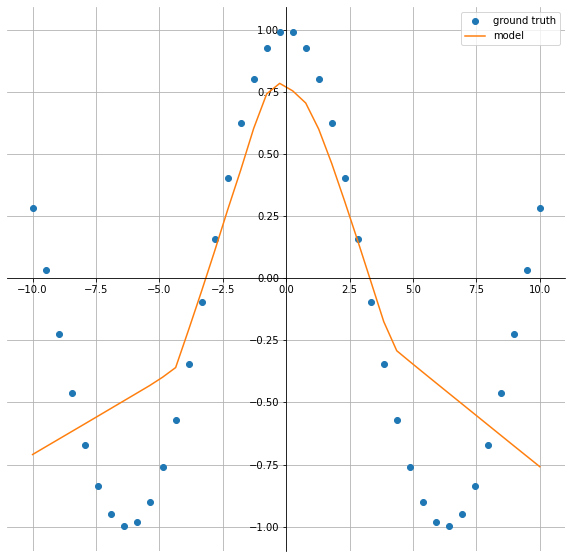

Epoch: 8900; Train Loss: 0.1266019195318222


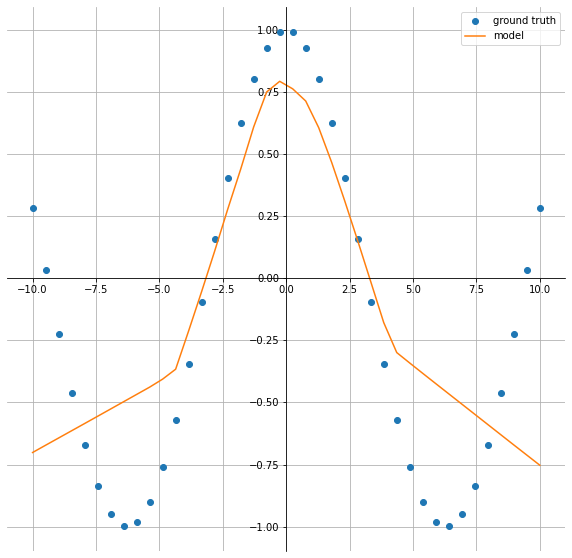

Epoch: 9000; Train Loss: 0.12395071983337402


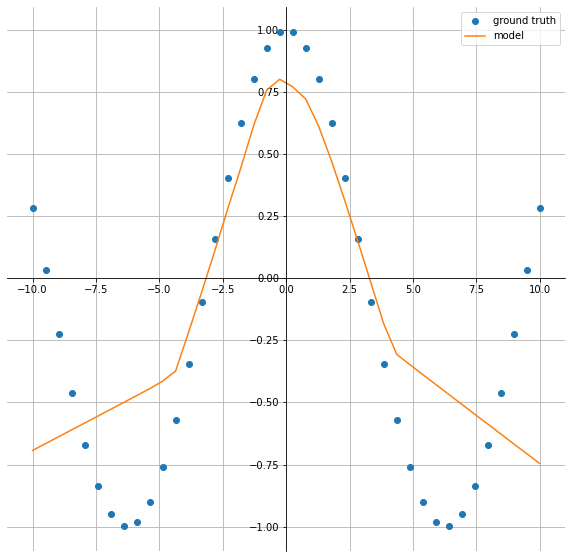

Epoch: 9100; Train Loss: 0.12128107994794846


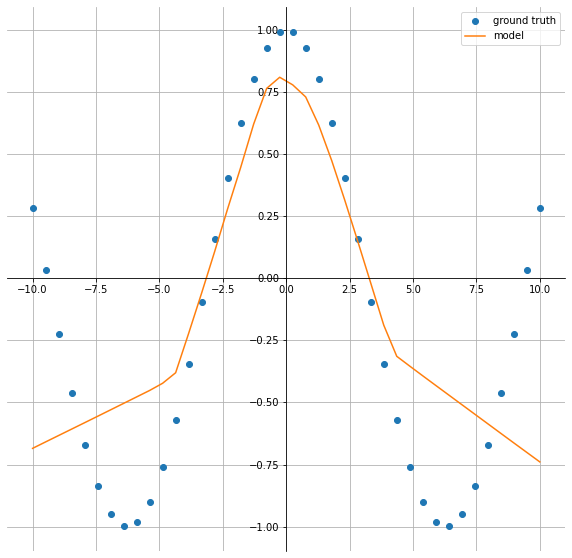

Epoch: 9200; Train Loss: 0.11859361827373505


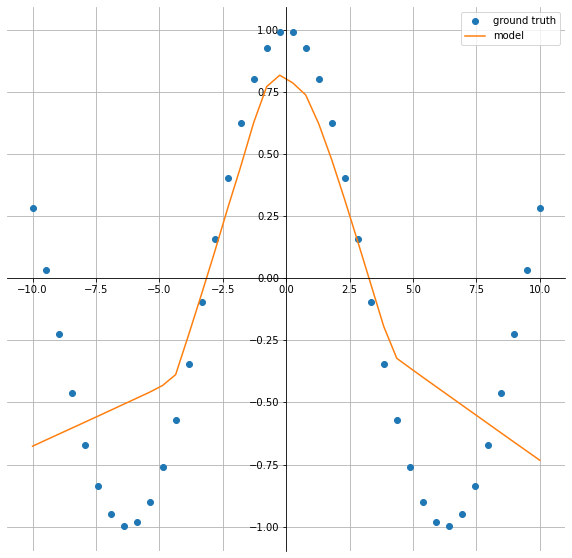

Epoch: 9300; Train Loss: 0.11588554829359055


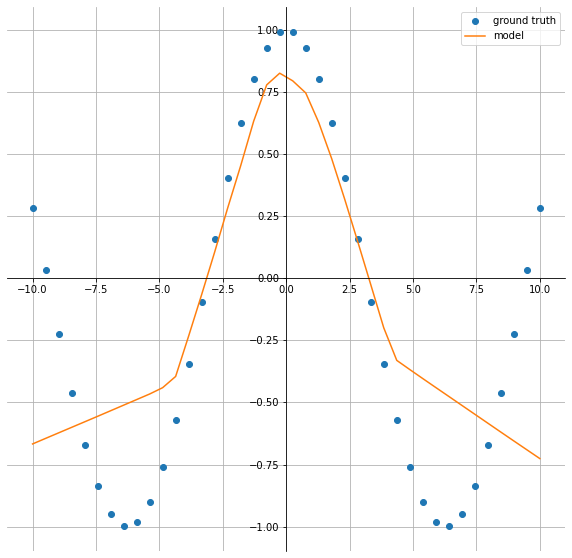

Epoch: 9400; Train Loss: 0.11314191669225693


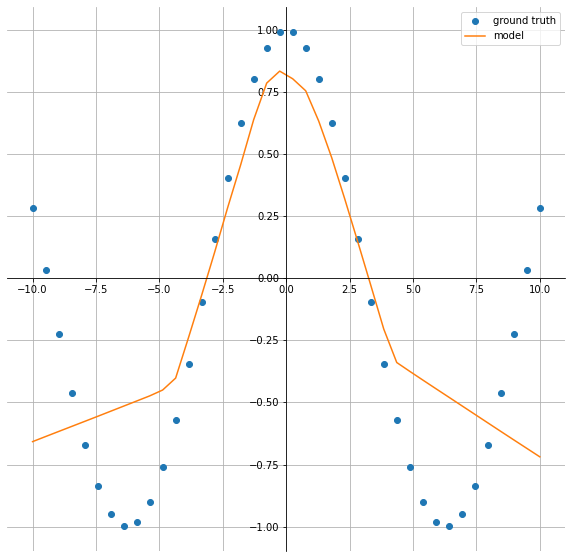

Epoch: 9500; Train Loss: 0.11038389801979065


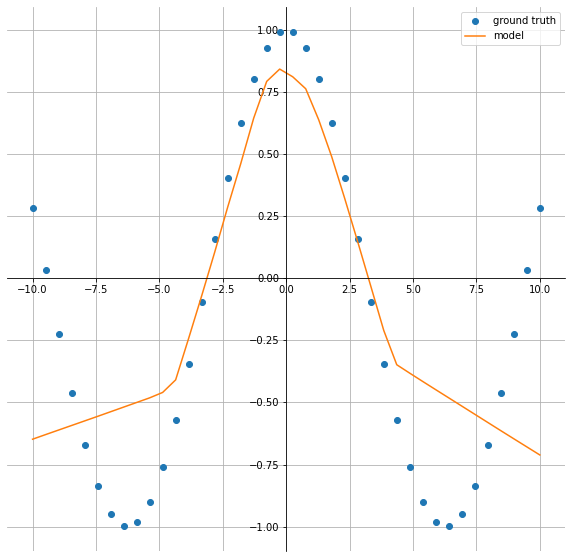

Epoch: 9600; Train Loss: 0.10761580616235733


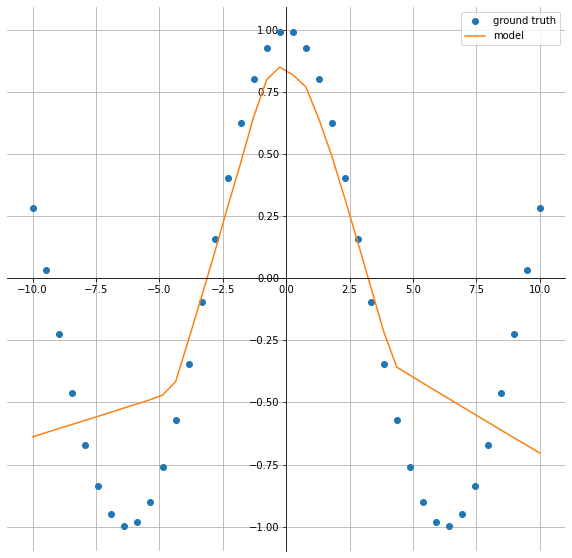

Epoch: 9700; Train Loss: 0.10484220087528229


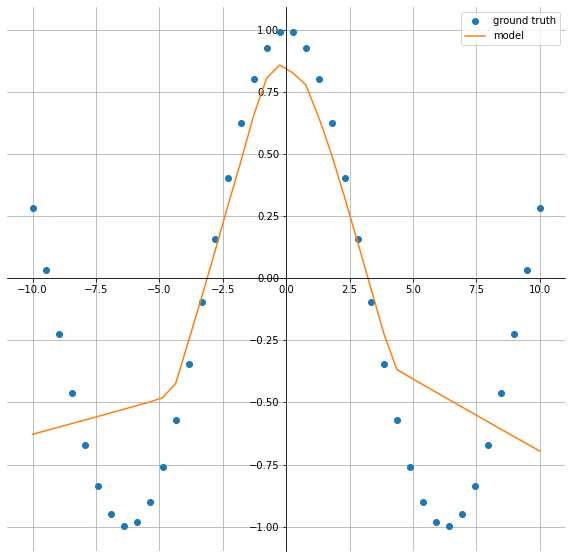

Epoch: 9800; Train Loss: 0.10206999629735947


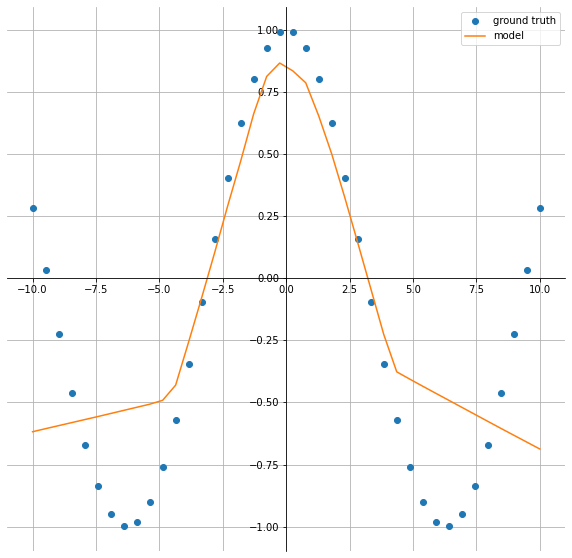

Epoch: 9900; Train Loss: 0.09930451214313507


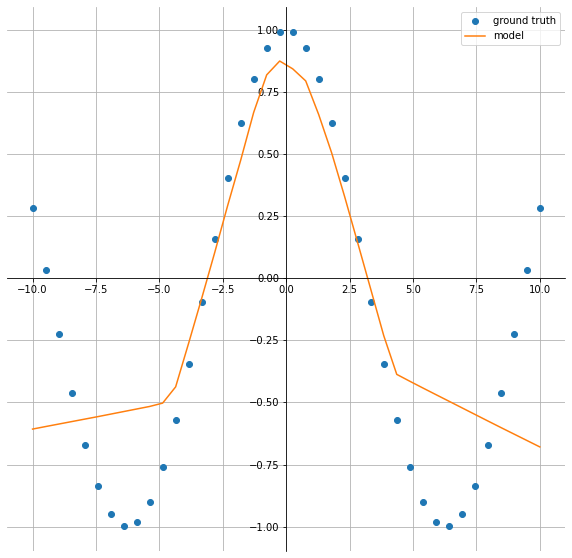

Epoch: 10000; Train Loss: 0.09654567390680313


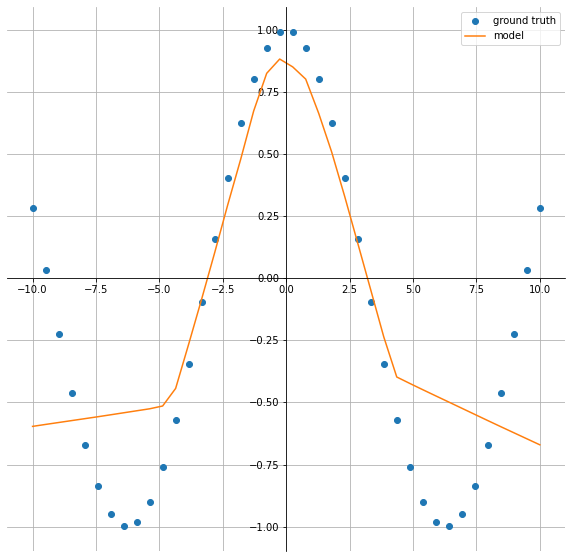

Epoch: 10100; Train Loss: 0.09379526227712631


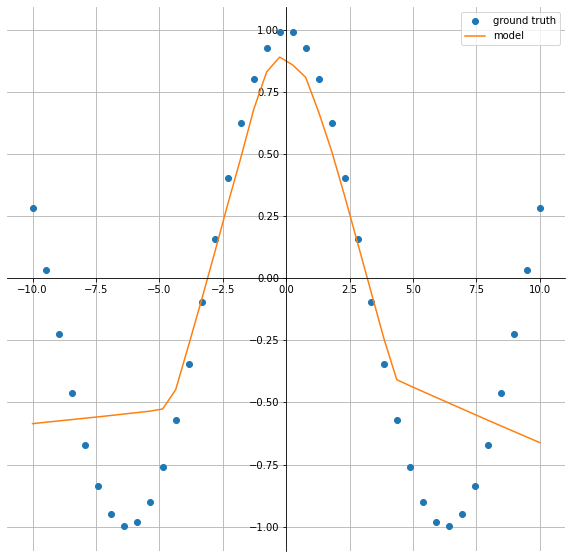

Epoch: 10200; Train Loss: 0.09105676412582397


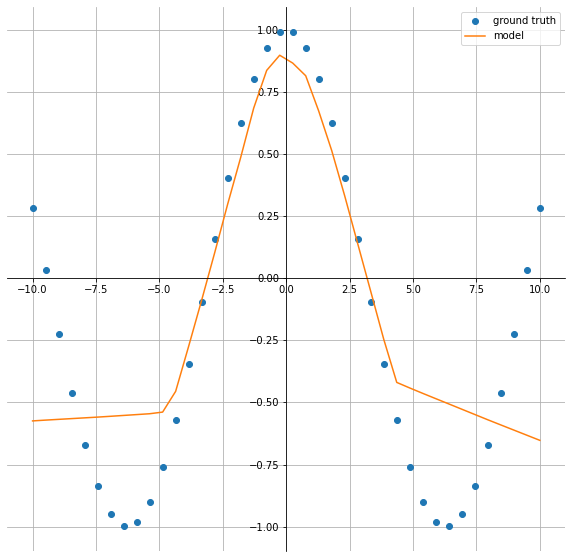

Epoch: 10300; Train Loss: 0.08833637833595276


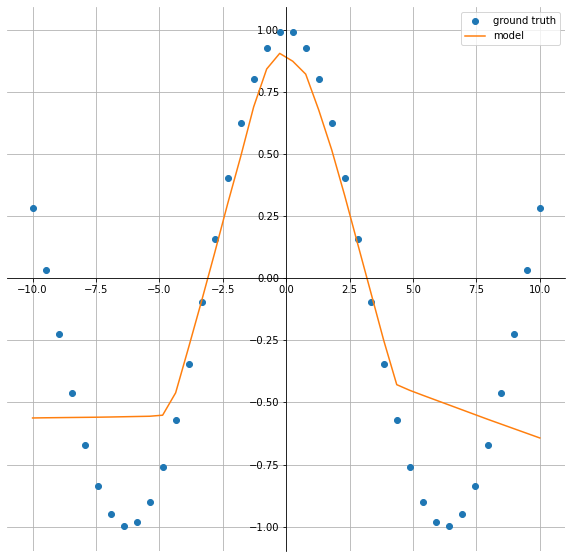

Epoch: 10400; Train Loss: 0.08564060181379318


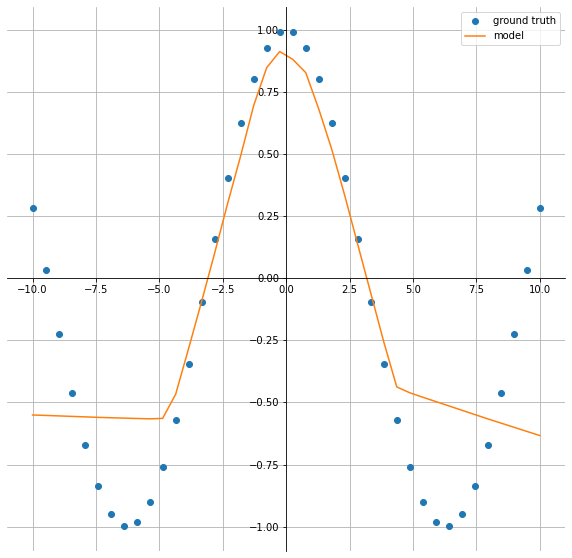

Epoch: 10500; Train Loss: 0.0829680860042572


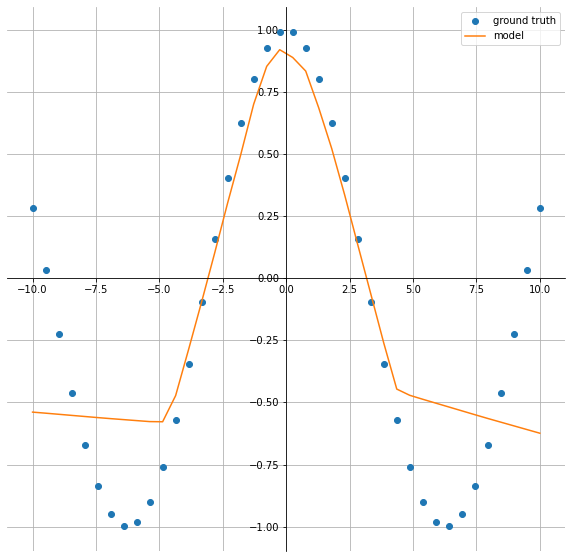

Epoch: 10600; Train Loss: 0.08031625300645828


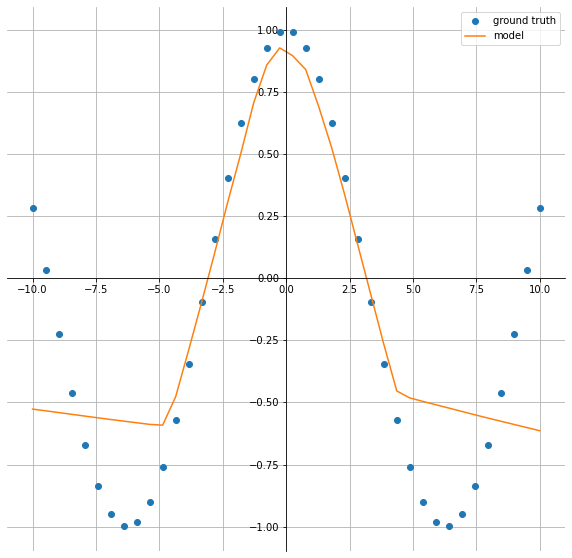

Epoch: 10700; Train Loss: 0.07769393920898438


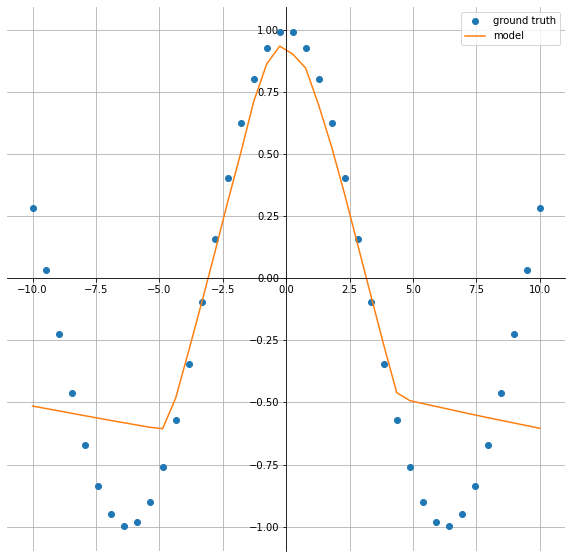

Epoch: 10800; Train Loss: 0.07510128617286682


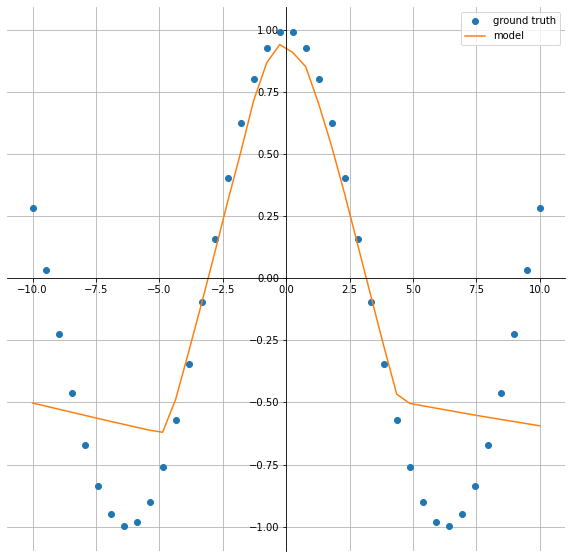

Epoch: 10900; Train Loss: 0.07253947854042053


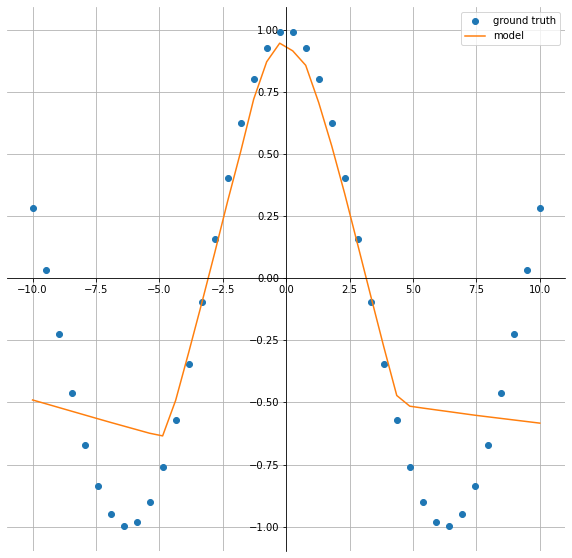

Epoch: 11000; Train Loss: 0.07001479715108871


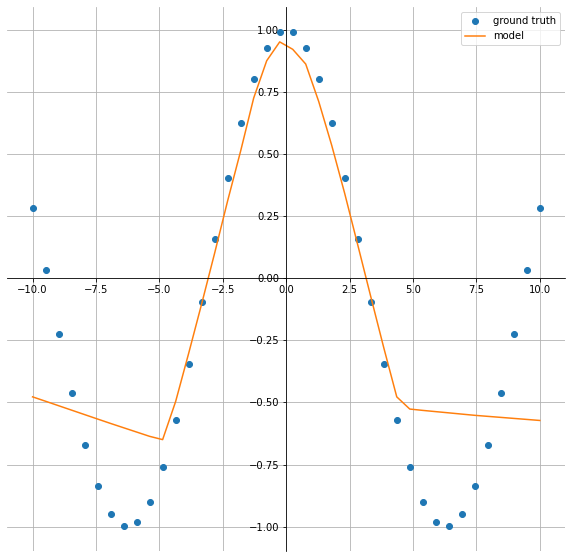

Epoch: 11100; Train Loss: 0.06752654165029526


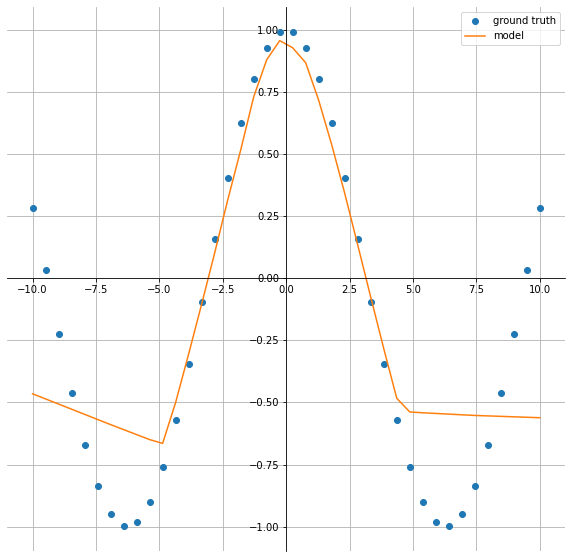

Epoch: 11200; Train Loss: 0.0650758147239685


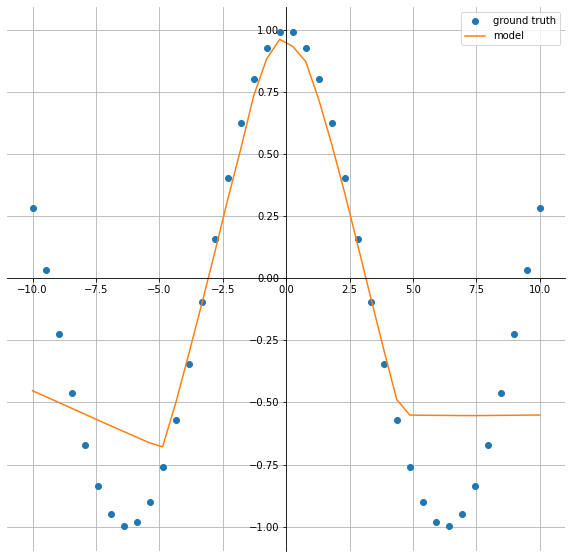

Epoch: 11300; Train Loss: 0.0626625195145607


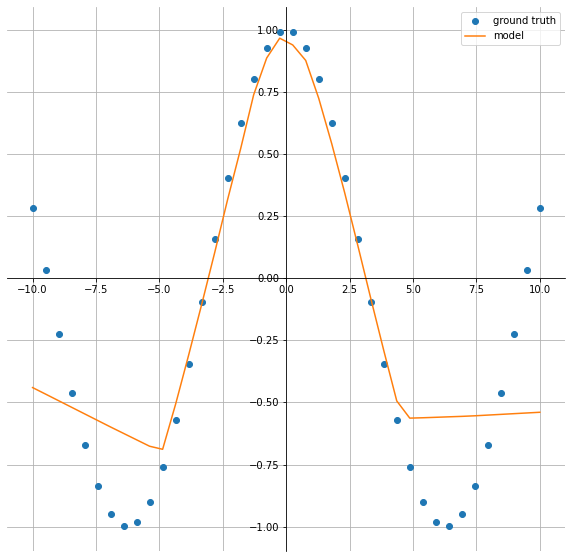

Epoch: 11400; Train Loss: 0.060288868844509125


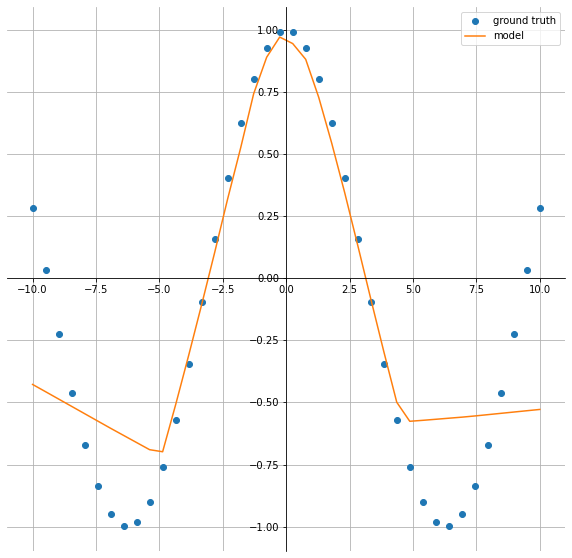

Epoch: 11500; Train Loss: 0.057958073914051056


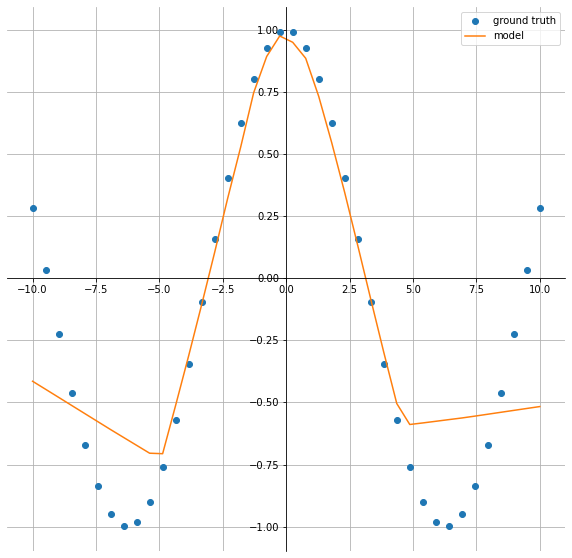

Epoch: 11600; Train Loss: 0.05566813424229622


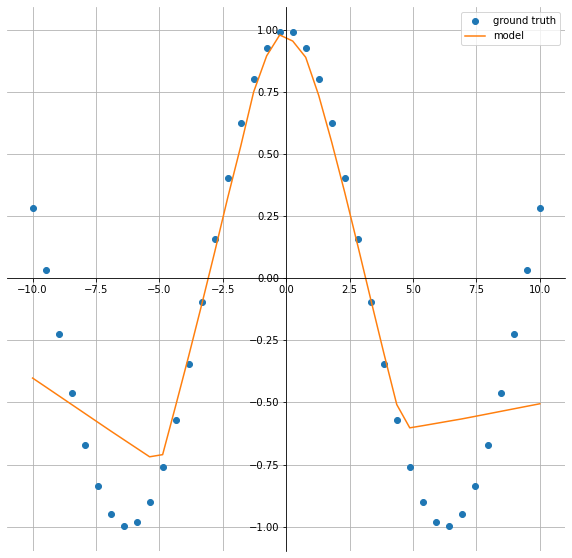

Epoch: 11700; Train Loss: 0.053422242403030396


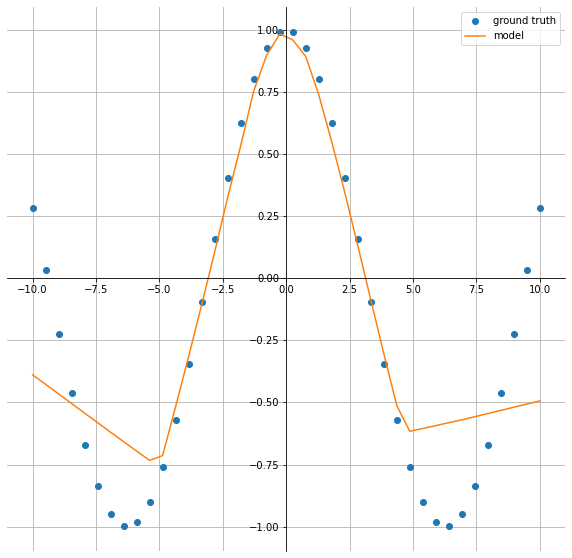

Epoch: 11800; Train Loss: 0.05122525990009308


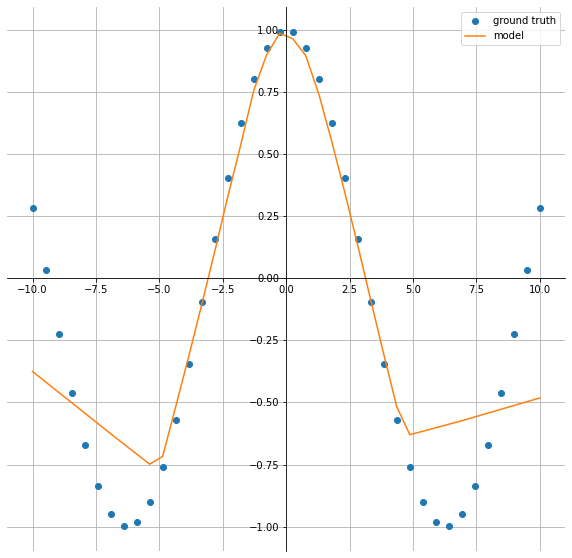

Epoch: 11900; Train Loss: 0.049076490104198456


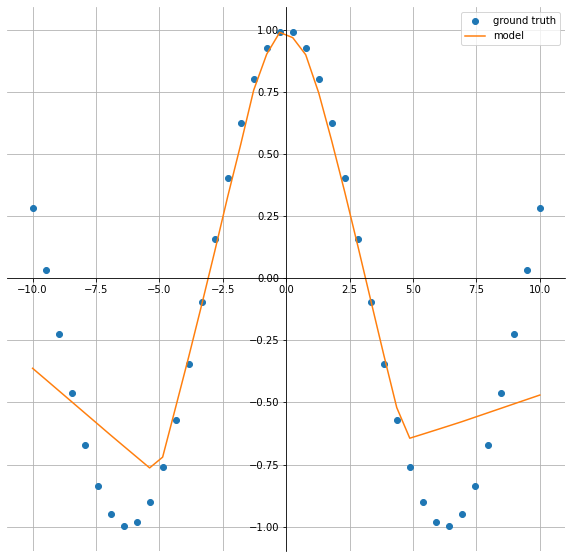

Epoch: 12000; Train Loss: 0.04697757214307785


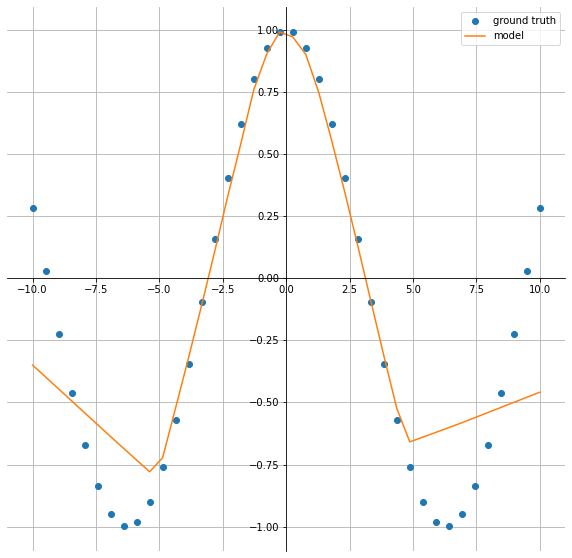

Epoch: 12100; Train Loss: 0.04492827132344246


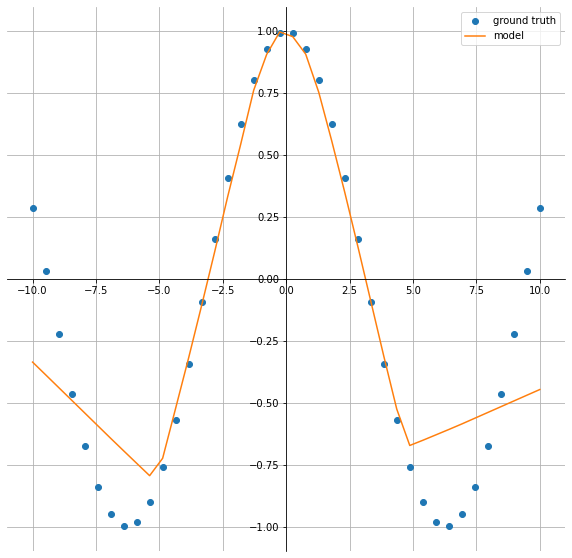

Epoch: 12200; Train Loss: 0.04293277859687805


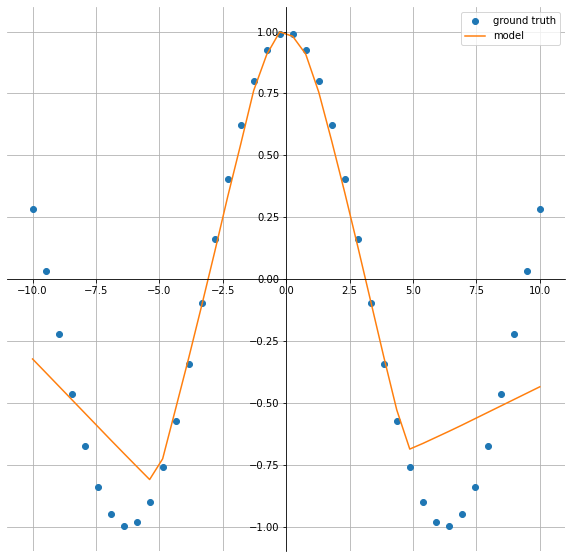

Epoch: 12300; Train Loss: 0.04099162667989731


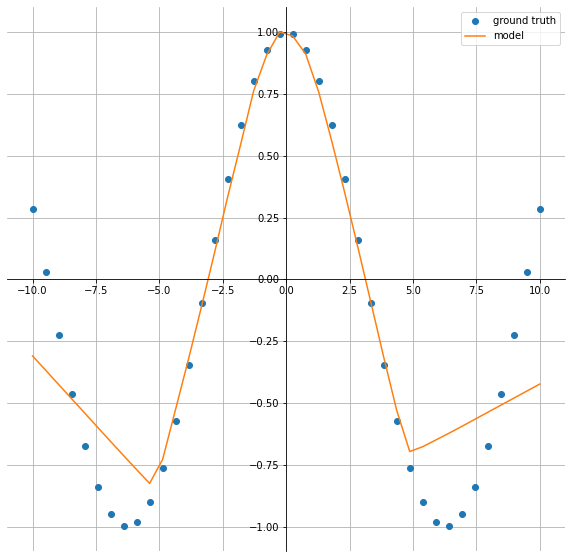

Epoch: 12400; Train Loss: 0.03910575062036514


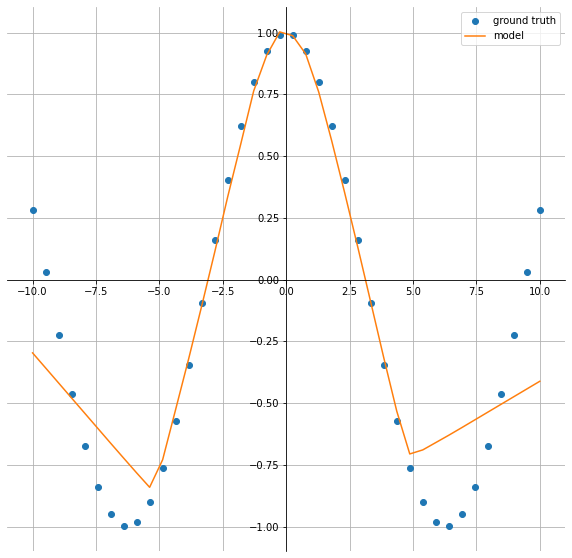

Epoch: 12500; Train Loss: 0.03727781027555466


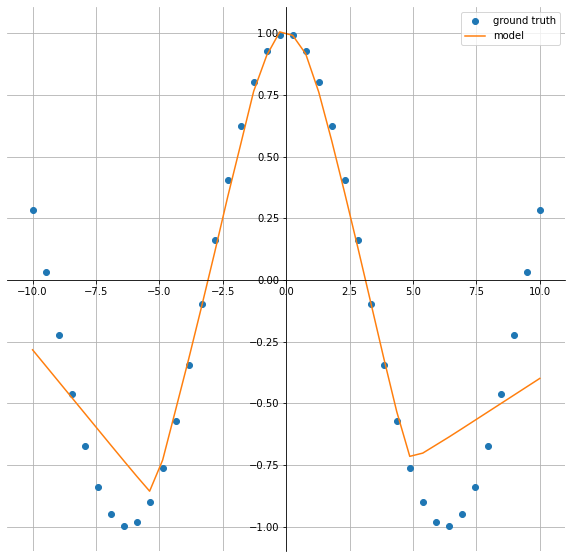

Epoch: 12600; Train Loss: 0.03551056608557701


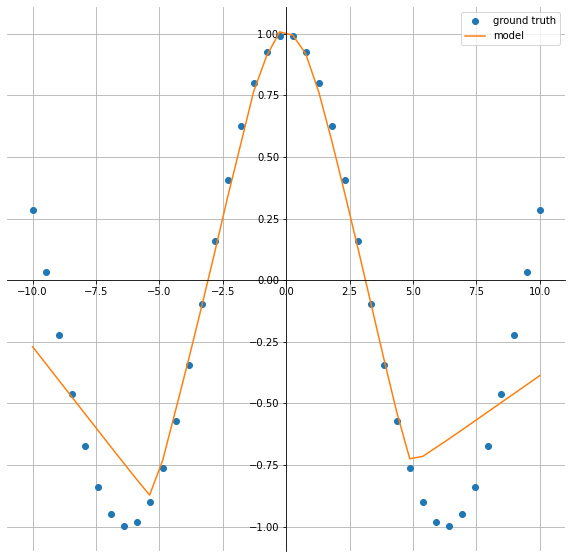

Epoch: 12700; Train Loss: 0.03380419313907623


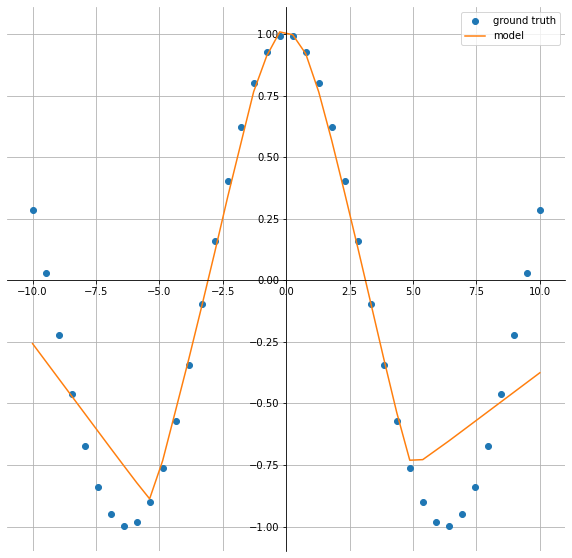

Epoch: 12800; Train Loss: 0.03215992450714111


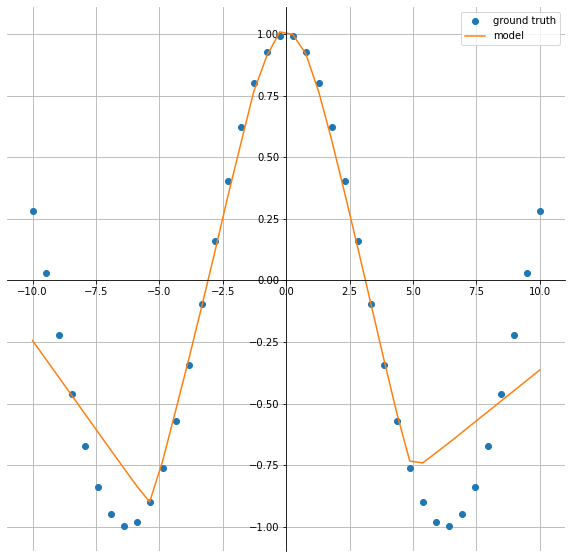

Epoch: 12900; Train Loss: 0.03057987429201603


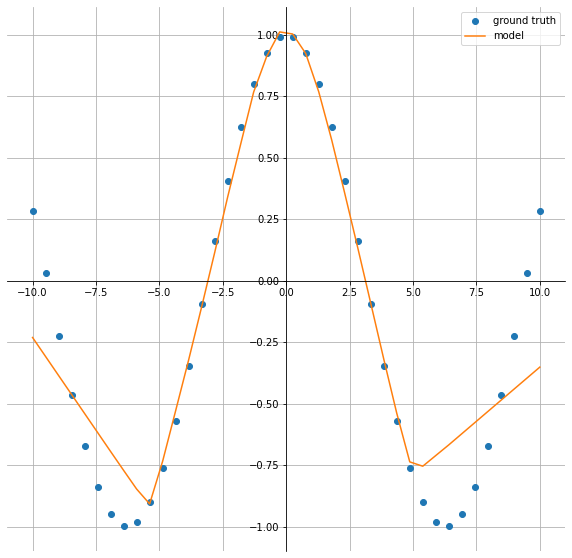

Epoch: 13000; Train Loss: 0.029066072776913643


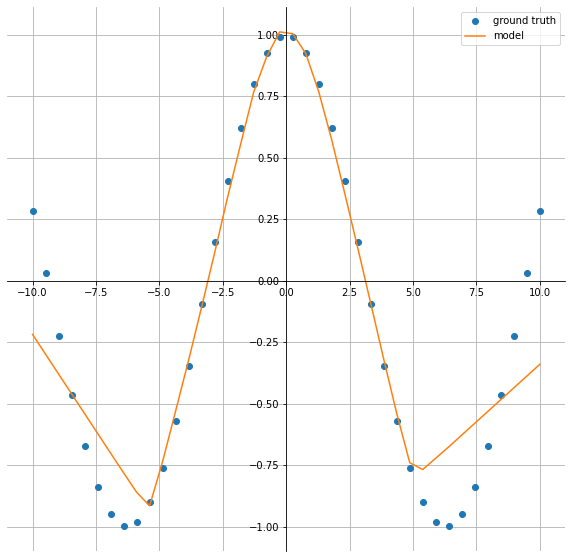

Epoch: 13100; Train Loss: 0.02761719934642315


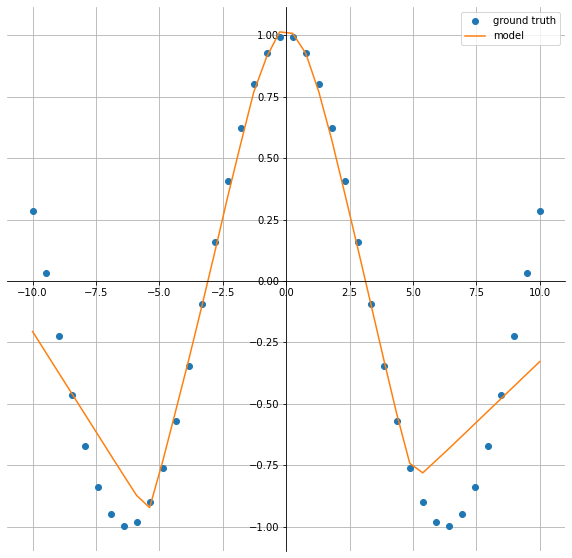

Epoch: 13200; Train Loss: 0.026231974363327026


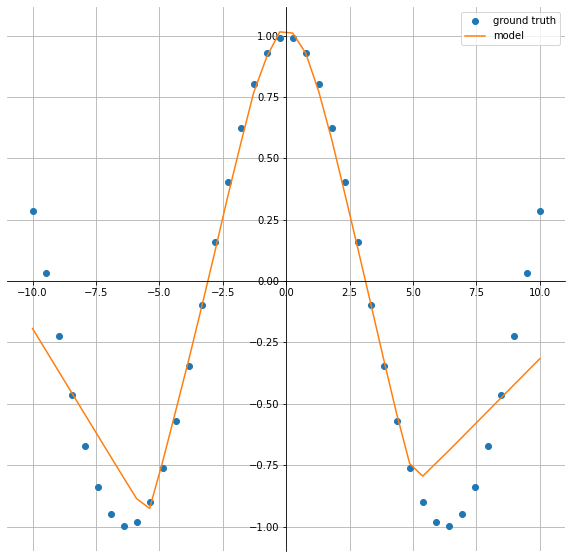

Epoch: 13300; Train Loss: 0.024911051616072655


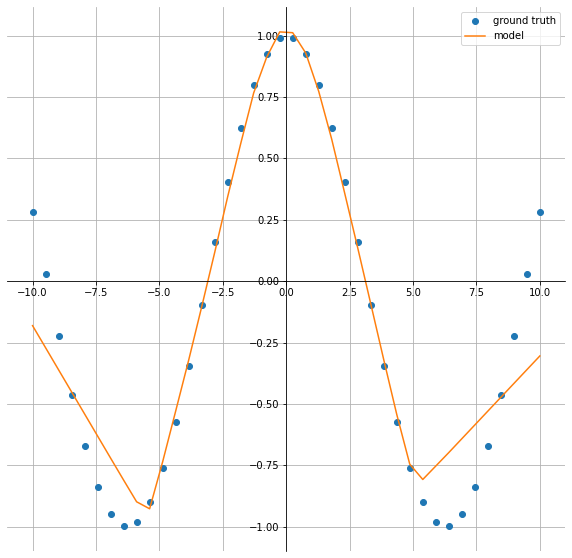

Epoch: 13400; Train Loss: 0.023653844371438026


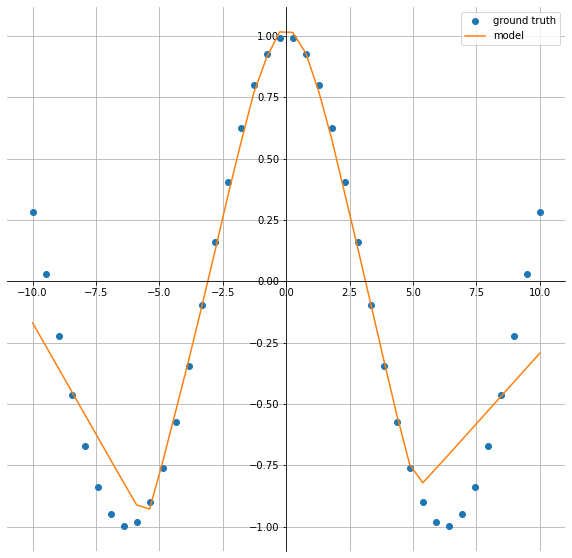

Epoch: 13500; Train Loss: 0.022452184930443764


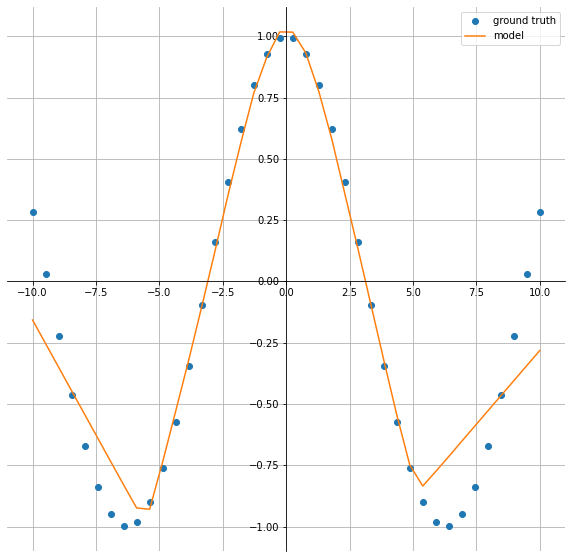

Epoch: 13600; Train Loss: 0.021297290921211243


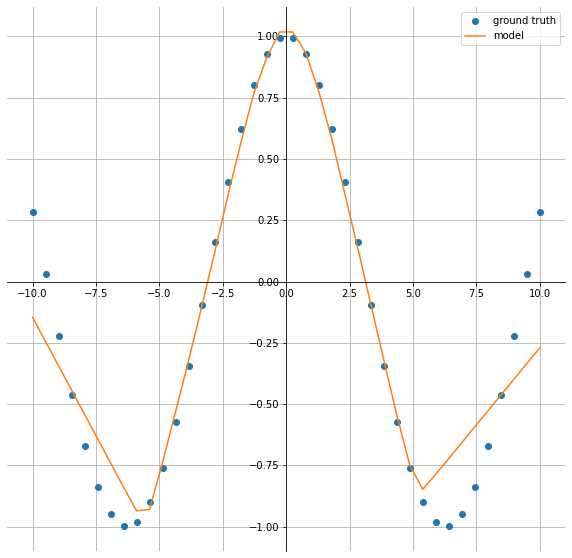

Epoch: 13700; Train Loss: 0.020162729546427727


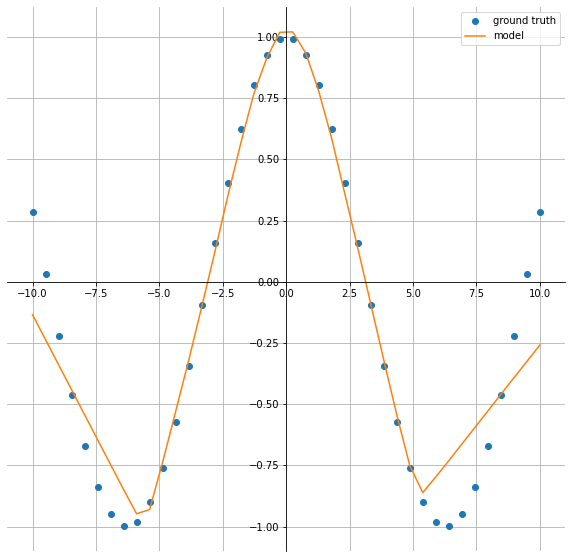

Epoch: 13800; Train Loss: 0.019127056002616882


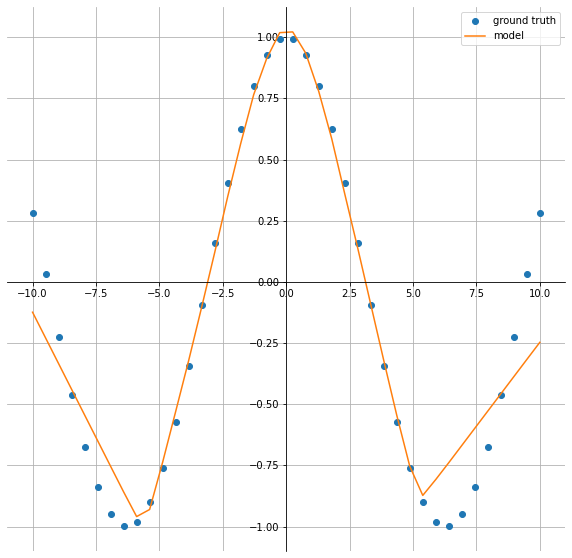

Epoch: 13900; Train Loss: 0.018172062933444977


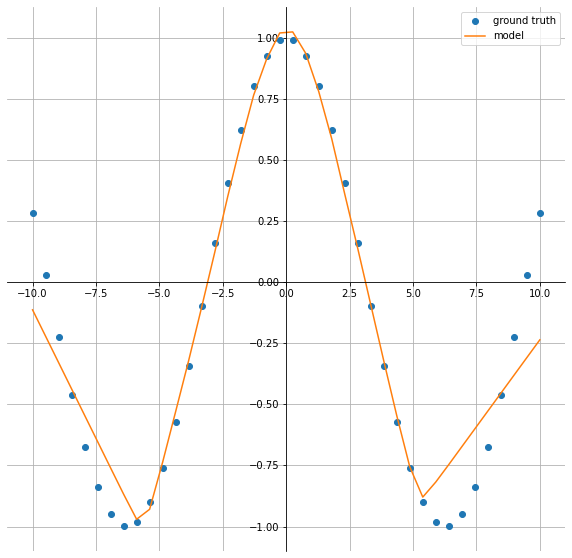

Epoch: 14000; Train Loss: 0.017272036522626877


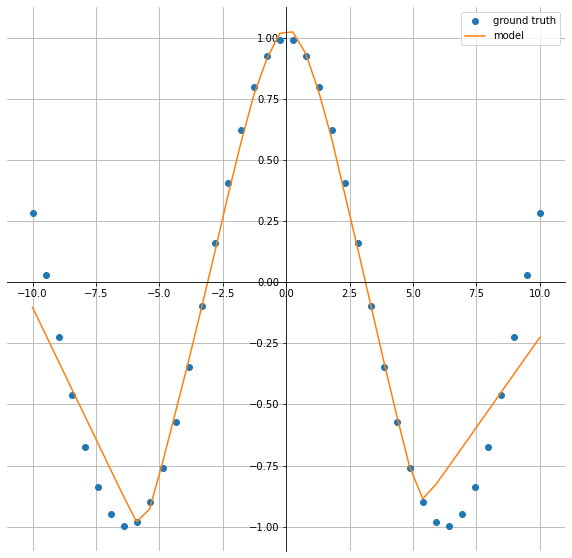

Epoch: 14100; Train Loss: 0.016424376517534256


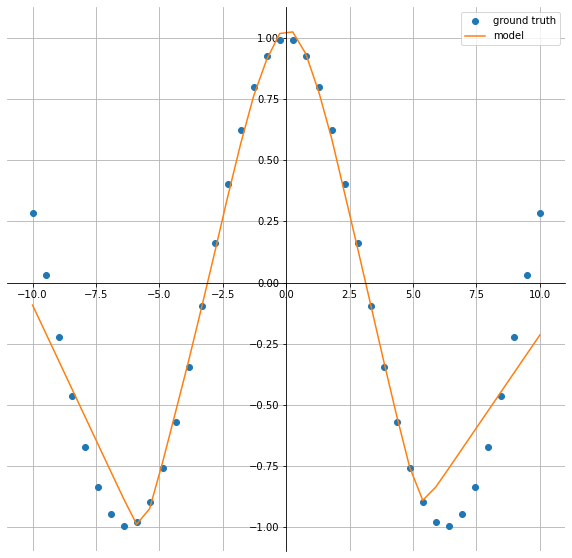

Epoch: 14200; Train Loss: 0.01562579907476902


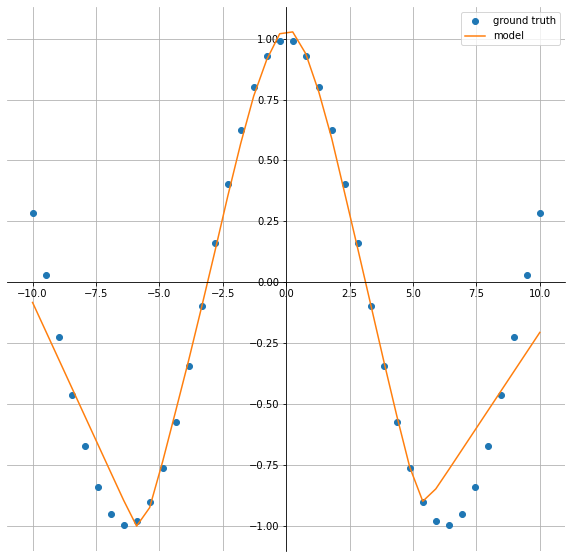

Epoch: 14300; Train Loss: 0.014874020591378212


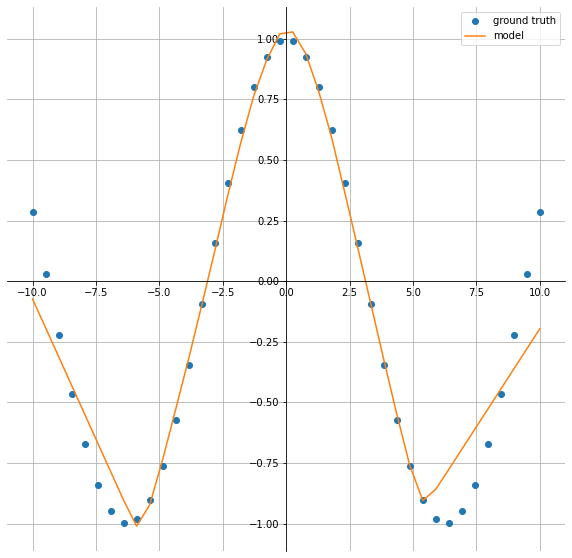

Epoch: 14400; Train Loss: 0.014166506938636303


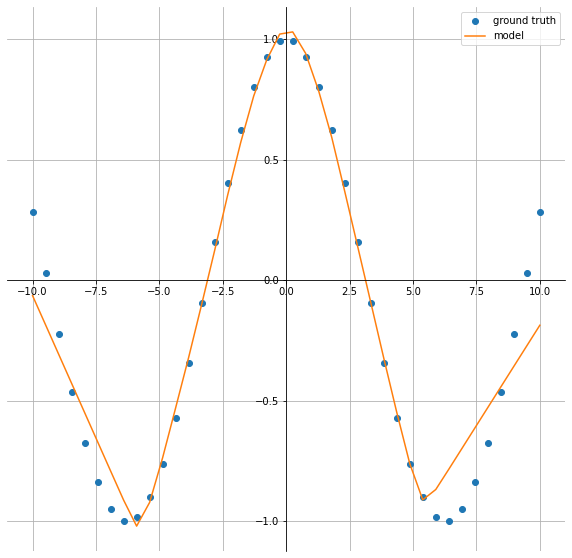

Epoch: 14500; Train Loss: 0.013502524234354496


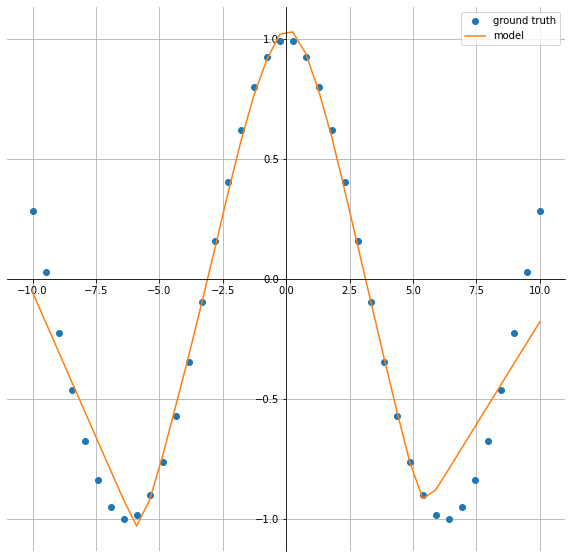

Epoch: 14600; Train Loss: 0.012877998873591423


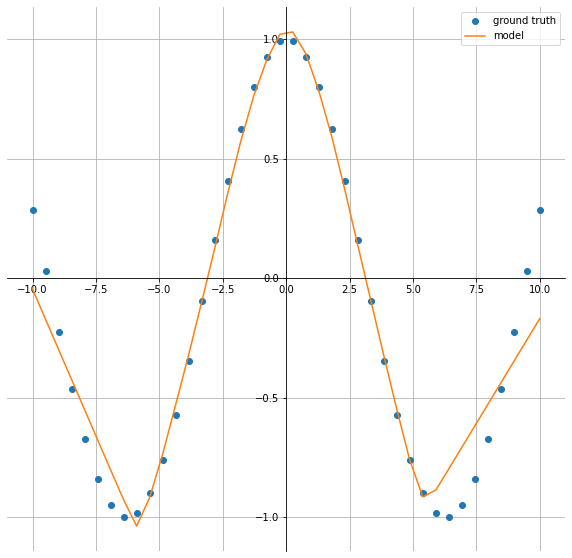

Epoch: 14700; Train Loss: 0.012288915924727917


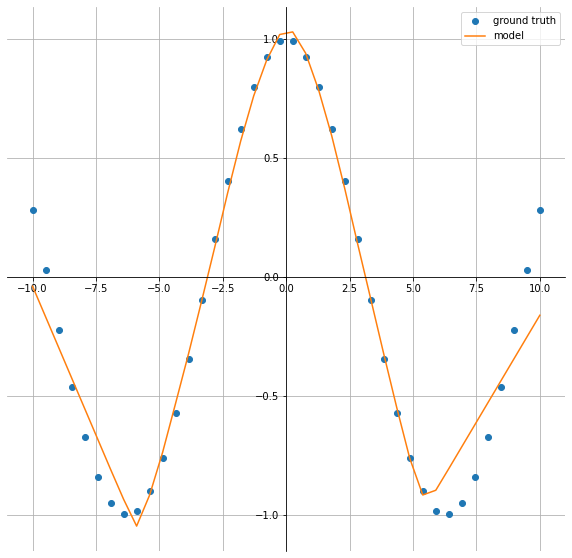

Epoch: 14800; Train Loss: 0.011730562895536423


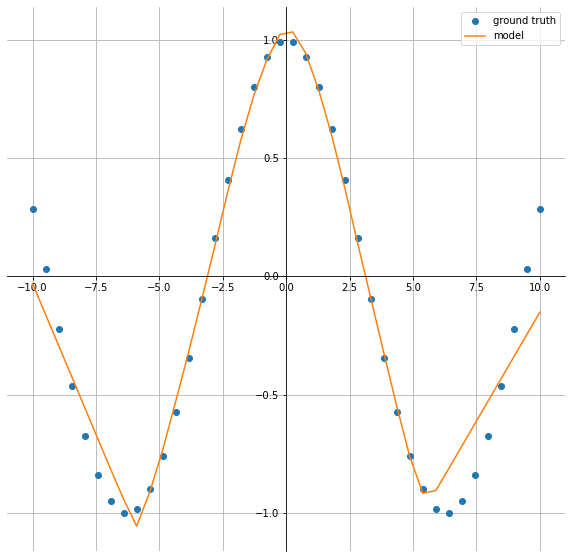

Epoch: 14900; Train Loss: 0.01120086945593357


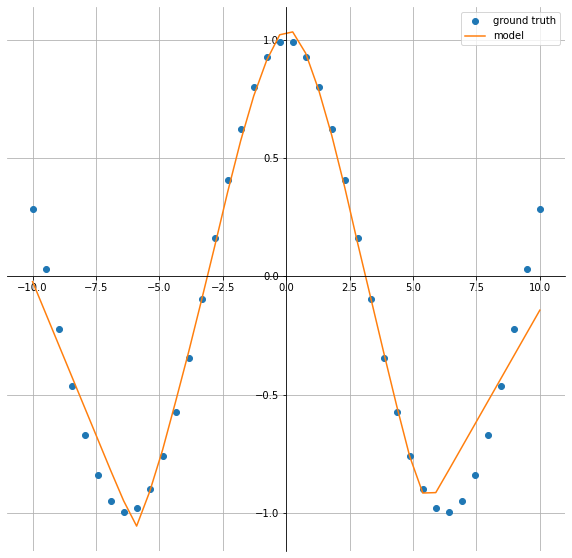

Epoch: 15000; Train Loss: 0.010703463107347488


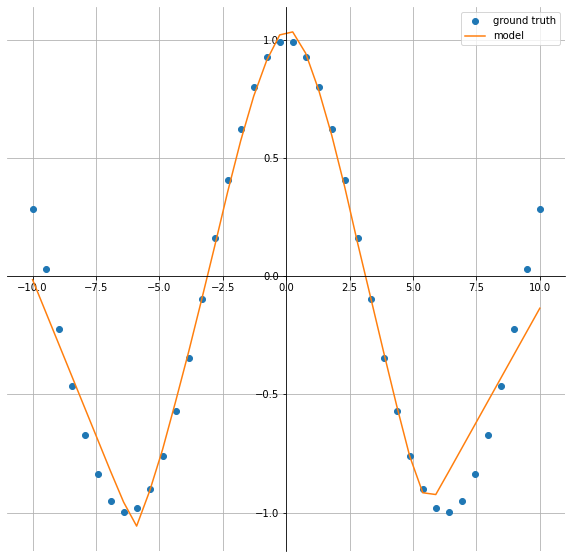

Epoch: 15100; Train Loss: 0.010231316089630127


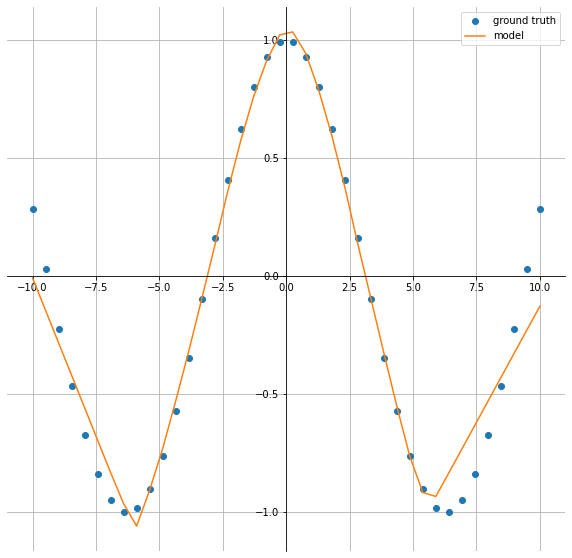

Epoch: 15200; Train Loss: 0.009783066809177399


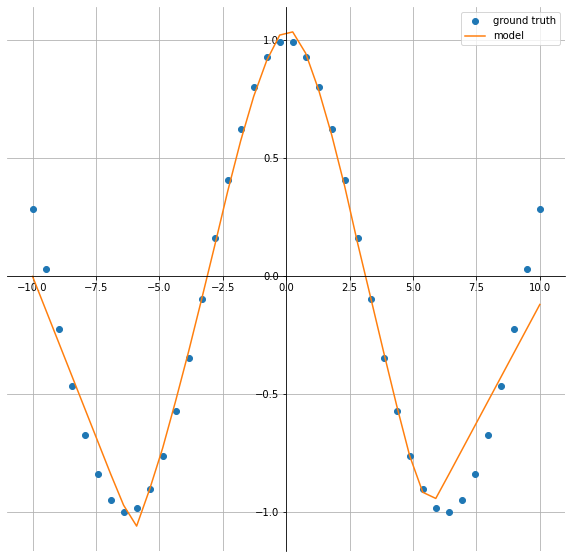

Epoch: 15300; Train Loss: 0.00935107097029686


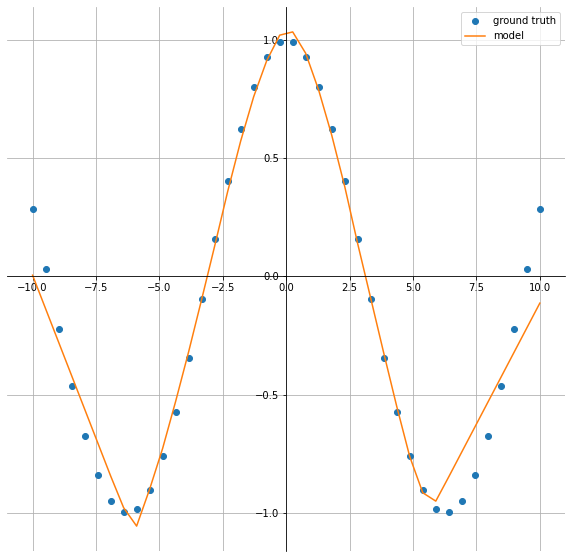

Epoch: 15400; Train Loss: 0.008944830857217312


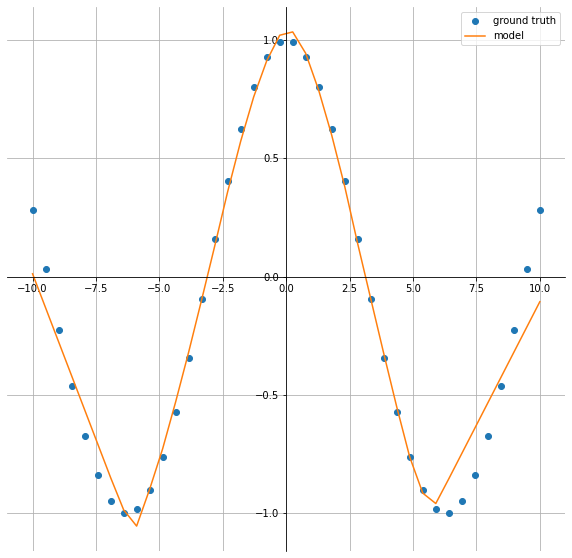

Epoch: 15500; Train Loss: 0.008563357405364513


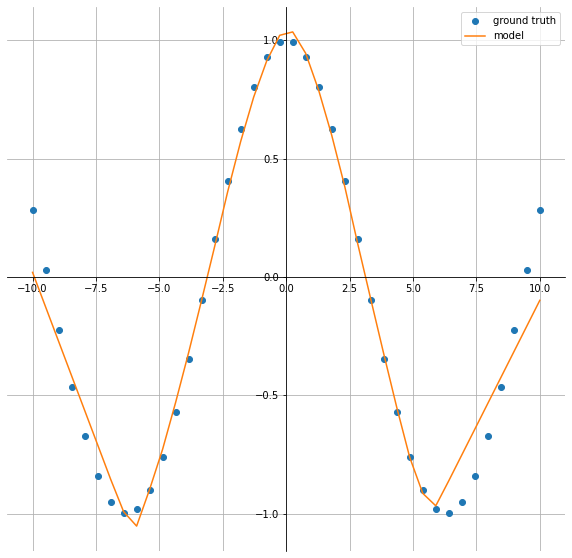

Epoch: 15600; Train Loss: 0.008204714395105839


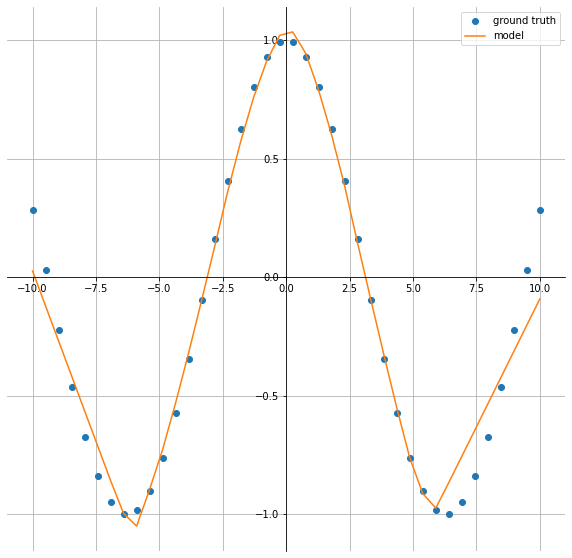

Epoch: 15700; Train Loss: 0.00786444079130888


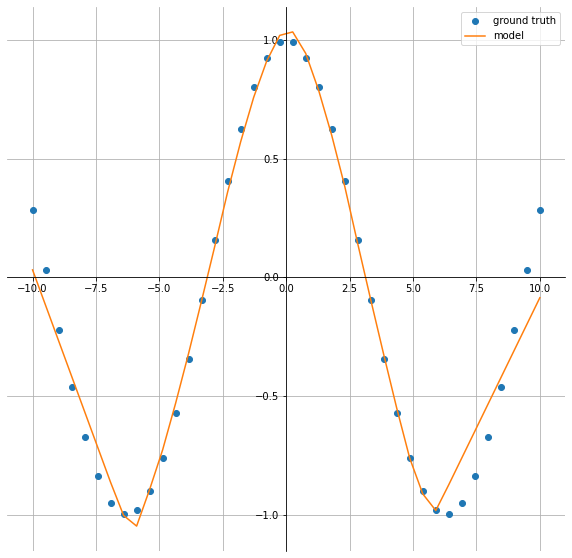

Epoch: 15800; Train Loss: 0.007542292587459087


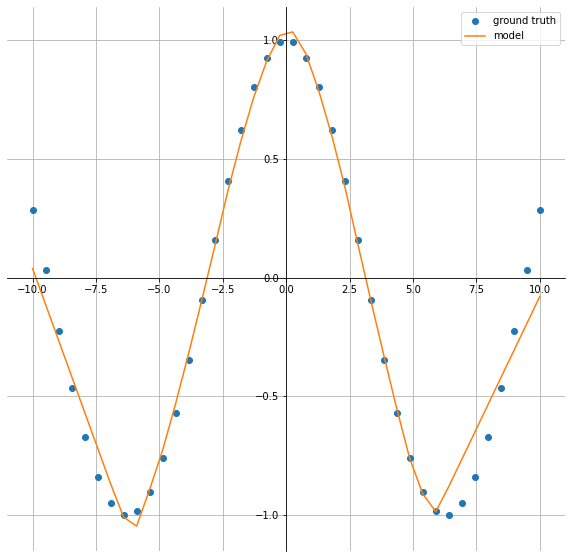

Epoch: 15900; Train Loss: 0.007239300757646561


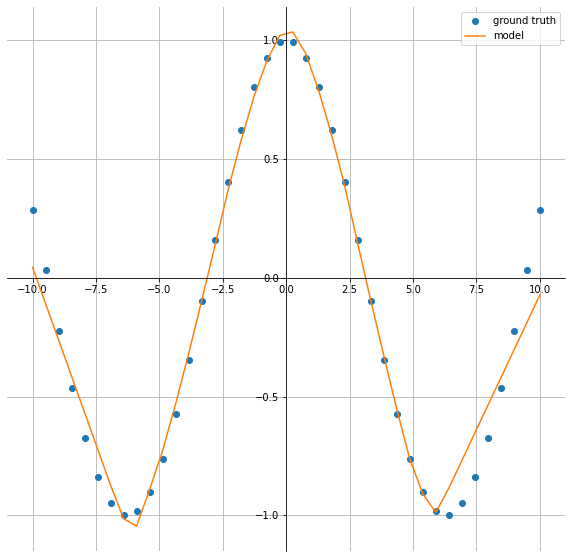

Epoch: 16000; Train Loss: 0.006952607072889805


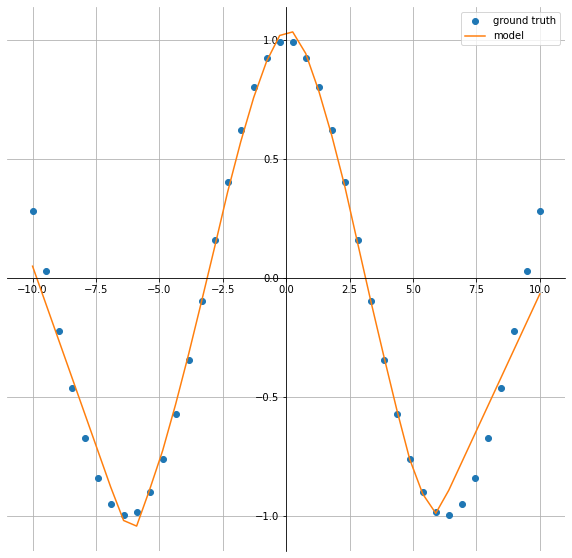

Epoch: 16100; Train Loss: 0.00667908601462841


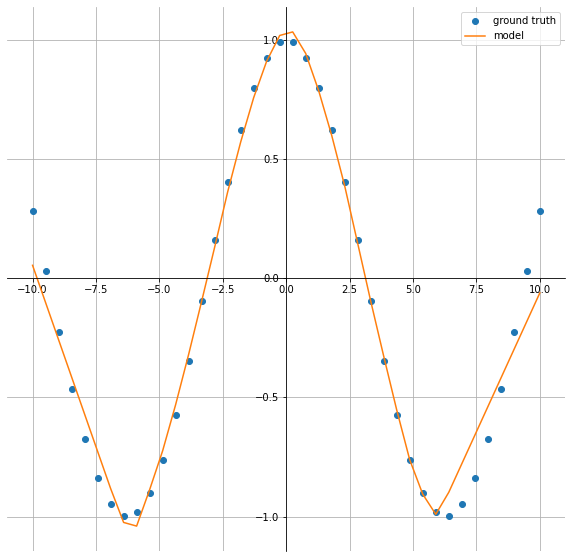

Epoch: 16200; Train Loss: 0.006419594865292311


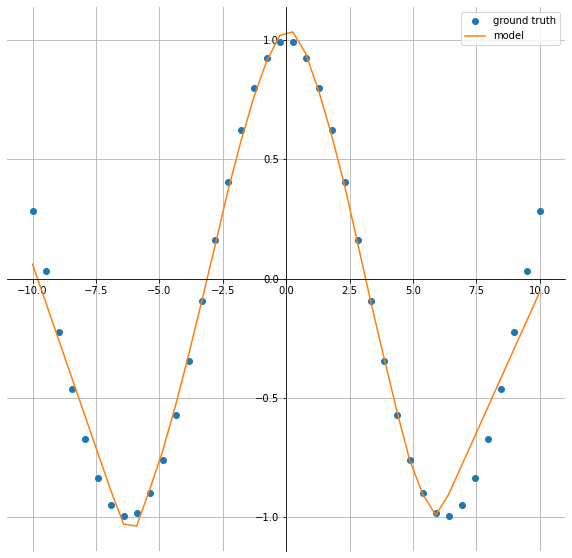

Epoch: 16300; Train Loss: 0.006174173671752214


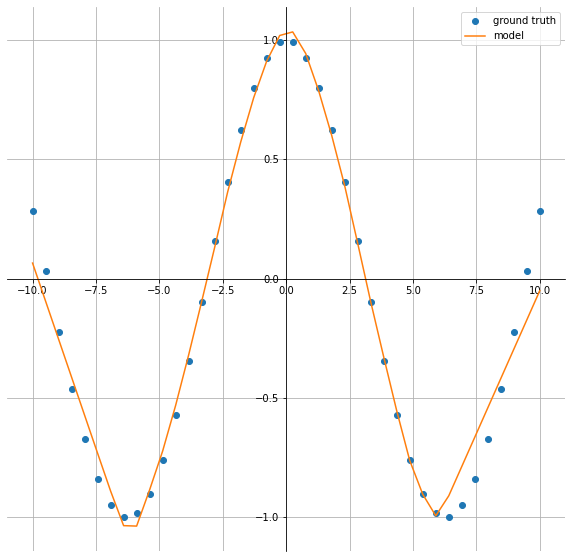

Epoch: 16400; Train Loss: 0.005941571667790413


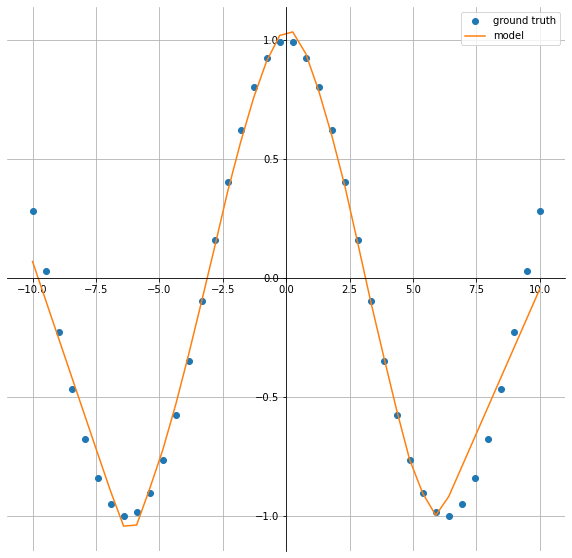

Epoch: 16500; Train Loss: 0.005722415167838335


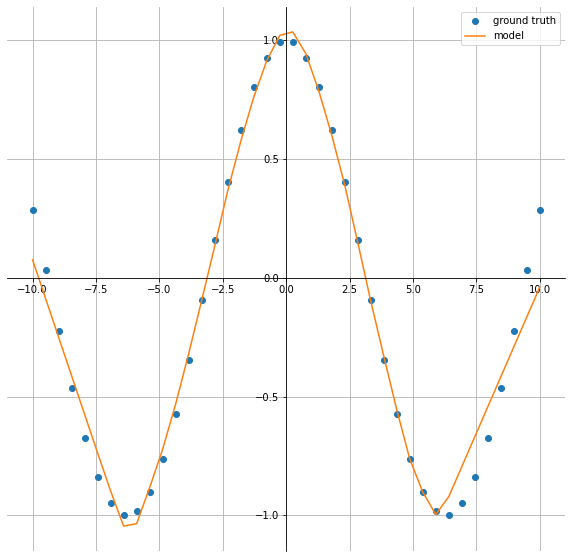

Epoch: 16600; Train Loss: 0.005514288321137428


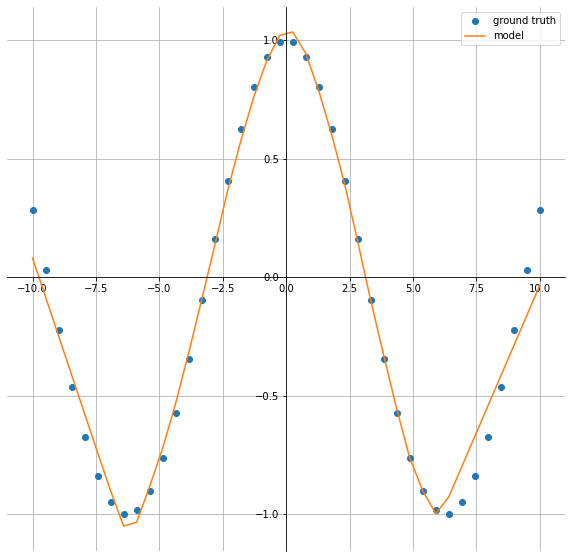

Epoch: 16700; Train Loss: 0.005317980423569679


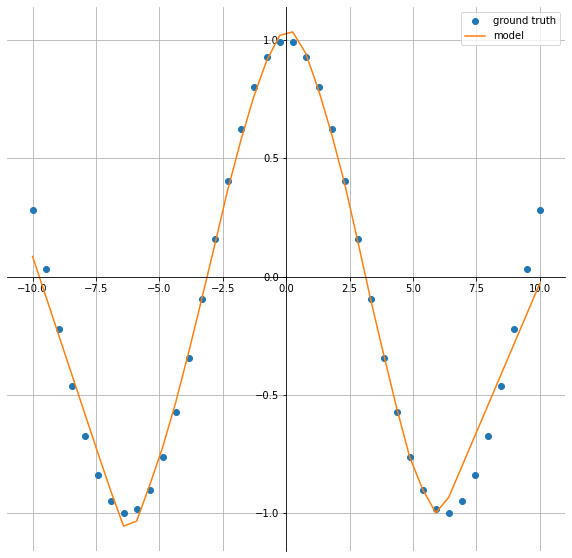

Epoch: 16800; Train Loss: 0.005132762249559164


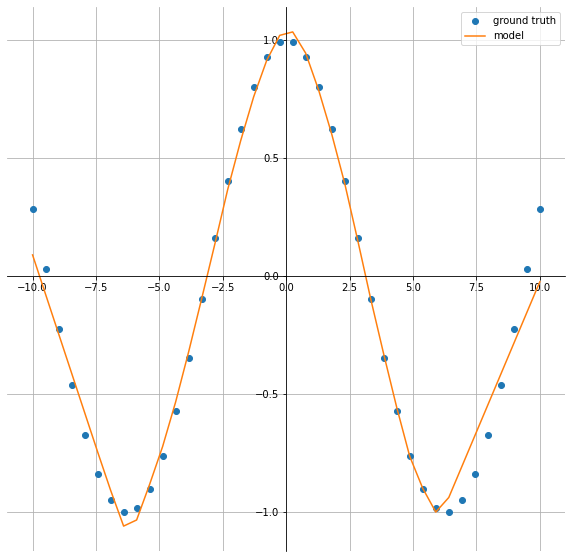

Epoch: 16900; Train Loss: 0.004958131816238165


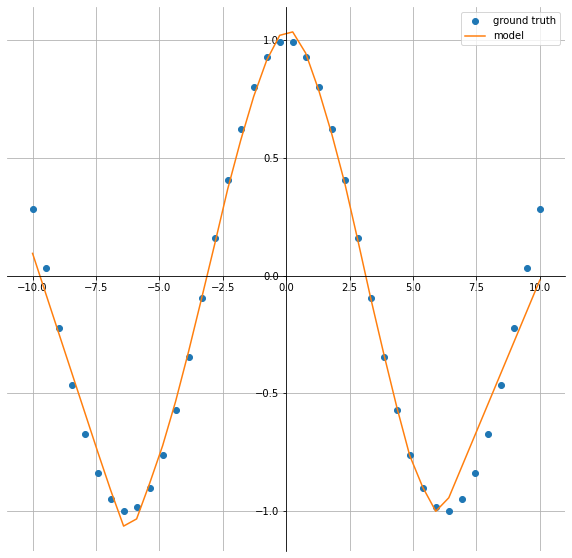

Epoch: 17000; Train Loss: 0.004792696330696344


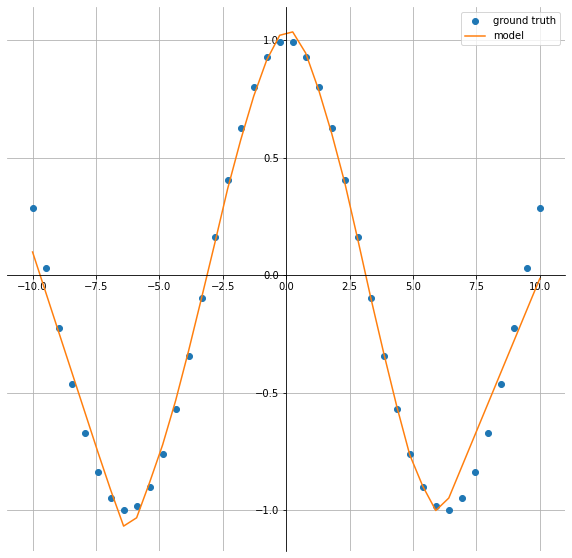

Epoch: 17100; Train Loss: 0.004634864628314972


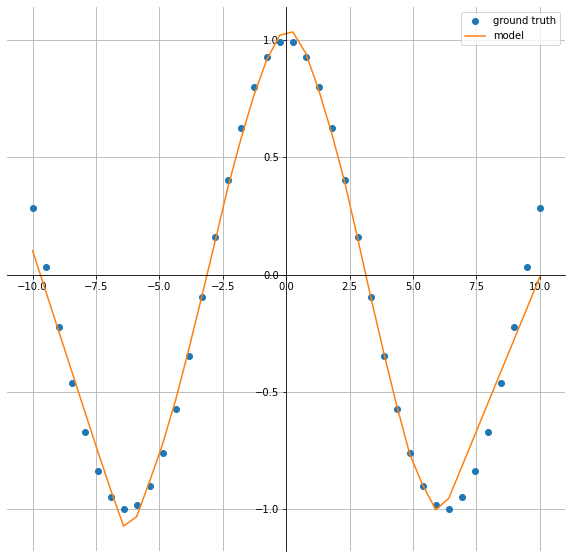

Epoch: 17200; Train Loss: 0.004483644384890795


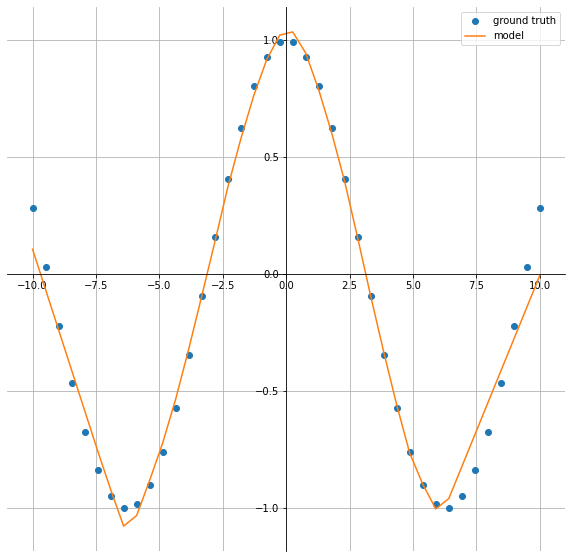

Epoch: 17300; Train Loss: 0.0043404665775597095


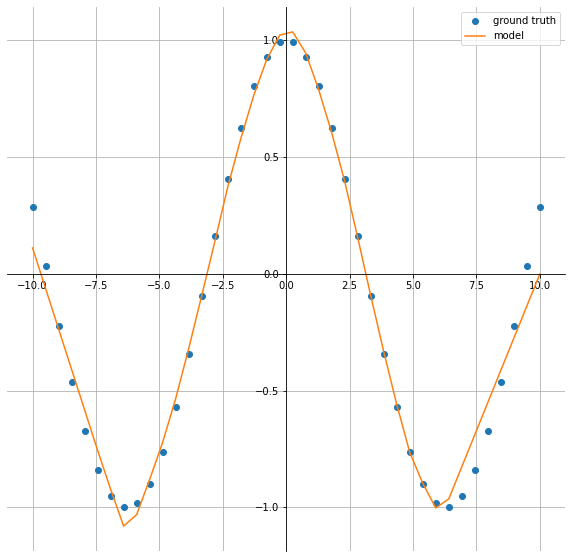

Epoch: 17400; Train Loss: 0.004205097444355488


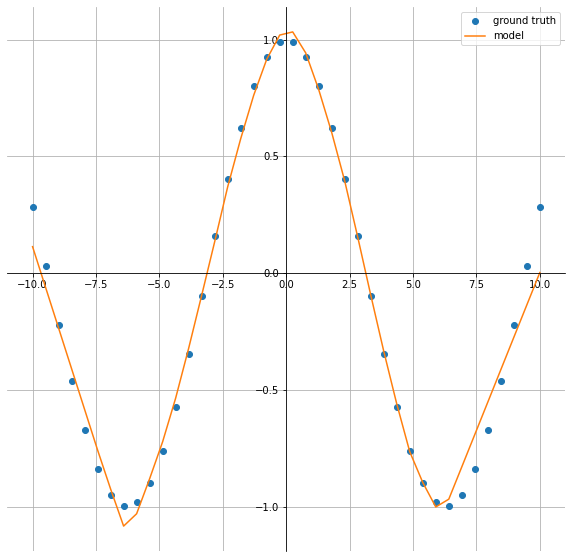

Epoch: 17500; Train Loss: 0.004076997749507427


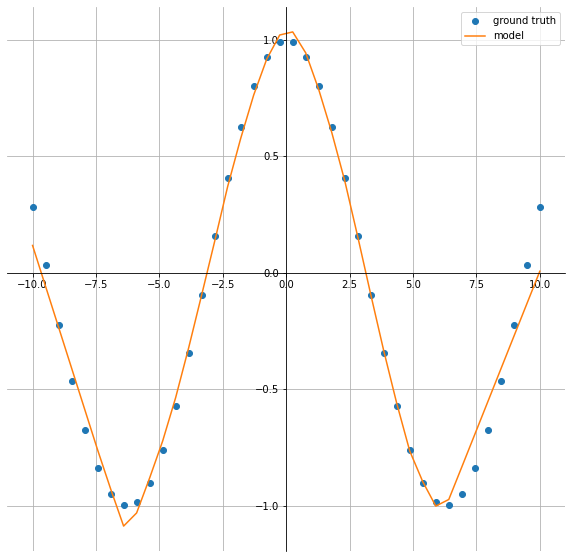

Epoch: 17600; Train Loss: 0.003955630119889975


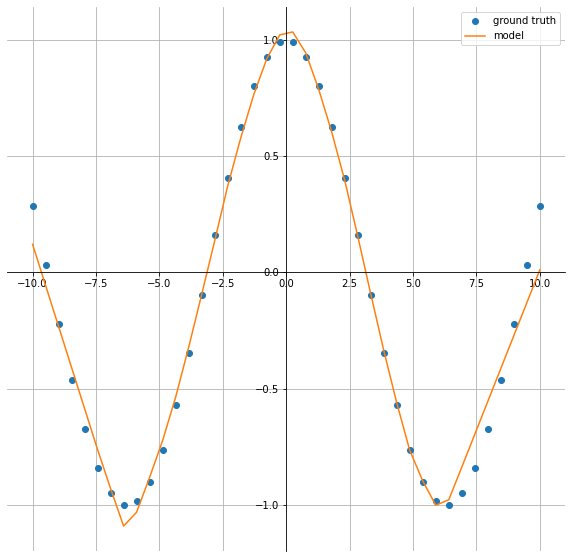

Epoch: 17700; Train Loss: 0.0038393556606024504


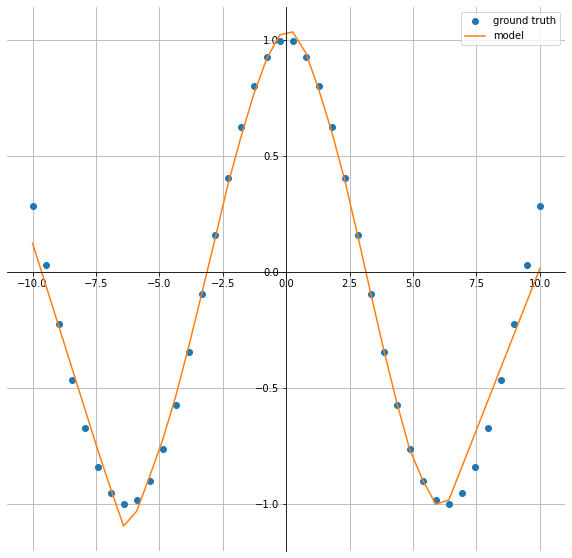

Epoch: 17800; Train Loss: 0.0037271759938448668


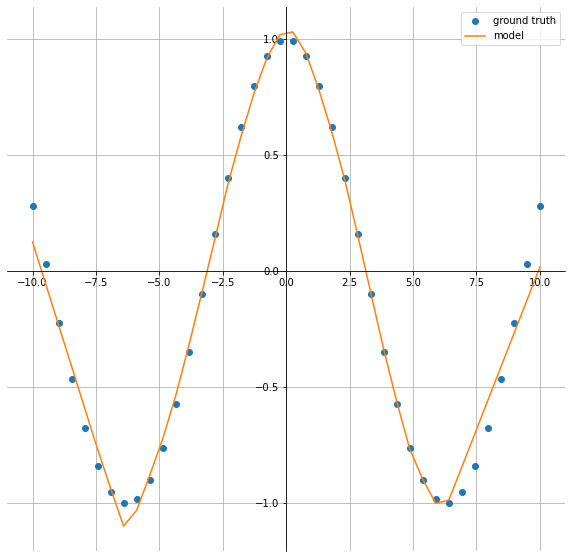

Epoch: 17900; Train Loss: 0.003619612893089652


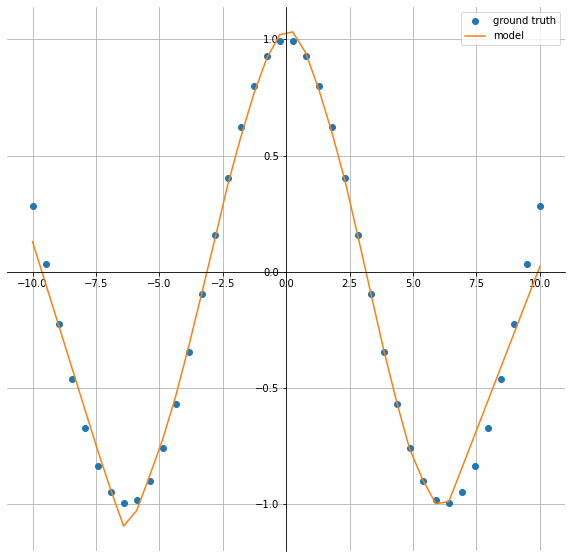

Epoch: 18000; Train Loss: 0.0035142051056027412


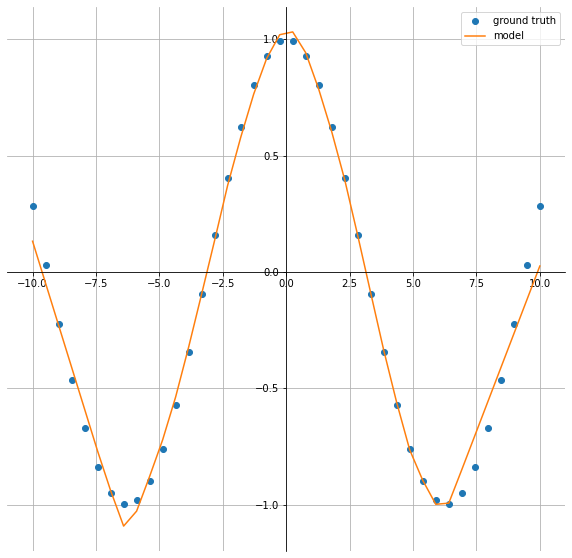

Epoch: 18100; Train Loss: 0.0034143910743296146


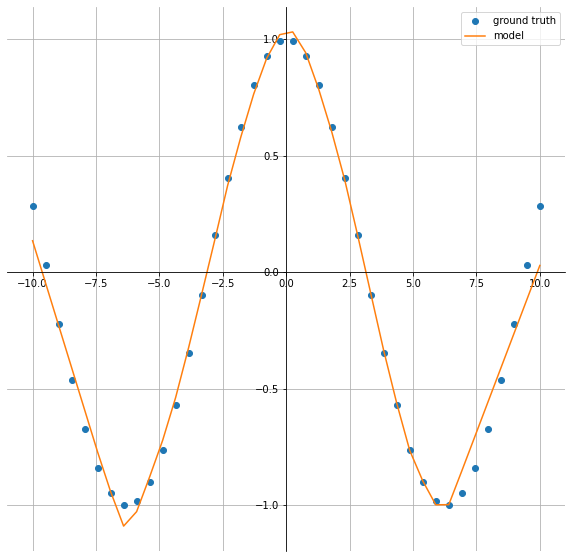

Epoch: 18200; Train Loss: 0.003317628987133503


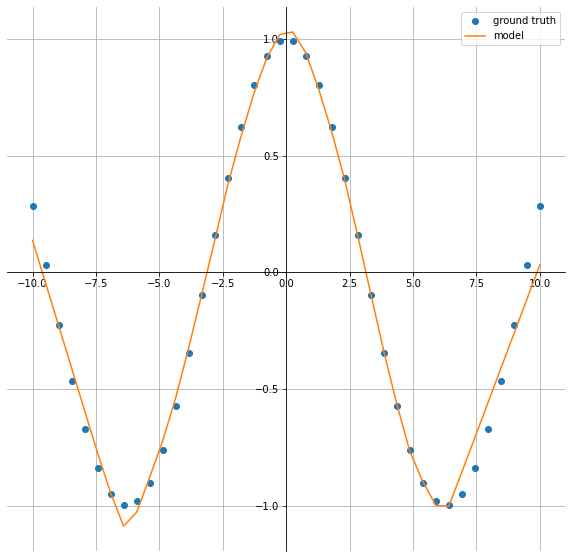

Epoch: 18300; Train Loss: 0.003221693215891719


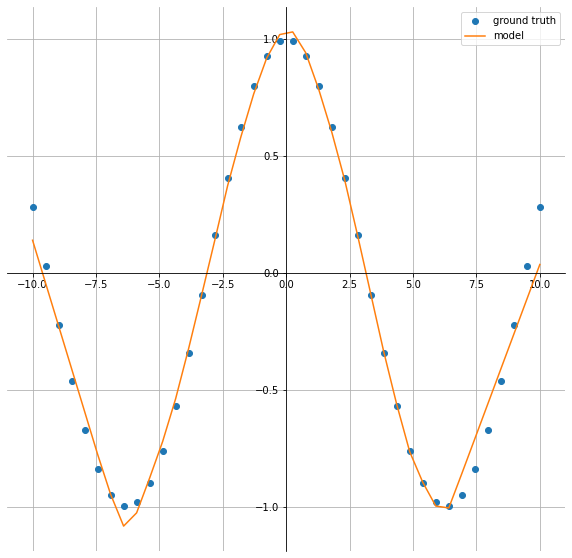

Epoch: 18400; Train Loss: 0.0031274105422198772


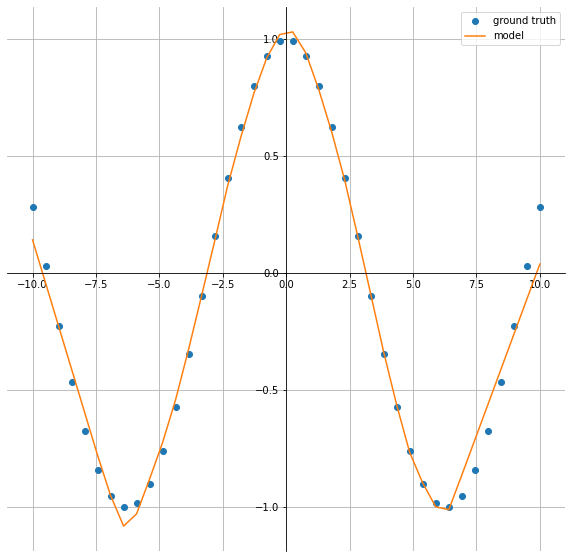

Epoch: 18500; Train Loss: 0.003035875502973795


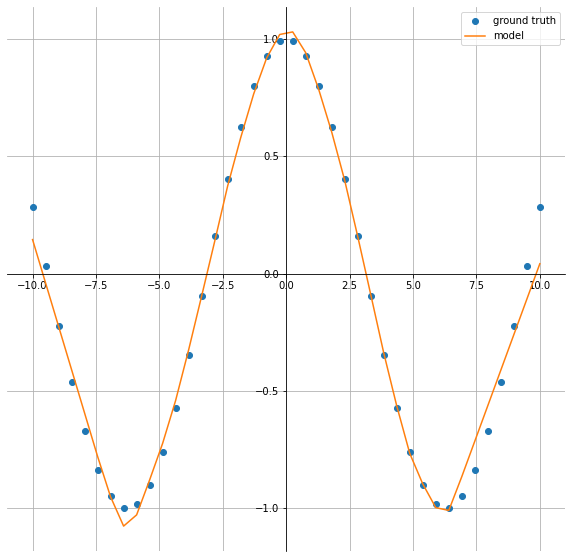

Epoch: 18600; Train Loss: 0.0029420575592666864


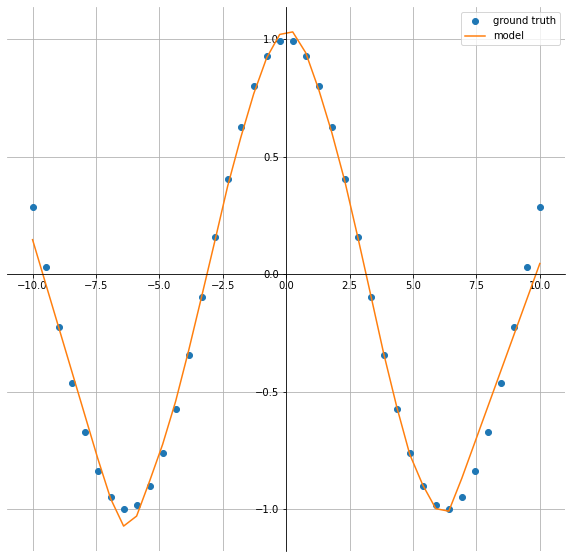

Epoch: 18700; Train Loss: 0.002849145792424679


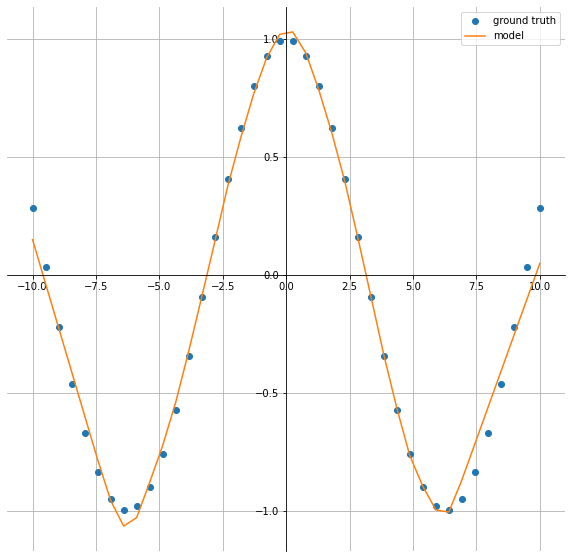

Epoch: 18800; Train Loss: 0.0027568747755140066


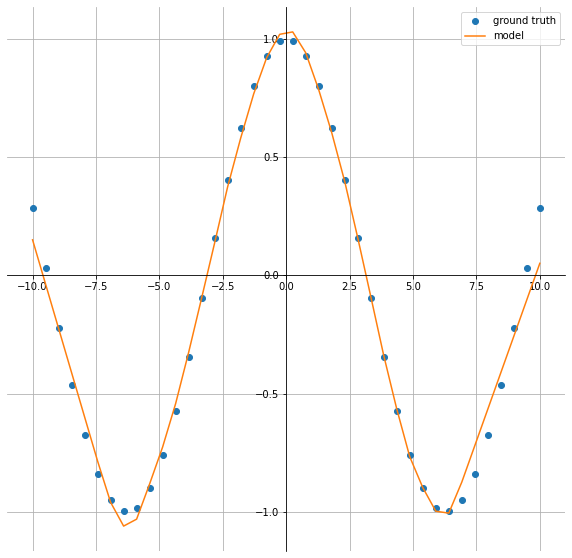

Epoch: 18900; Train Loss: 0.0026687367353588343


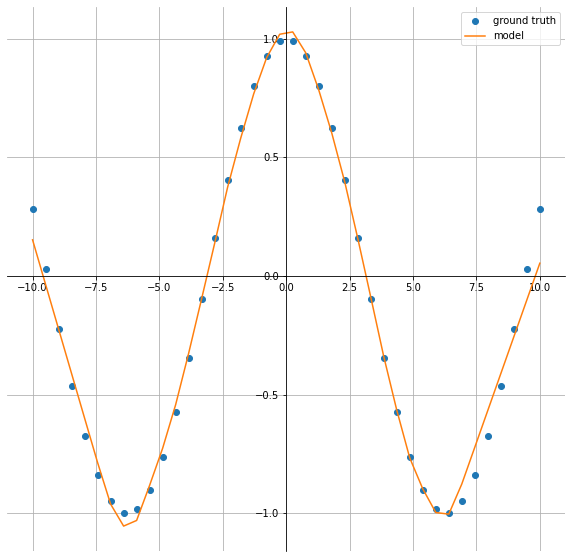

Epoch: 19000; Train Loss: 0.0025816981215029955


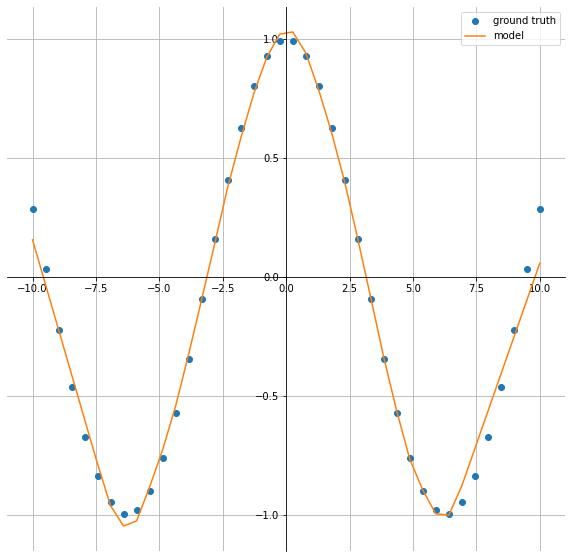

Epoch: 19100; Train Loss: 0.002498248126357794


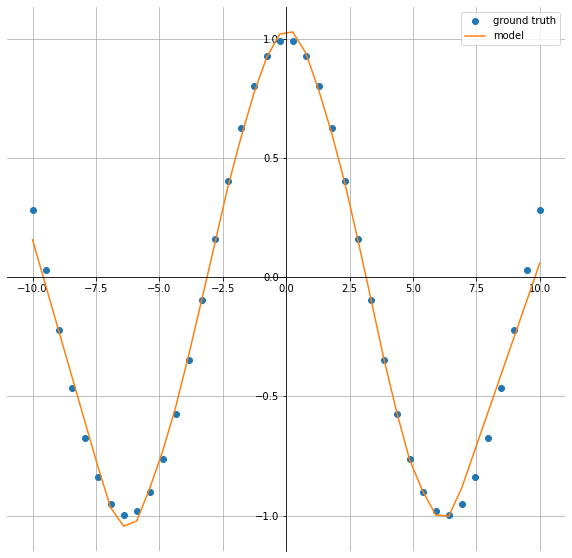

Epoch: 19200; Train Loss: 0.002417691284790635


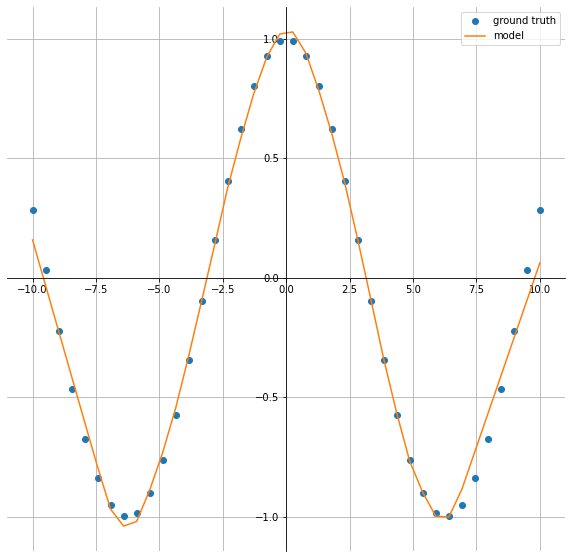

Epoch: 19300; Train Loss: 0.0023417130578309298


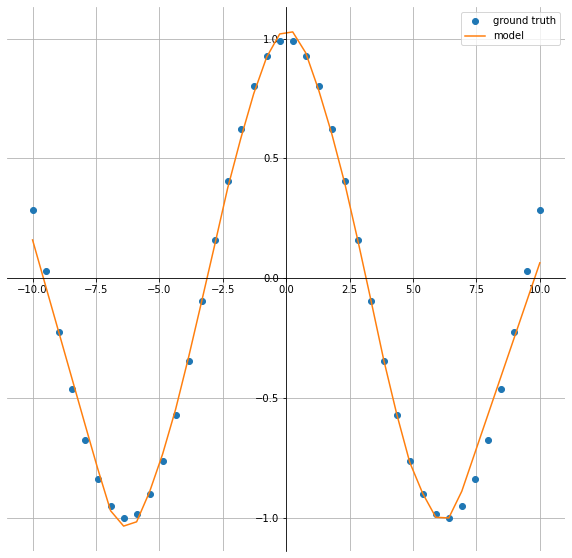

Epoch: 19400; Train Loss: 0.0022651487961411476


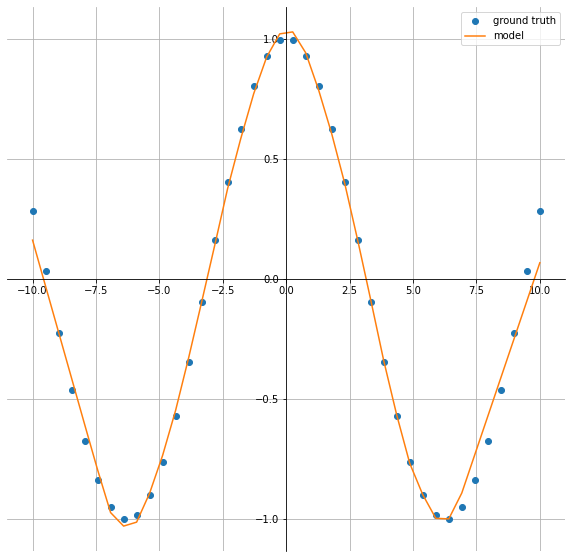

Epoch: 19500; Train Loss: 0.0021918381098657846


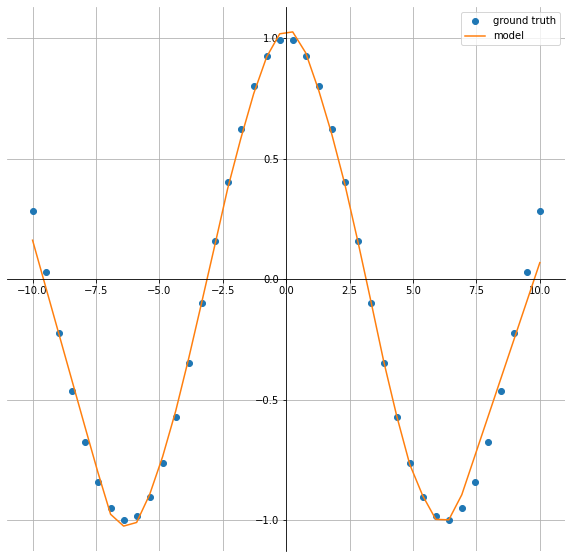

Epoch: 19600; Train Loss: 0.0021234876476228237


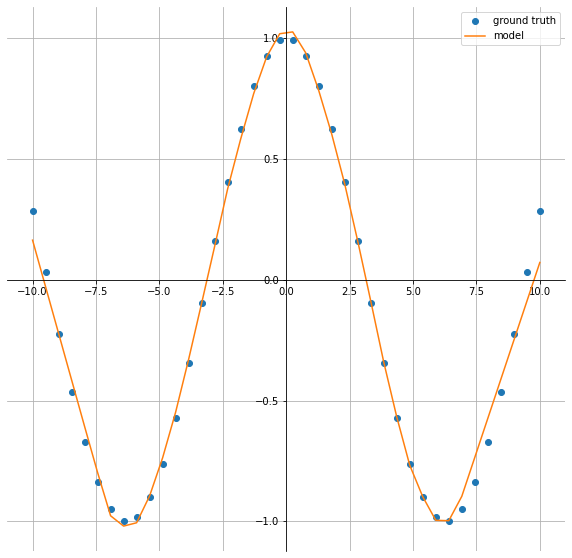

Epoch: 19700; Train Loss: 0.0020583183504641056


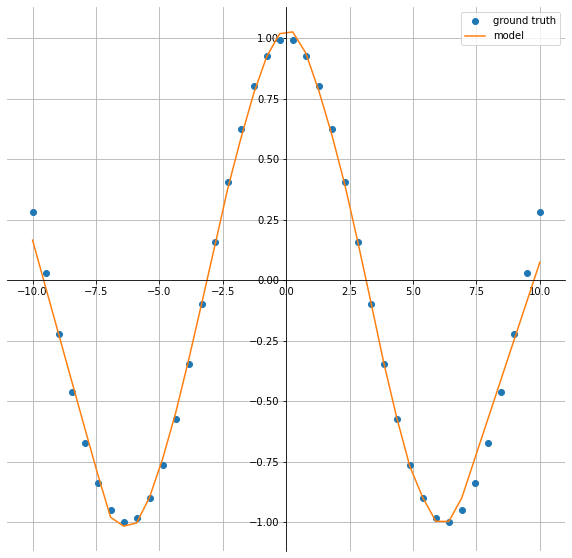

Epoch: 19800; Train Loss: 0.0019967814441770315


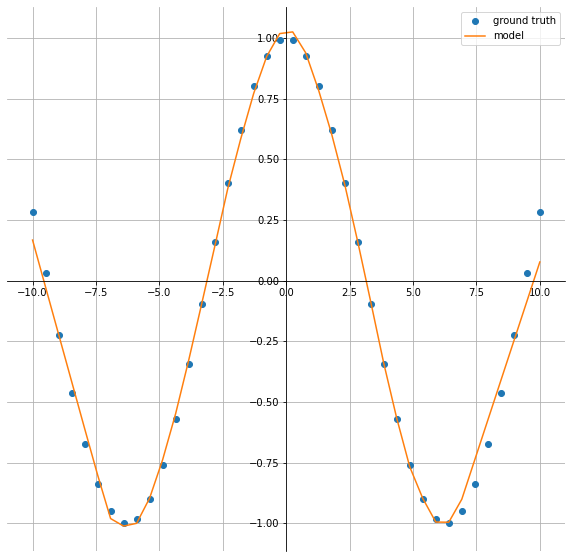

Epoch: 19900; Train Loss: 0.0019383092876523733


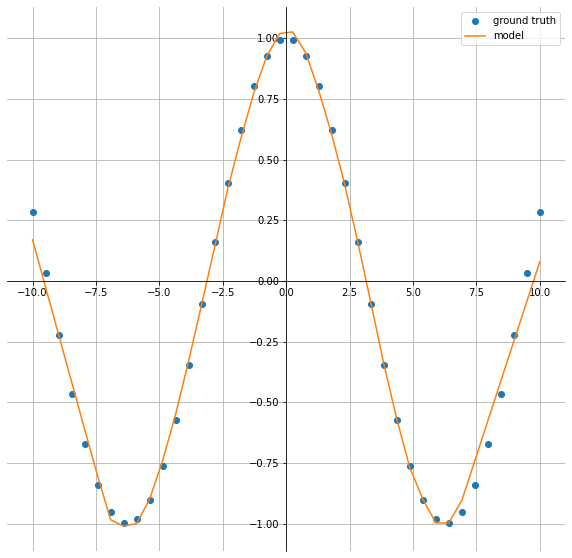

Epoch: 20000; Train Loss: 0.0018757282523438334


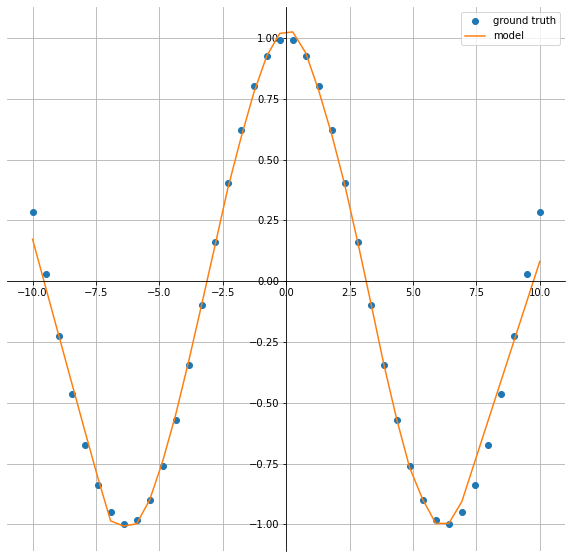

Test Loss: 0.0016939424676820636


NameError: ignored

In [23]:
epochs = 20001
for t in range(epochs):
  train_loss = train(multimodel, train_dataloader, lossfunc, optimizer)
  if t % 100 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
    plot_comparinson(f, multimodel, nsamples=40)

test_loss = test(multimodel, test_dataloader, lossfunc)
print(f"Test Loss: {test_loss}")
writer.close()